In [2]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import math

In [3]:
f = open ( "mesh_input.txt" , 'r')
input_data = []
input_data = [line.split() for line in f]
mesh_input = np.array([])
mesh_input.resize((21,21))
for i in range(len(input_data)):
    col = int(input_data[i][0])
    row = int(input_data[i][1])
    val = float(input_data[i][2])
    mesh_input[col][row] = val

In [4]:
filename_all = glob.glob("traindata/*.txt")
list_in = []
list_out = []
for filename in filename_all:
    if filename.split("_")[3] == '0.txt':
        continue
    para = filename.split("_")
    D = para[1]
    K = para[2]
    t = para[3].split(".txt")[0]
    f = open ( filename , 'r')
    row_data = []
    row_data = [line.split() for line in f]

    matrix_output = np.array([])
    matrix_output.resize((1,21,21))
    matrix_input = np.array([])
    matrix_input.resize((4,21,21))
    
    for i in range(len(row_data)):
        col = int(row_data[i][0])
        row = int(row_data[i][1])
        val = float(row_data[i][2])
        matrix_output[0][col][row] = val
        
#     matrix_input[0]=-1
#     matrix_input[0,20,1:19] = 2/3
#     matrix_input[0,:,0] = 0
#     matrix_input[0,:,20] = 0
#     matrix_input[0,0,:] = 0
    matrix_input[0] = np.copy(mesh_input)
    matrix_input[1] = D
    matrix_input[2] = K
    matrix_input[3] = t
    list_in.append(matrix_input)
    list_out.append(matrix_output)
arr_in = np.array(list_in)
arr_out = np.array(list_out)

In [5]:
train_in = []
train_out = []
test_in = []
test_out = []
for i in range(400):
    arr_train_in = np.copy(arr_in[(5*i):(5*i+5),:,:,:])
    ten_train_in = torch.from_numpy(arr_train_in)
    train_in.append(ten_train_in)
    
    arr_train_out = np.copy(arr_out[(5*i):(5*i+5),:,:,:]) 
    ten_train_out = torch.from_numpy(arr_train_out)
    train_out.append(ten_train_out)
    
for i in range(100):
    arr_test_in = np.copy(arr_in[(5*i+2000):(5*i+2005),:,:,:])
    ten_test_in = torch.from_numpy(arr_test_in)
    test_in.append(ten_test_in)
    
    arr_test_out = np.copy(arr_out[(5*i+2000):(5*i+2005),:,:,:])
    ten_test_out = torch.from_numpy(arr_test_out)
    test_out.append(ten_test_out)

In [137]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

num_epochs = 15
batch_size = 5
learning_rate = 1e-3


class rdcnn(nn.Module):
    def __init__(self):
        super(rdcnn, self).__init__()
        self.discriminator  = nn.Sequential(
            nn.Conv2d(4, 16, 3, stride=2, padding=0),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 2, stride=2),  # b, 8, 10, 10
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2),  # b, 1, 21, 21
            nn.Tanh()
        )

    def forward(self, x):
        x = self.discriminator(x)
        x = self.decoder(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = rdcnn().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
loss_L = []
for epoch in range(num_epochs):
    for i in range(len(train_in)):
        img = train_in[i]
        img = img.float()
        ground_truth = train_out[i]
        ground_truth = ground_truth.float()
        img = Variable(img).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, ground_truth)
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    loss_L.append(loss)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        save_image(output, './dc_img/image_{}.png'.format(epoch))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/15], loss:0.0042
epoch [2/15], loss:0.0027
epoch [3/15], loss:0.0020
epoch [4/15], loss:0.0019
epoch [5/15], loss:0.0016
epoch [6/15], loss:0.0016
epoch [7/15], loss:0.0017
epoch [8/15], loss:0.0017
epoch [9/15], loss:0.0016
epoch [10/15], loss:0.0017
epoch [11/15], loss:0.0016
epoch [12/15], loss:0.0014
epoch [13/15], loss:0.0013
epoch [14/15], loss:0.0013
epoch [15/15], loss:0.0011


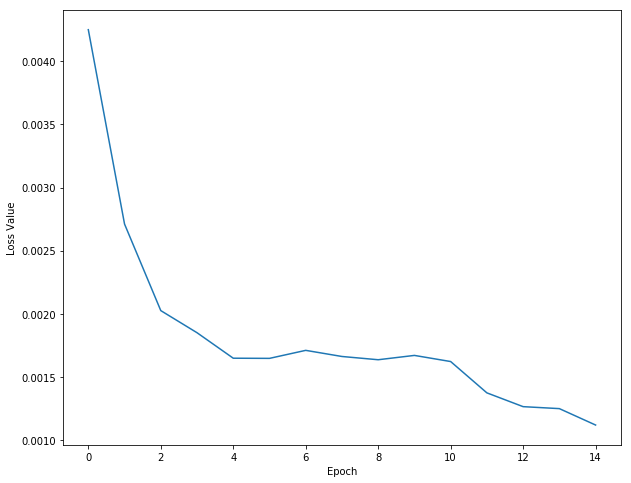

In [144]:
plt.figure(figsize=(10,8))
x = list(range(15))

plt.plot(x, loss_L)
    
# plt.title("Loss ")
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.savefig("loss_tendency")
plt.show()


In [7]:
if not os.path.exists('./test_img'):
    os.mkdir('./test_img')
for i in range(len(test_in)):
    img = test_in[i]
    img = test_in[i].float()
    ground_truth = test_out[i]
    ground_truth = ground_truth.float()
    img = Variable(img).to(device)

    output = model(img)

    loss = criterion(output, ground_truth)

    save_image(output, './test_img/image_{}.png'.format(i))
    save_image(ground_truth, './test_img/ground_truth_{}.png'.format(i))


In [8]:
model_output = []
for i in range(len(test_in)):
    img = test_in[i]
    img = test_in[i].float()
    ground_truth = test_out[i]
    ground_truth = ground_truth.float()
    img = Variable(img).to(device)

    output = model(img)
    model_output.append(output)

In [9]:
if not os.path.exists('./test_txt'):
    os.mkdir('./test_txt')

for index in range(50):
    arr_in = test_in[index]
    arr_out = model_output[index].detach()
    array_in = arr_in.numpy()[:, :, :, :]
    array_out = arr_out.numpy()[:, :, :, :]
    
    for piece_index in range(5):
        D = array_in[piece_index,1,1,1]
        k = array_in[piece_index,2,1,1]
        t = array_in[piece_index,3,1,1]

        write_array = array_out[piece_index,:,:,:].reshape(21,21)

        dir_name = "./test_txt/"
        filename = dir_name + "mesh_"+str(int(D))+"_"+str(int(k))+"_"+str(t)+".txt"
        text = ""
        f = open(filename,"w")
        for i in range(21):
            for j in range (21):
                text = text + str(i) + " " + str(j) + " " + str(write_array[i][j]) +"\n"

        f.write(text)                                    
        f.close()

In [10]:
def readFileasArray(filename):
    f = open ( filename , 'r')
    row_data = []
    row_data = [line.split() for line in f]

    matrix = np.array([])
    matrix.resize((21,21))

    for i in range(len(row_data)):
        col = int(row_data[i][0])
        row = int(row_data[i][1])
        val = float(row_data[i][2])
        matrix[col][row] = val
    return matrix

## t changed 

## 所有train出来的数据，按字母顺序粗略排了

In [11]:
filename_all = glob.glob("test_txt/*.txt")
list_t = []
list_t.append(readFileasArray("test_txt/mesh_1_3_0.0.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_1.4.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_3.6.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_5.4.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_9.9.txt"))

list_r = []
list_r.append(readFileasArray("traindata/mesh_1_3_0.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_1.4.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_3.6.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_5.4.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_9.9.txt"))

FileNotFoundError: [Errno 2] No such file or directory: 'test_txt/mesh_1_3_0.0.txt'

In [13]:
filename_all_test = glob.glob("test_txt/*.txt")
filename_all_test.sort(key=str.lower)
filename_all_test

['test_txt/mesh_10_10_1.4.txt',
 'test_txt/mesh_10_10_1.5.txt',
 'test_txt/mesh_10_10_1.7.txt',
 'test_txt/mesh_10_10_3.2.txt',
 'test_txt/mesh_10_10_3.5.txt',
 'test_txt/mesh_10_10_3.6.txt',
 'test_txt/mesh_10_10_3.7.txt',
 'test_txt/mesh_10_10_5.1.txt',
 'test_txt/mesh_10_10_5.4.txt',
 'test_txt/mesh_10_10_7.2.txt',
 'test_txt/mesh_10_10_7.3.txt',
 'test_txt/mesh_10_1_1.9.txt',
 'test_txt/mesh_10_1_5.8.txt',
 'test_txt/mesh_10_1_5.9.txt',
 'test_txt/mesh_10_1_9.4.txt',
 'test_txt/mesh_10_1_9.5.txt',
 'test_txt/mesh_10_3_0.8.txt',
 'test_txt/mesh_10_3_0.9.txt',
 'test_txt/mesh_10_3_2.9.txt',
 'test_txt/mesh_10_3_4.8.txt',
 'test_txt/mesh_10_3_8.1.txt',
 'test_txt/mesh_10_6_0.4.txt',
 'test_txt/mesh_10_6_0.5.txt',
 'test_txt/mesh_10_6_10.0.txt',
 'test_txt/mesh_10_6_2.3.txt',
 'test_txt/mesh_10_6_2.6.txt',
 'test_txt/mesh_10_6_2.7.txt',
 'test_txt/mesh_10_6_4.1.txt',
 'test_txt/mesh_10_6_4.2.txt',
 'test_txt/mesh_10_6_4.5.txt',
 'test_txt/mesh_10_6_6.2.txt',
 'test_txt/mesh_10_6_6.3.tx

## Loss

In [15]:
filename = 'mesh_10_6_10.0.txt'
def loss_one_file(filename):
    if "/" in filename:
        filename = filename.split("/")[1]
        
    trained = readFileasArray("test_txt/"+filename)

    f_l = filename.split(".")
    if f_l[1] == "0":
        new_name = f_l[0] + "." + f_l[2]
        ground_true = readFileasArray("traindata/"+new_name)
    else:
        ground_true = readFileasArray("traindata/"+filename)
    sum_loss = 0
    for i in range(21):
        for j in range(21):
            sum_loss = sum_loss + ((trained[i][j] - ground_true[i][j]))**2

    return math.sqrt(sum_loss)/441
        

In [16]:
def loss_for_list_of_file(file_list):
    sum_loss = 0
    for file_name in file_list:
        sum_loss = sum_loss + loss_one_file(file_name)
    return sum_loss/len(file_list)

## 所有train出来数据的平均loss

In [17]:

loss_for_list_of_file(filename_all_test)

0.0010993181459482213

## 每个文件对应的loss（用来找质量高的图）

In [18]:
for filename in filename_all_test:
    print(filename,loss_one_file(filename))

test_txt/mesh_10_10_1.4.txt 0.0006303363888314018
test_txt/mesh_10_10_1.5.txt 0.000633118881219163
test_txt/mesh_10_10_1.7.txt 0.0006376475053105844
test_txt/mesh_10_10_3.2.txt 0.0006836302408795615
test_txt/mesh_10_10_3.5.txt 0.000701064577967365
test_txt/mesh_10_10_3.6.txt 0.0007068512669231483
test_txt/mesh_10_10_3.7.txt 0.0007126600348403643
test_txt/mesh_10_10_5.1.txt 0.0007549580990257869
test_txt/mesh_10_10_5.4.txt 0.0007519614796202495
test_txt/mesh_10_10_7.2.txt 0.0007330221572028212
test_txt/mesh_10_10_7.3.txt 0.0007322002819647767
test_txt/mesh_10_1_1.9.txt 0.0005343396446885268
test_txt/mesh_10_1_5.8.txt 0.0004790630769398641
test_txt/mesh_10_1_5.9.txt 0.00047775543831332136
test_txt/mesh_10_1_9.4.txt 0.0004774013785649367
test_txt/mesh_10_1_9.5.txt 0.0004791815013090932
test_txt/mesh_10_3_0.8.txt 0.0006349116662480233
test_txt/mesh_10_3_0.9.txt 0.0006400405801832754
test_txt/mesh_10_3_2.9.txt 0.0006605422444182182
test_txt/mesh_10_3_4.8.txt 0.0005976052957911563
test_txt/m

test_txt/mesh_8_1_3.0.txt 0.0005426881900377847
test_txt/mesh_8_1_3.8.txt 0.0005370087536779565
test_txt/mesh_8_1_6.0.txt 0.0005234442587580916
test_txt/mesh_8_1_7.8.txt 0.0004725376814702151
test_txt/mesh_8_1_7.9.txt 0.0004698355204654199
test_txt/mesh_8_1_9.3.txt 0.00043404700806445705
test_txt/mesh_8_1_9.6.txt 0.0004278039709980426
test_txt/mesh_8_1_9.7.txt 0.00042588792538987097
test_txt/mesh_8_3_0.8.txt 0.0006890493371843342
test_txt/mesh_8_3_1.0.txt 0.0006989446050845261
test_txt/mesh_8_3_2.8.txt 0.0006776354605581747
test_txt/mesh_8_3_2.9.txt 0.0006736790388712603
test_txt/mesh_8_3_4.0.txt 0.0006310735968544054
test_txt/mesh_8_3_6.9.txt 0.0005266589972942544
test_txt/mesh_8_3_8.2.txt 0.0004896909399944181
test_txt/mesh_8_3_8.3.txt 0.0004869258516166165
test_txt/mesh_8_6_0.2.txt 0.0011012138889166126
test_txt/mesh_8_6_0.6.txt 0.0006643461935902334
test_txt/mesh_8_6_0.7.txt 0.0007021383240433751
test_txt/mesh_8_6_2.4.txt 0.0007589460213355052
test_txt/mesh_8_6_2.5.txt 0.0007552631

In [144]:
def plot_contrast(filename):
    para = filename.split("_")
    D = para[1]
    K = para[2]
    t = para[3].split(".txt")[0]

    fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].set_title("Generate data")
    im = ax[0].imshow(readFileasArray("test_txt/"+filename),cmap = 'rainbow' )

    ax[0].axis('off')
    
    f_l = filename.split(".")
    if f_l[1] == "0":
        new_name = f_l[0] + "." + f_l[2]
        ax[1].imshow(readFileasArray("traindata/"+new_name),cmap='rainbow')
    else:
        ax[1].imshow(readFileasArray("traindata/"+filename),cmap='rainbow')
    ax[1].axis('off')
    ax[1].set_title("Ground Truth data")

    fig.colorbar(im, ax=ax.ravel().tolist())

    fig.suptitle("D = "+D+"     K = "+K+"      t = "+t, fontsize=20)
    plt.show()
# ,vmin=-1, vmax=2

## 所有train出来数据跟ground true的对比图

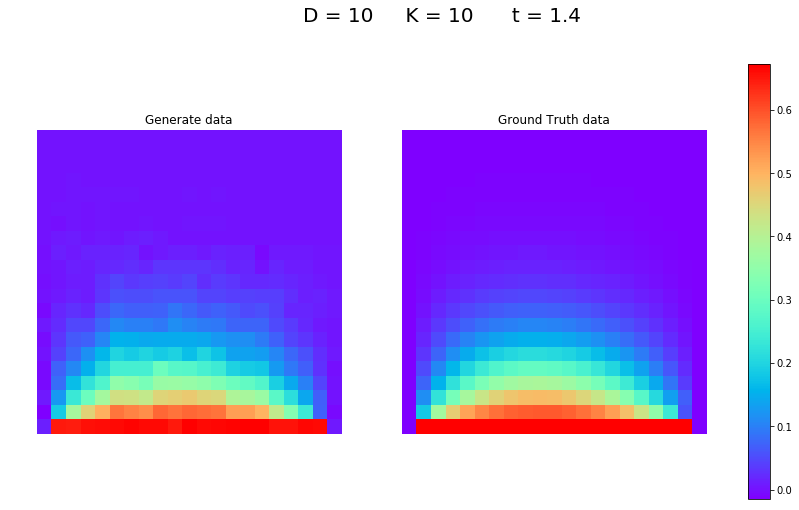

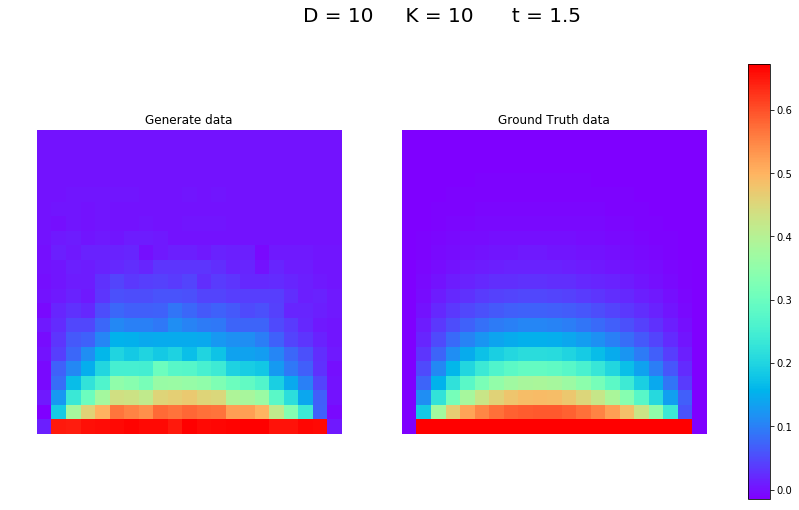

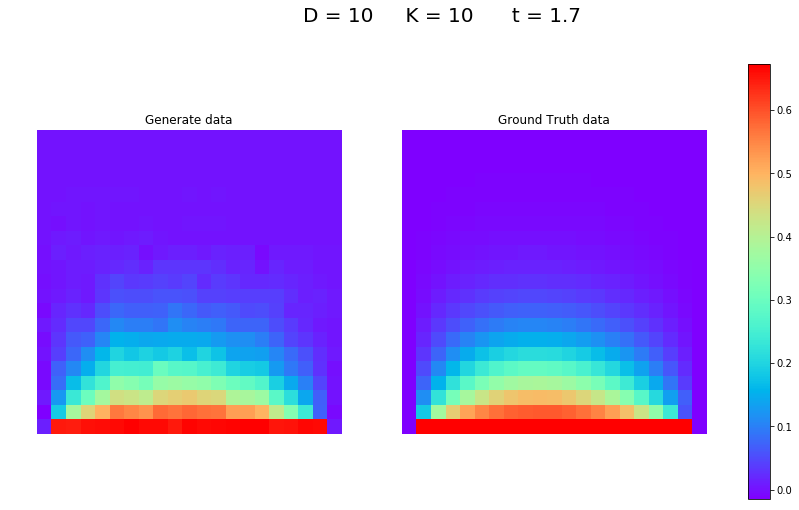

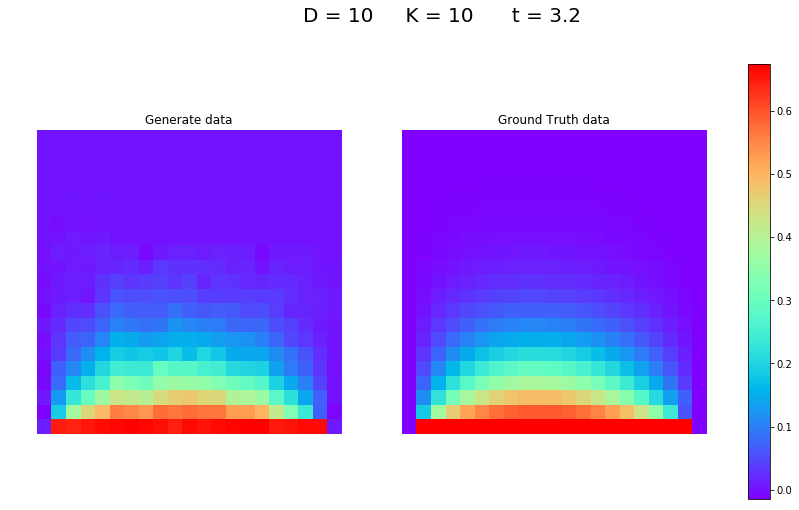

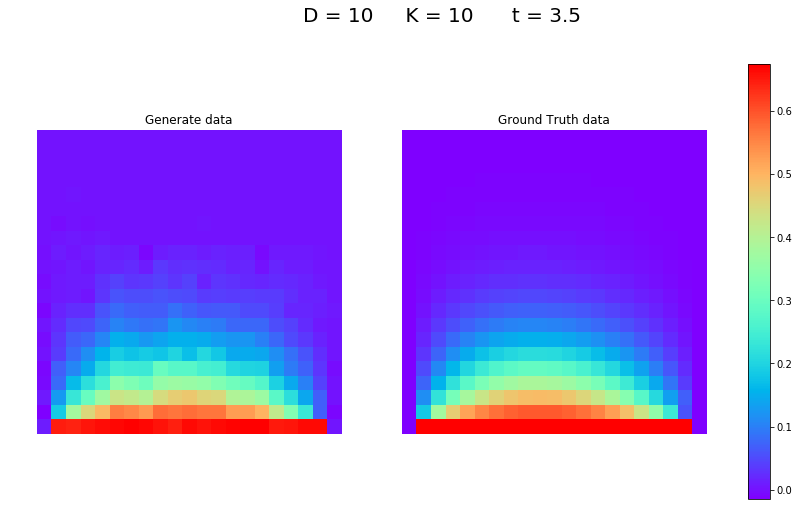

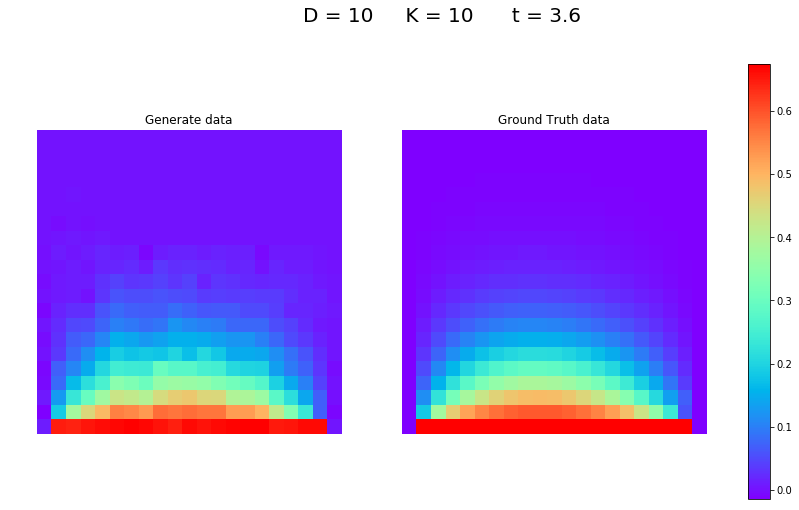

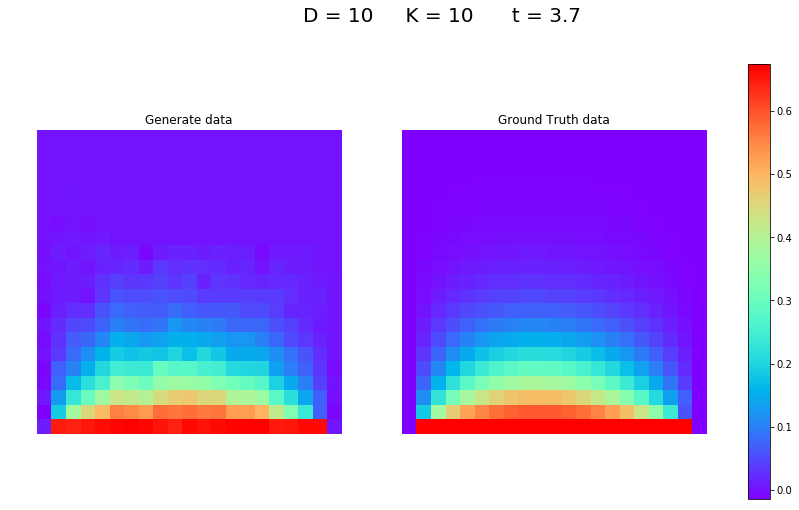

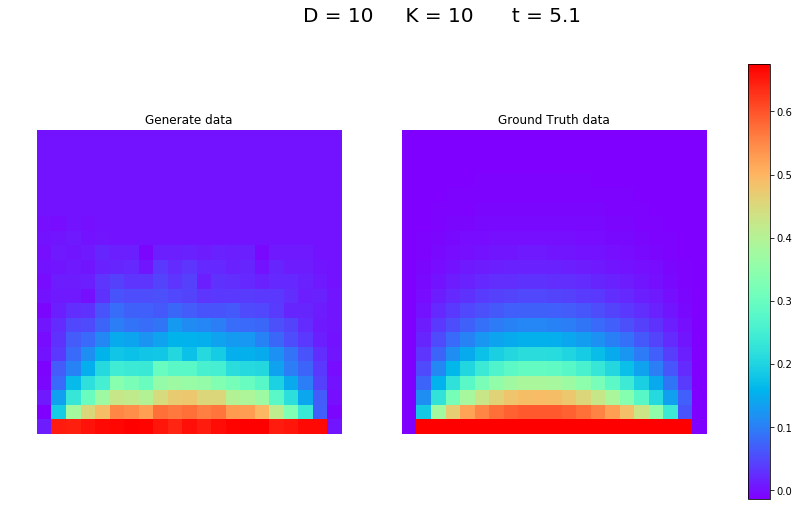

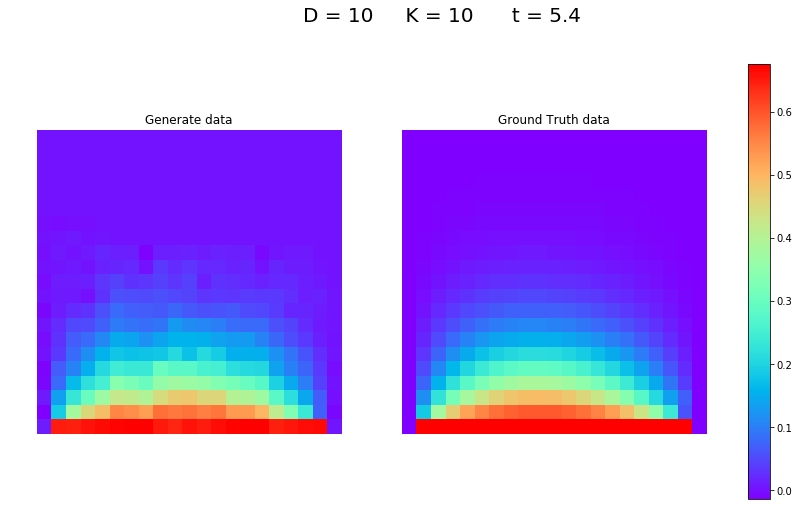

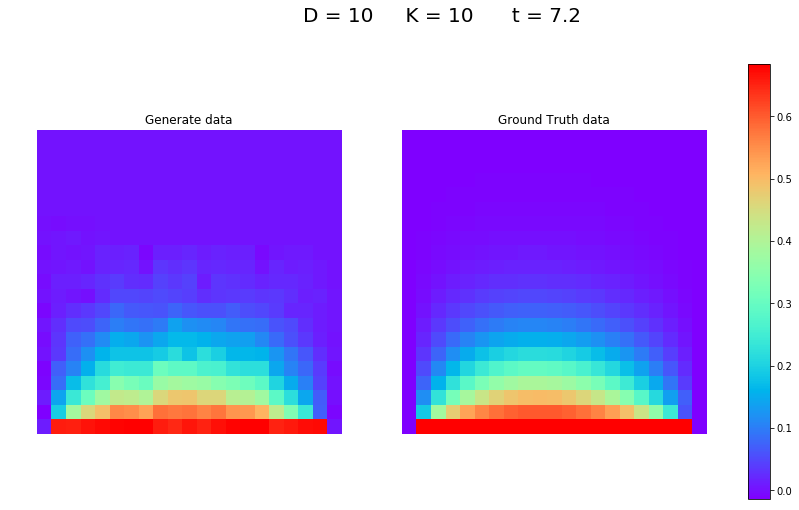

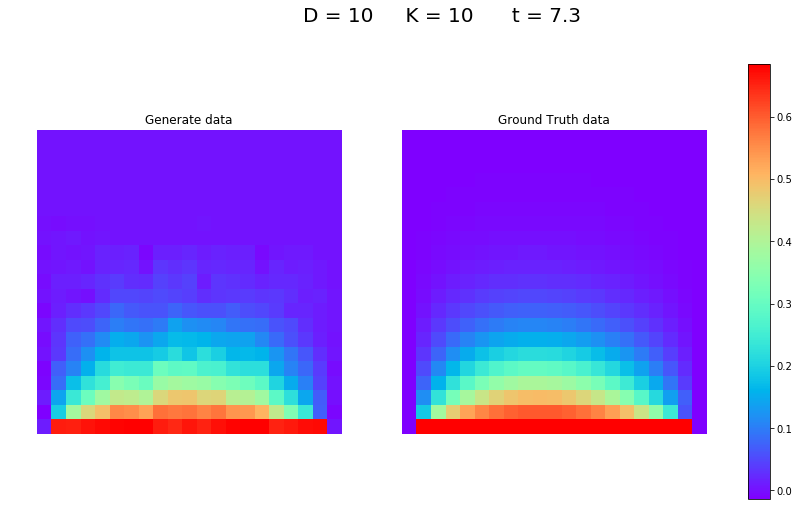

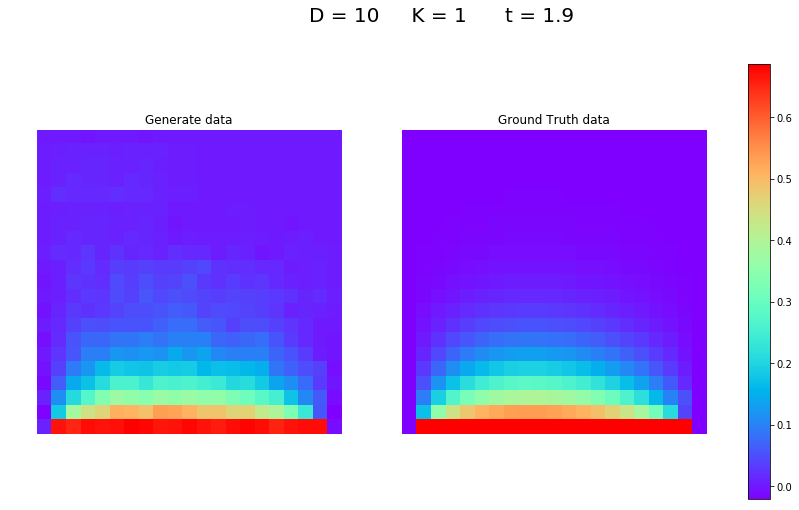

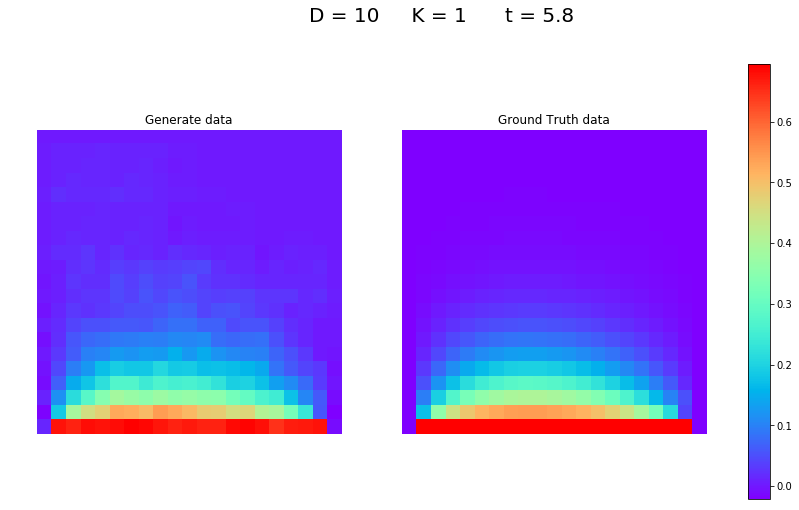

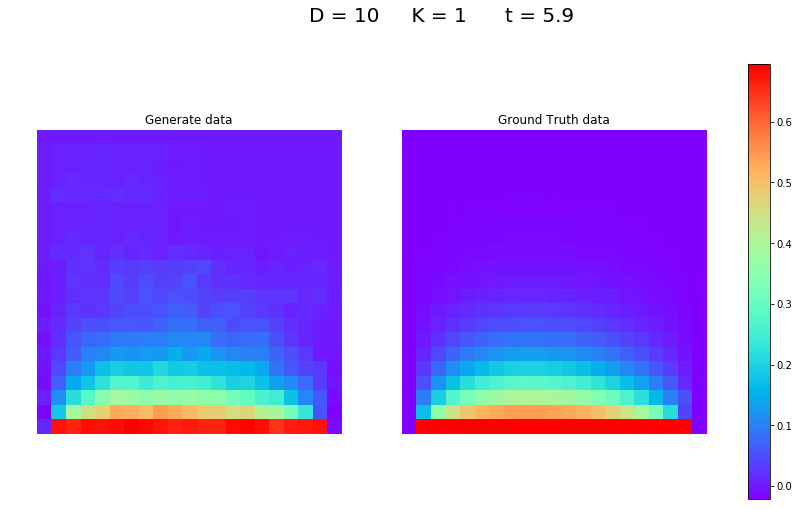

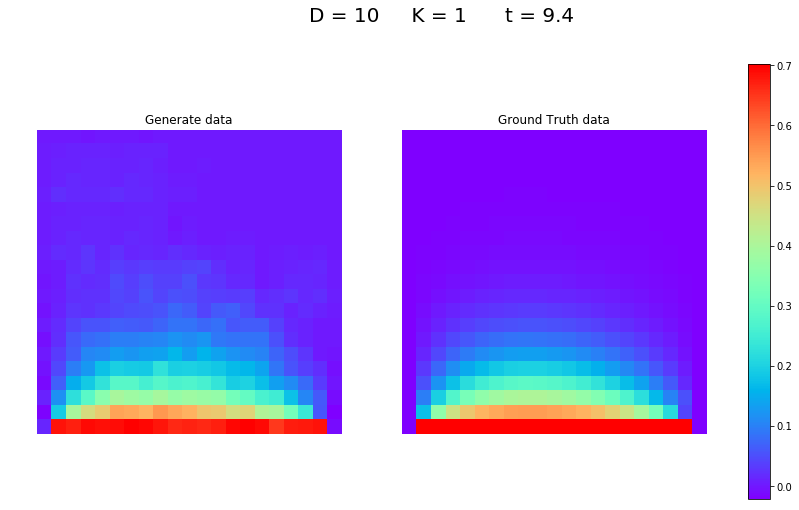

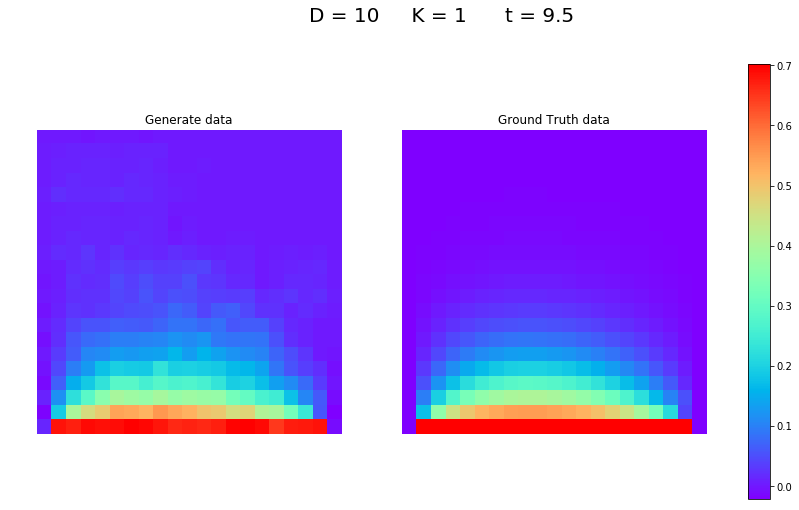

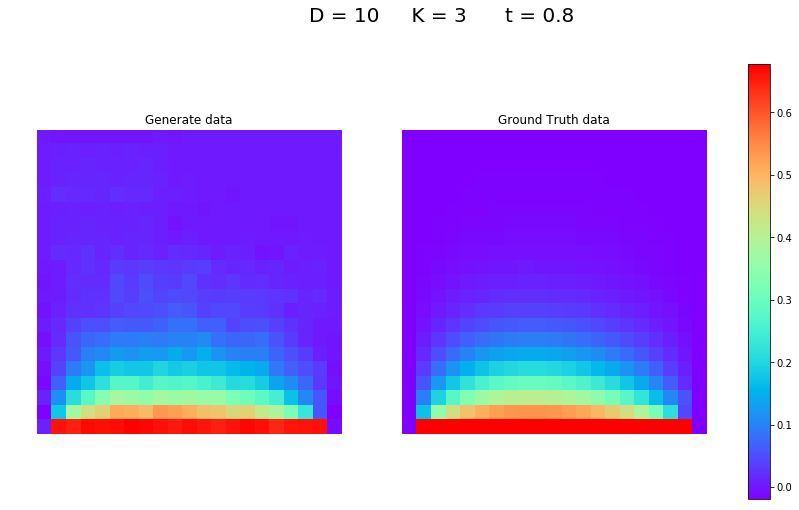

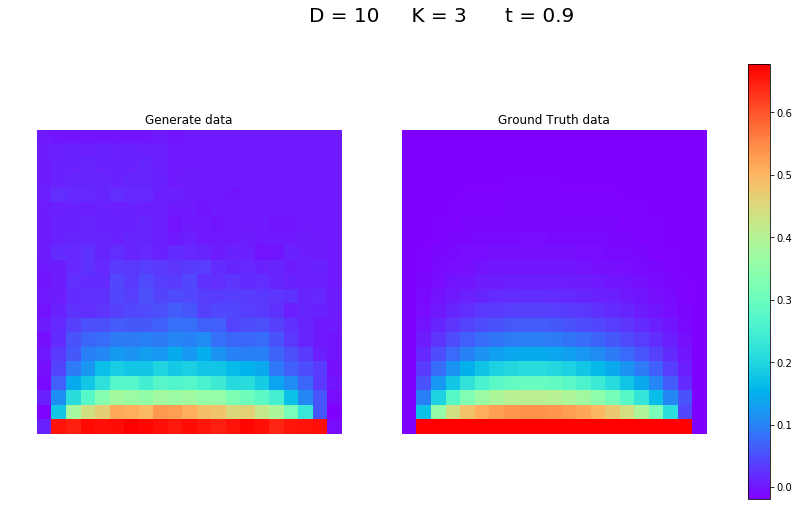

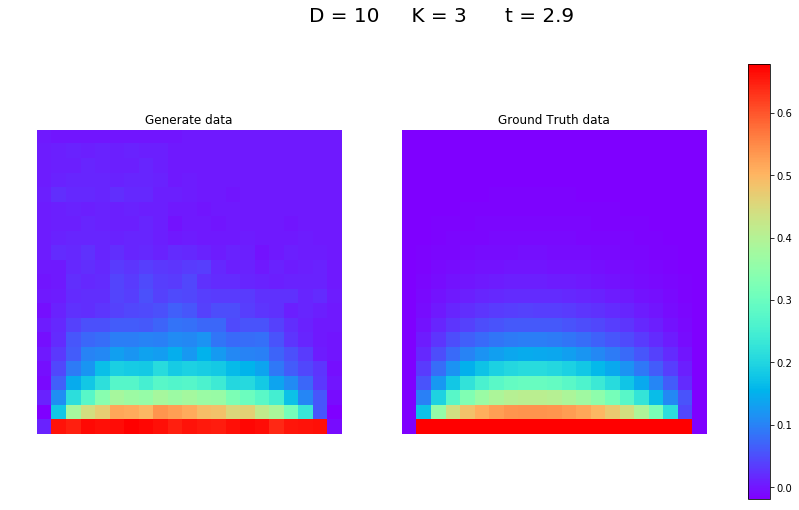

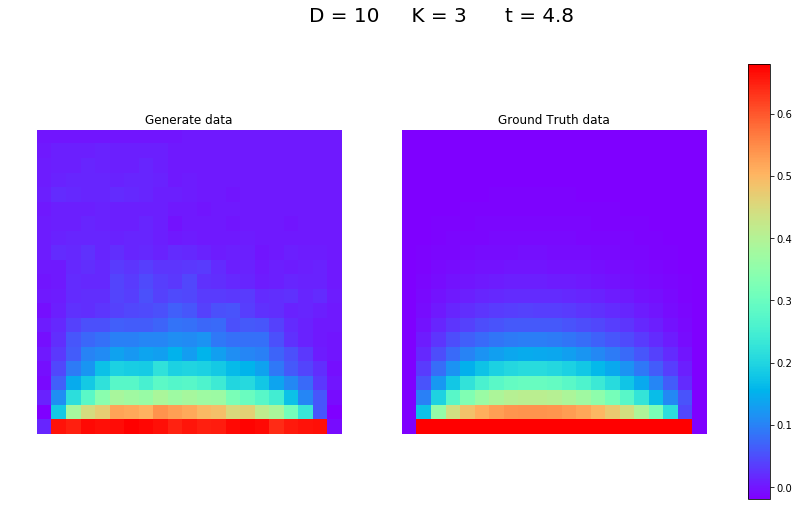

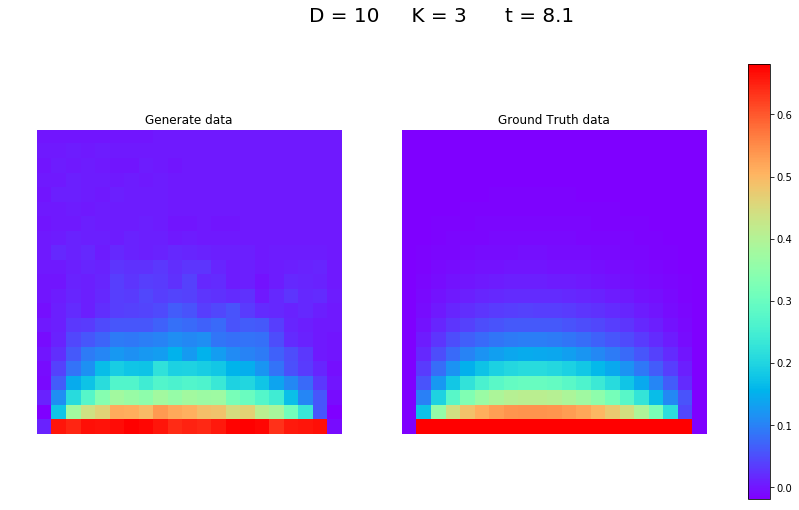

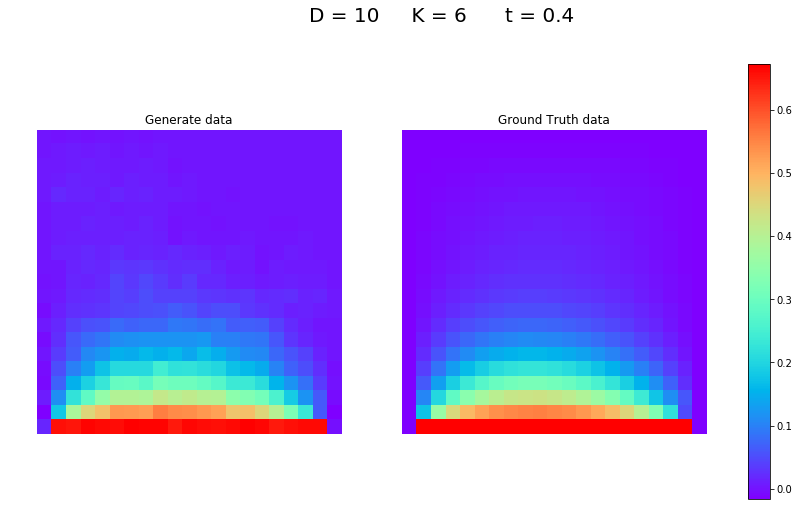

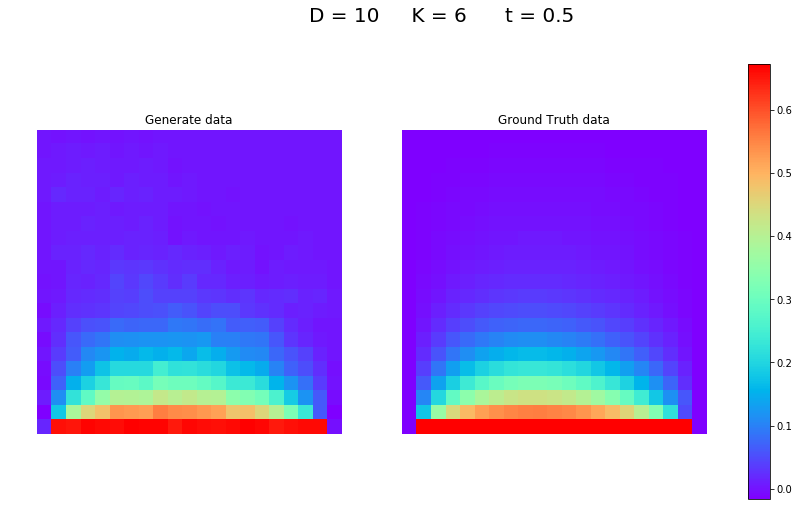

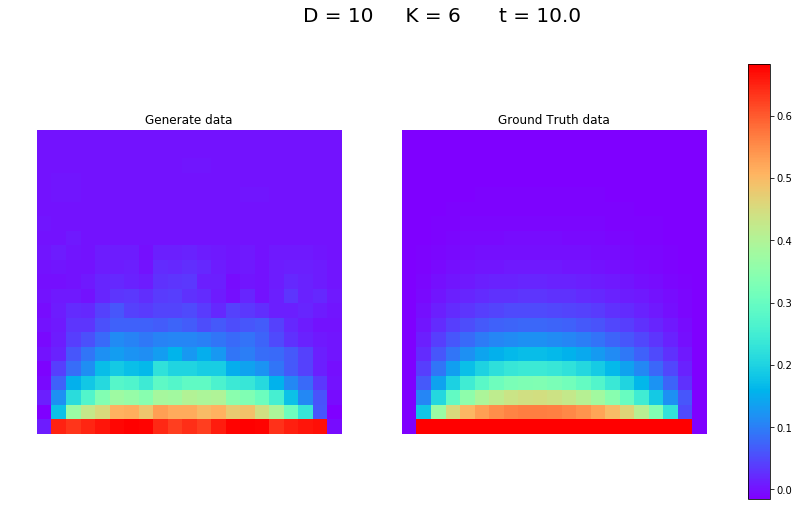

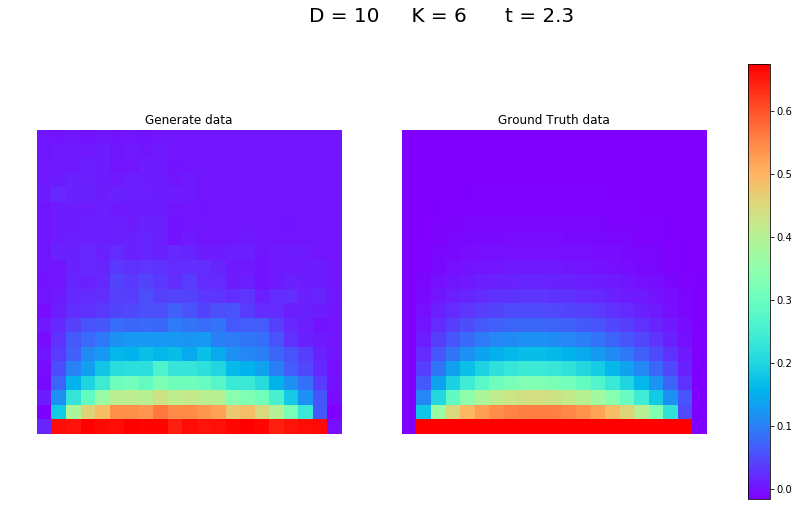

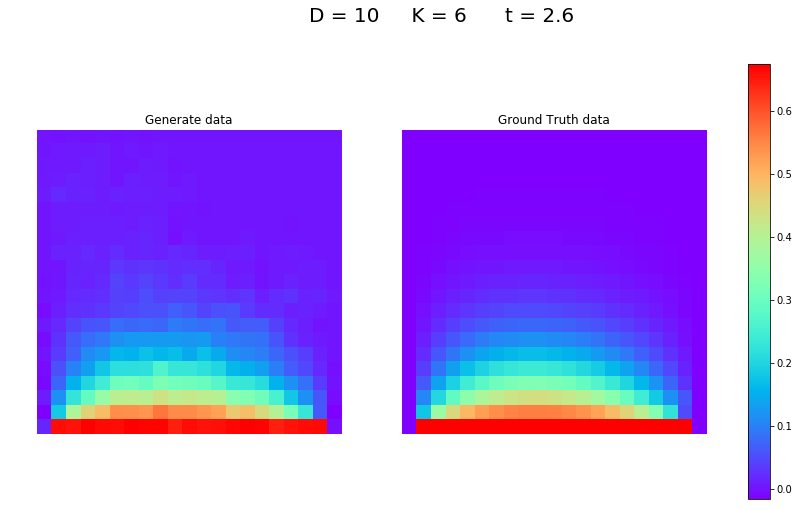

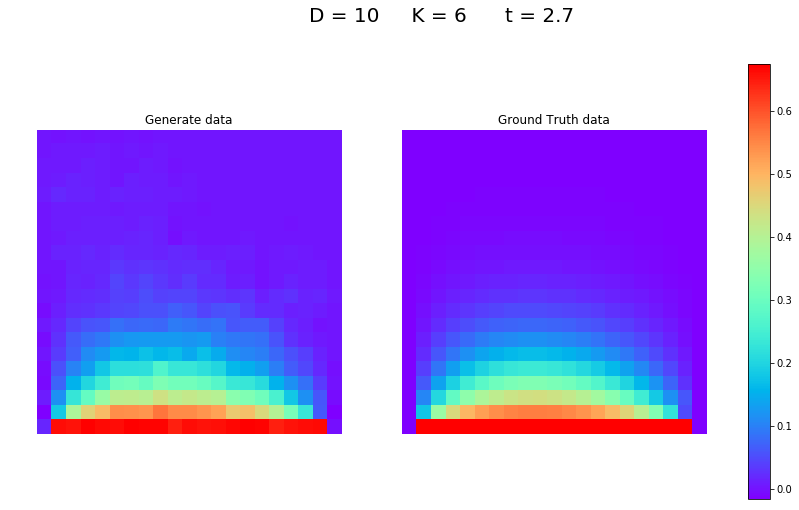

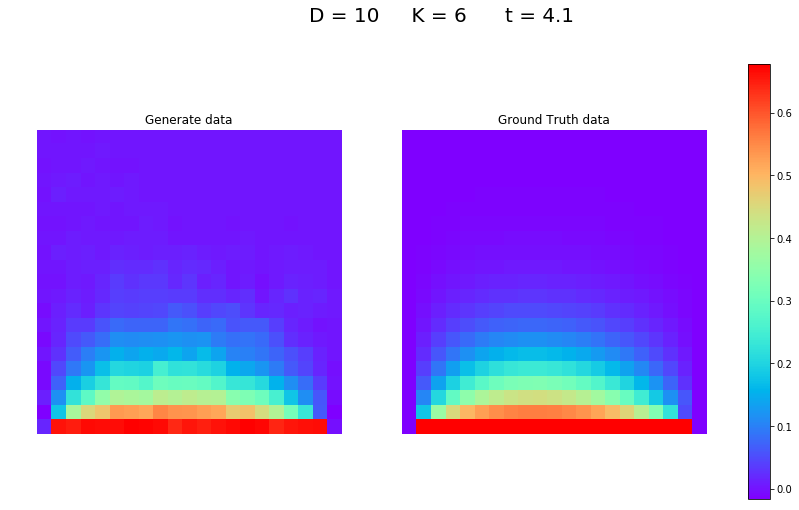

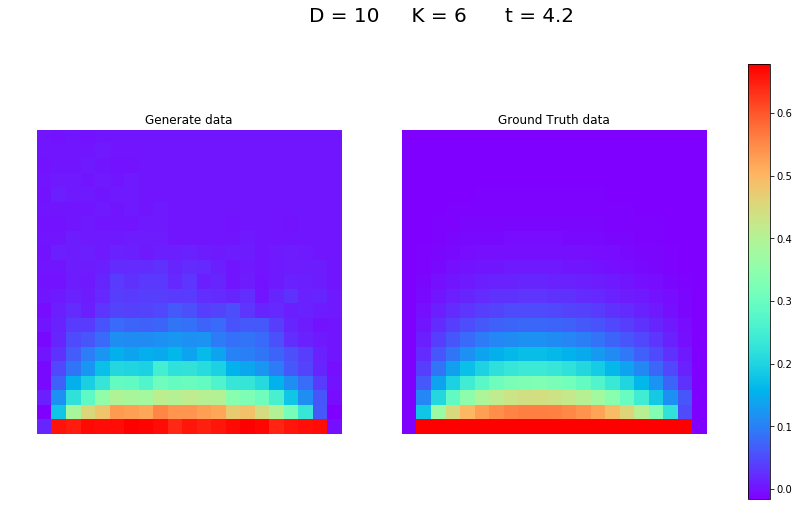

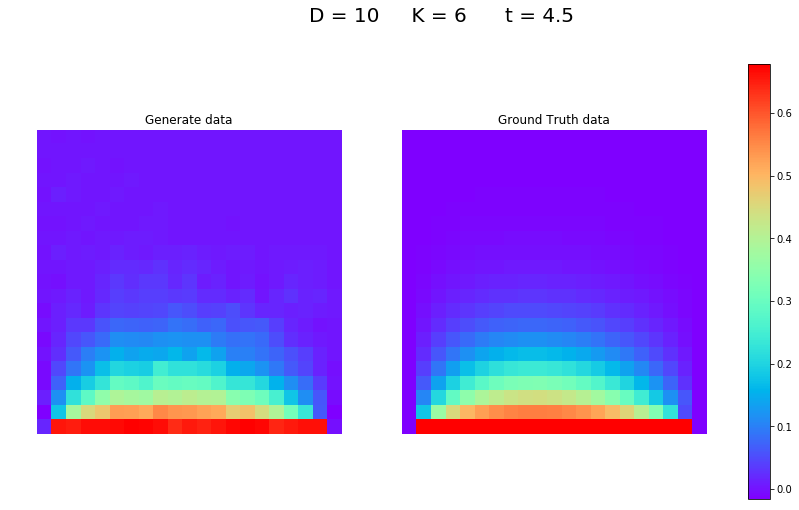

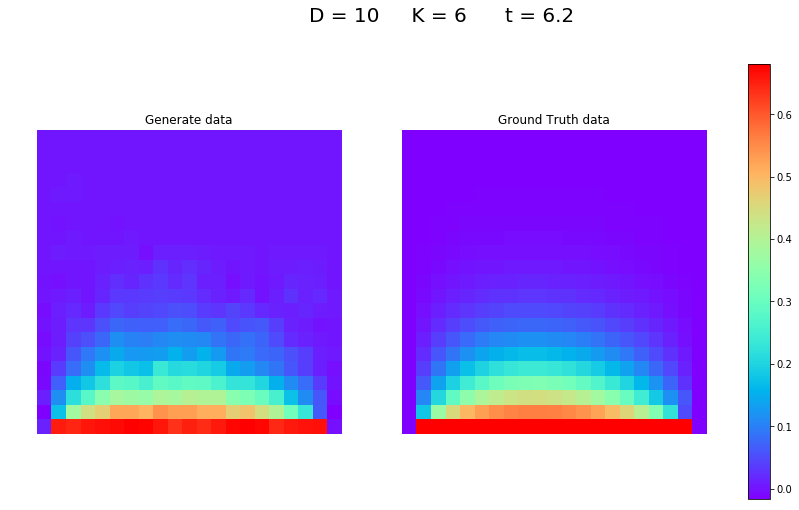

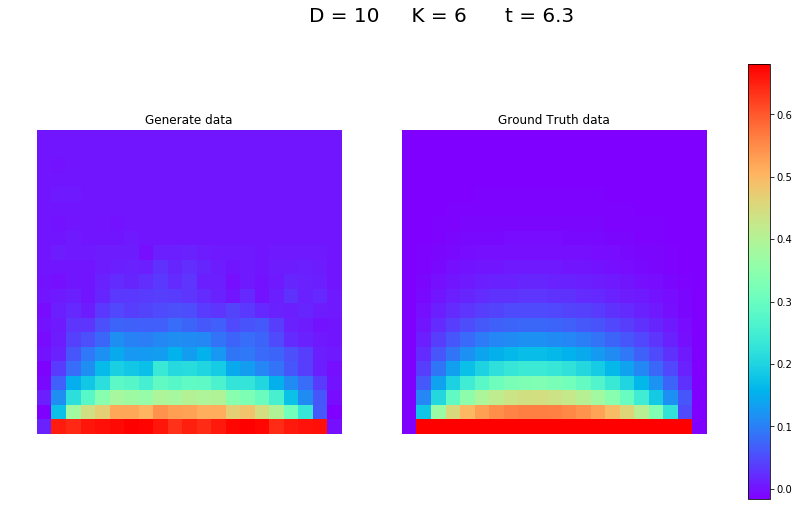

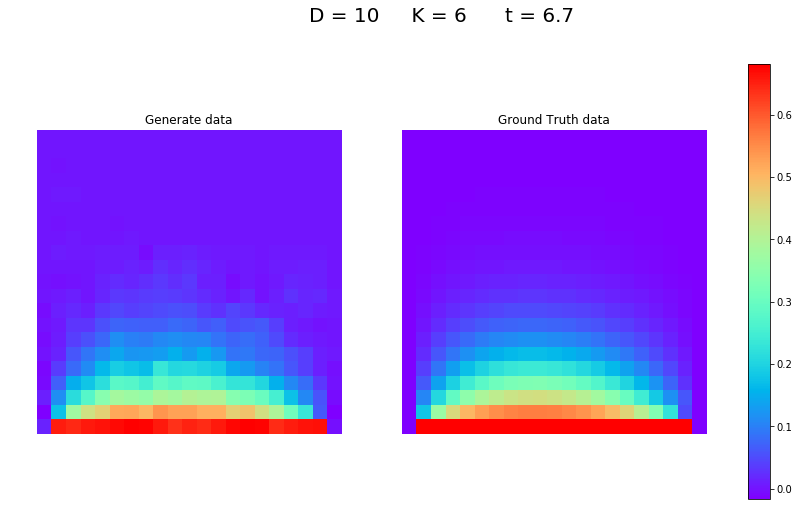

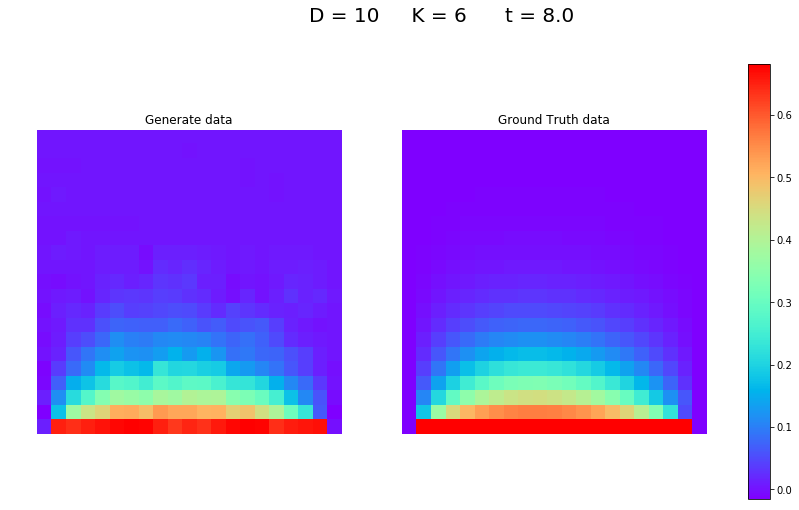

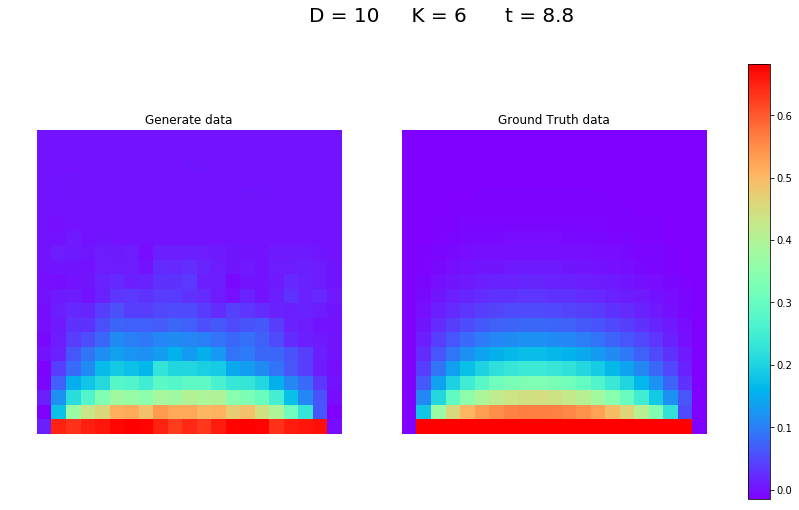

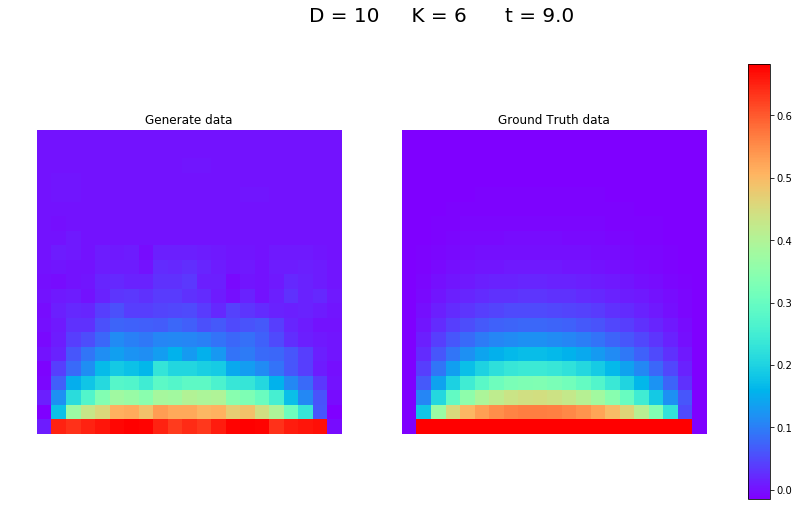

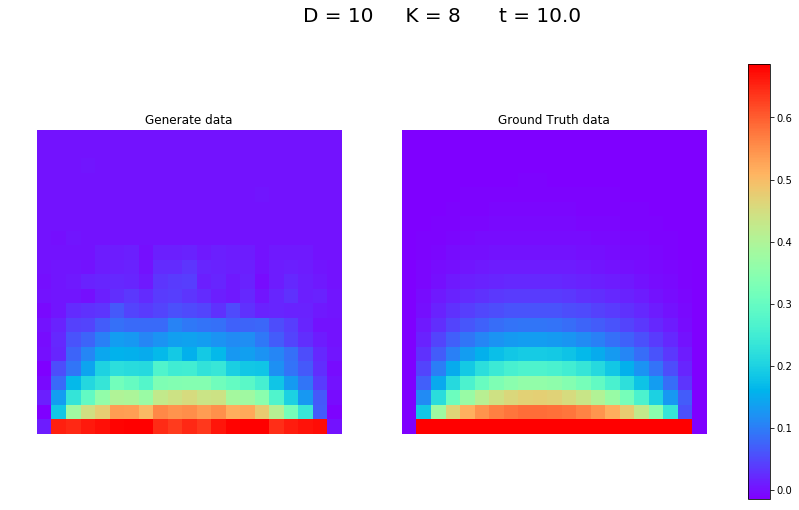

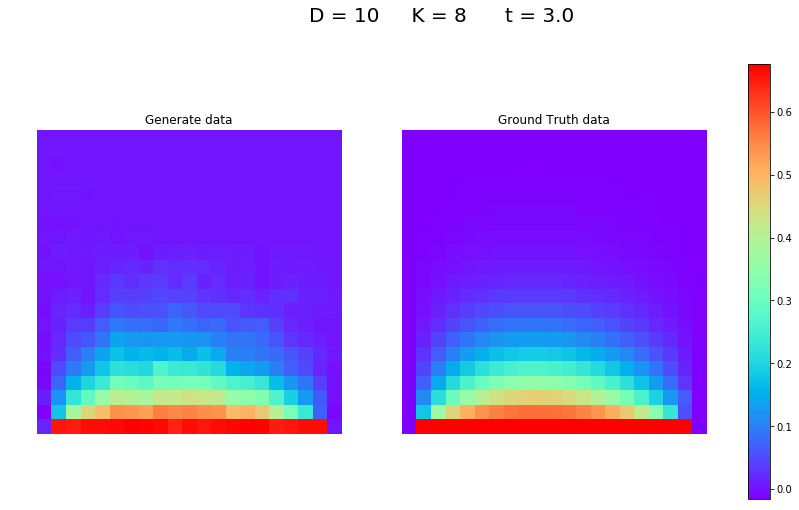

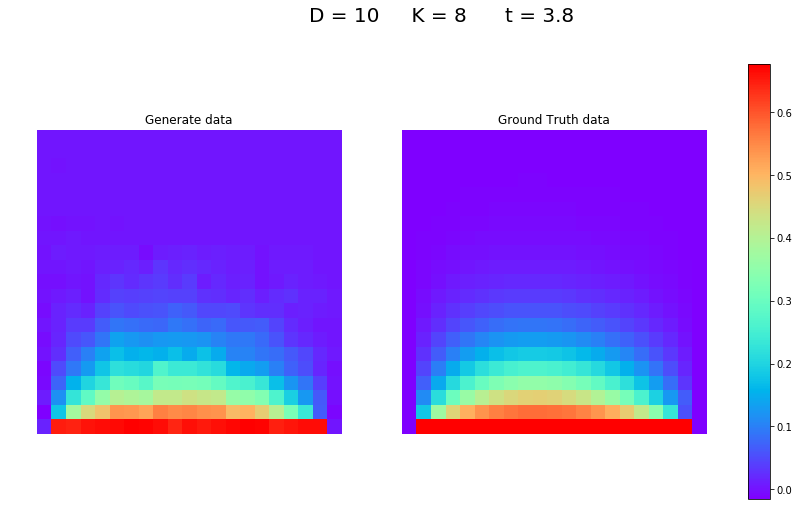

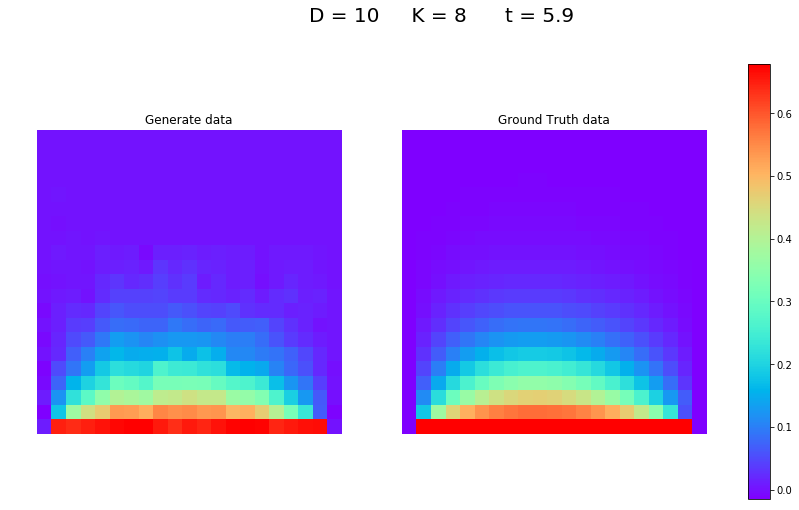

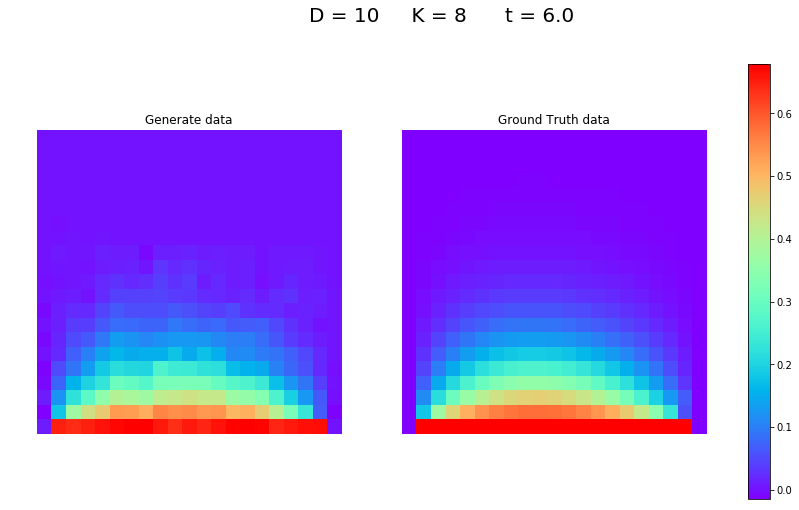

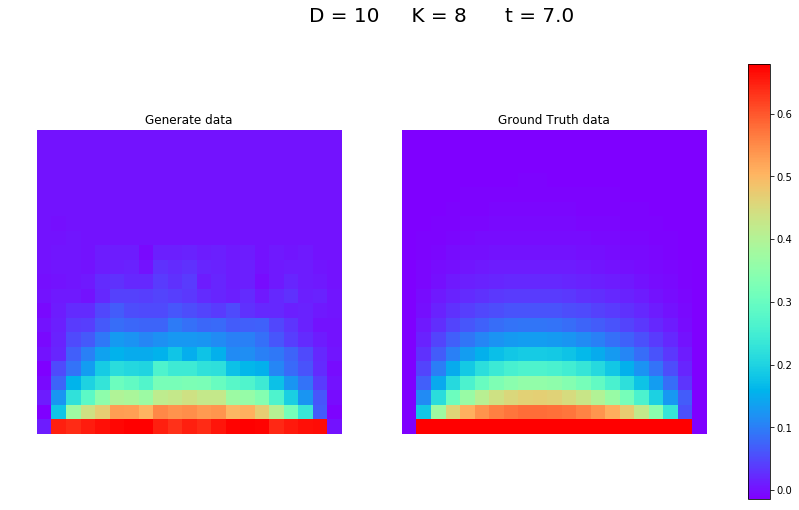

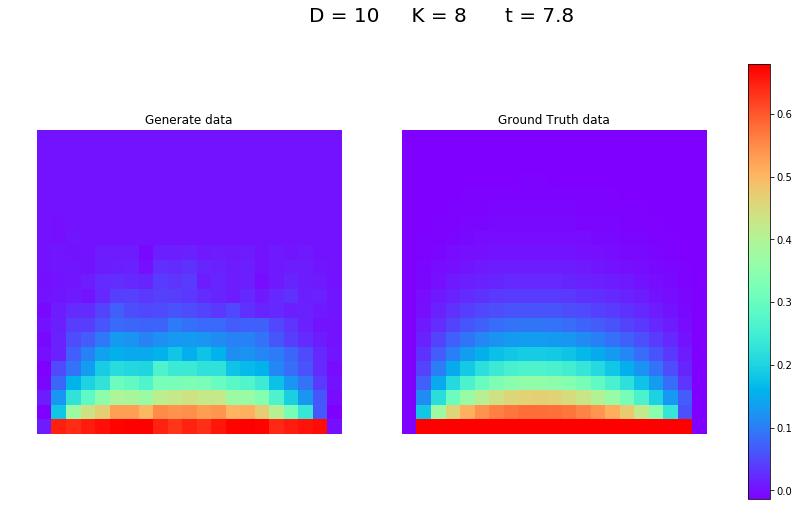

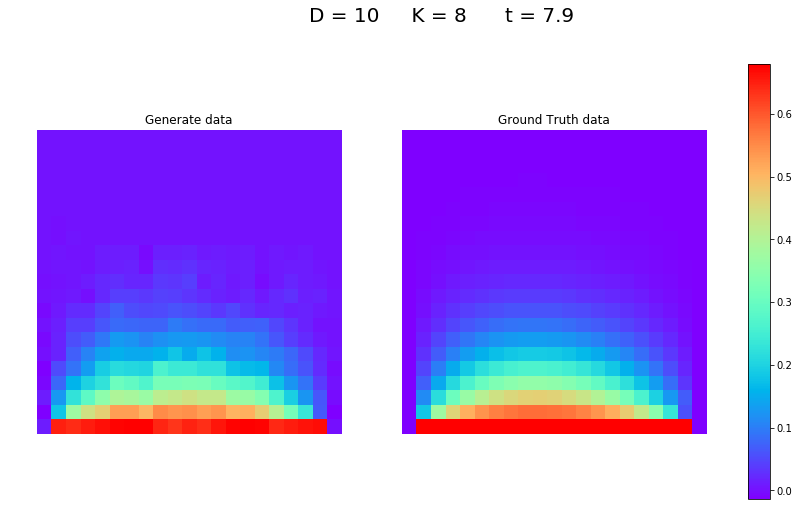

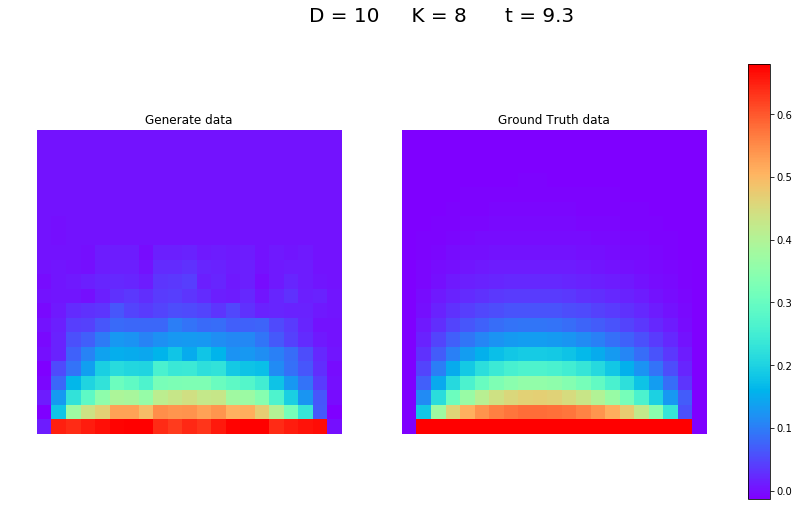

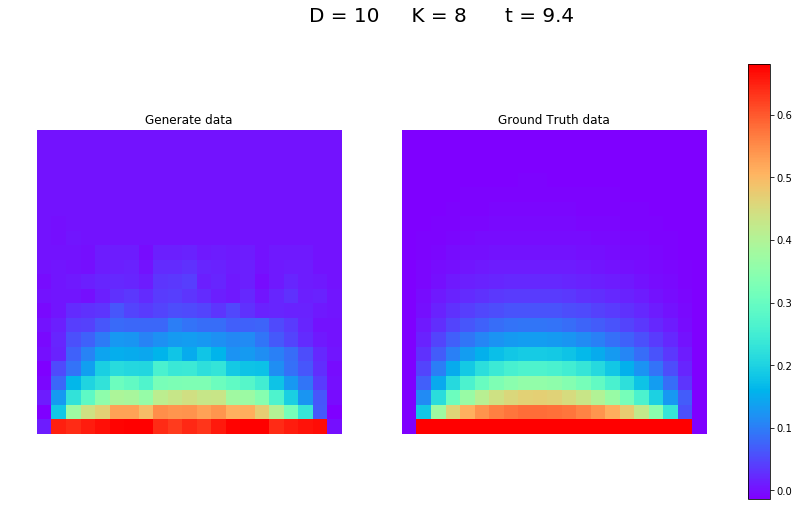

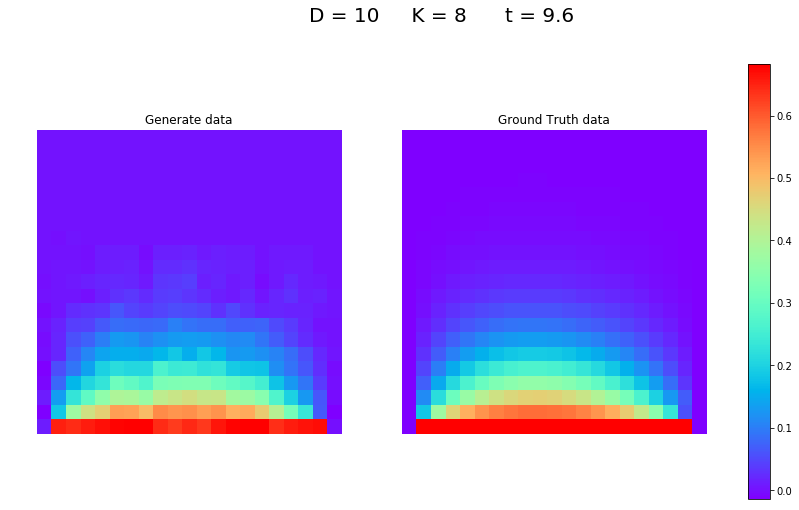

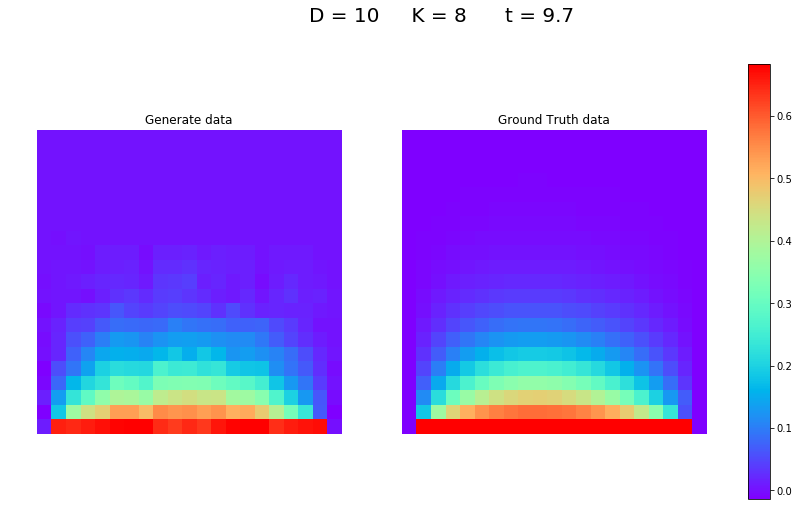

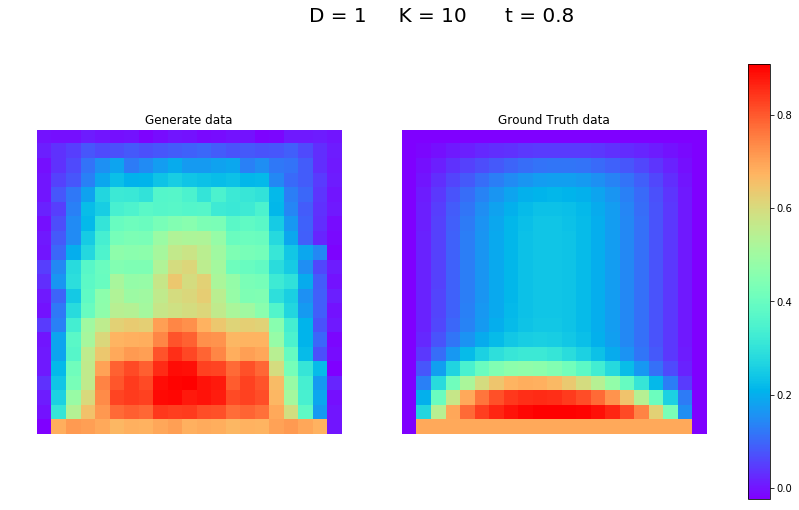

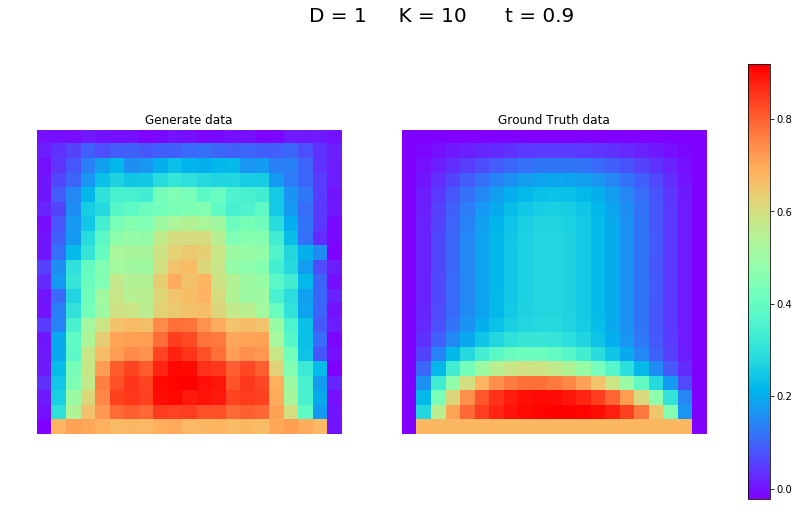

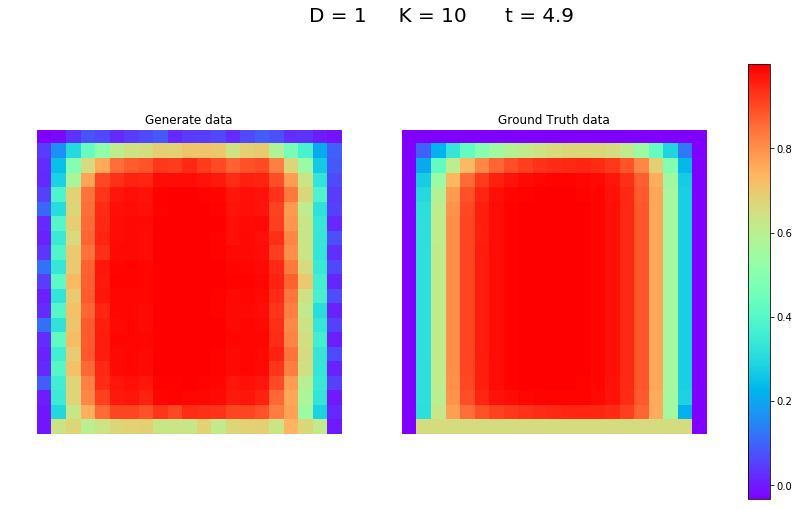

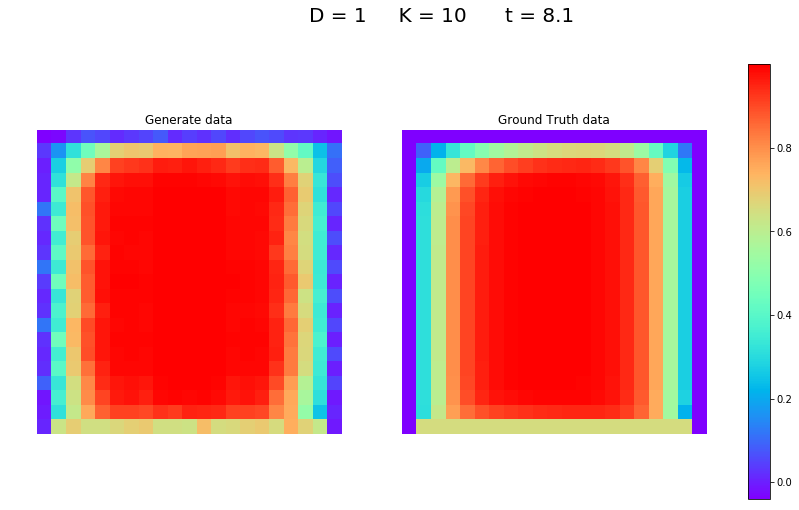

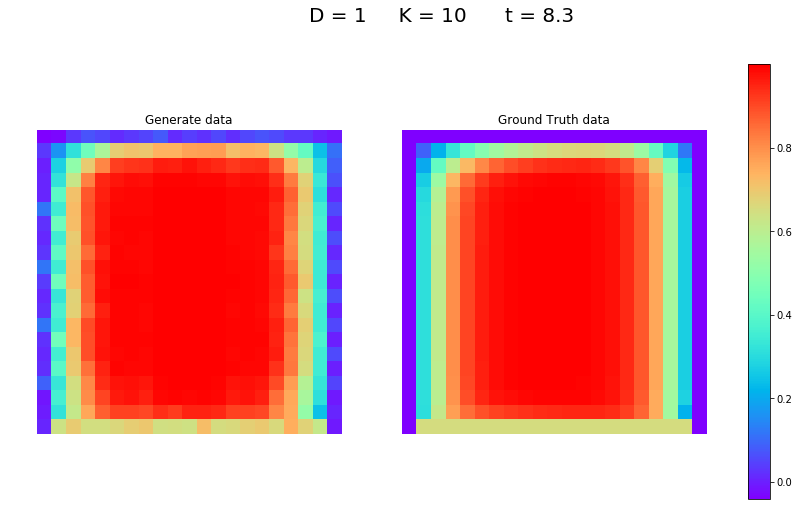

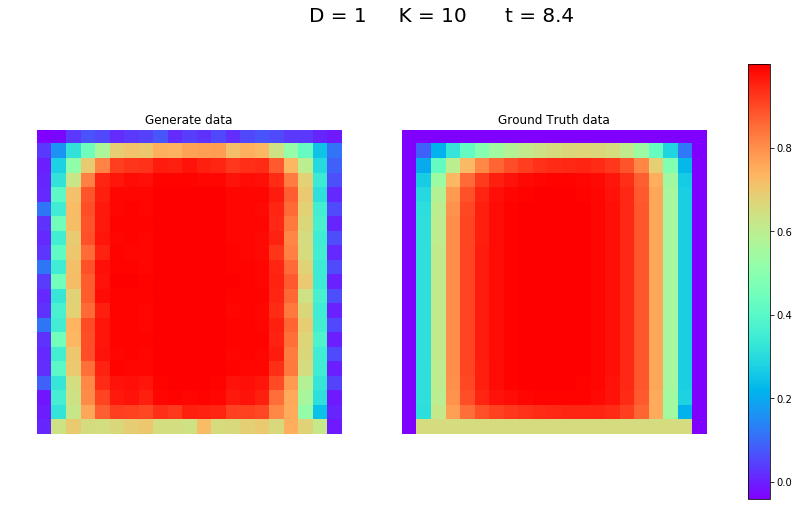

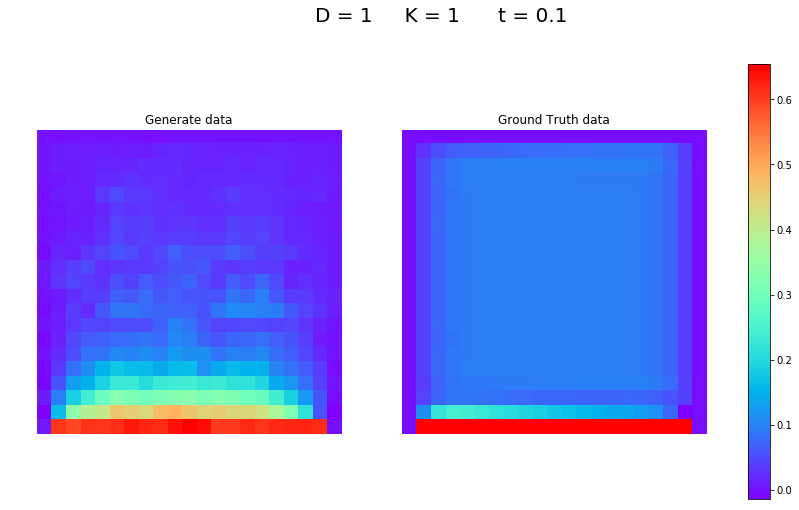

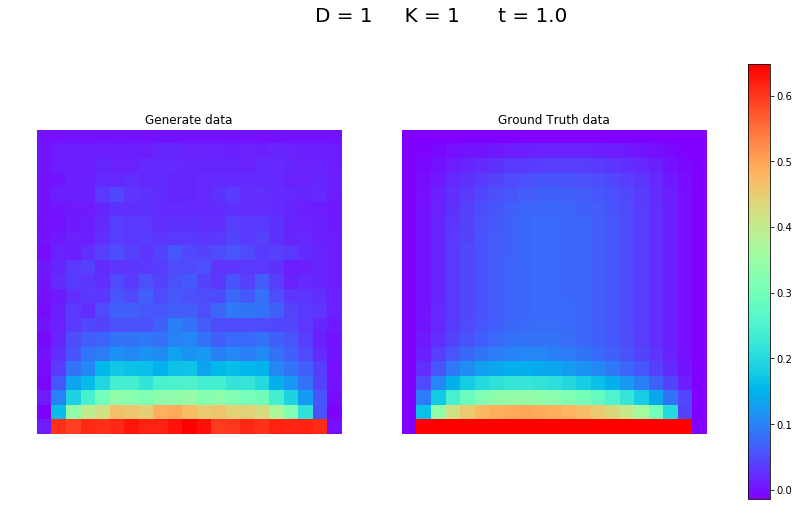

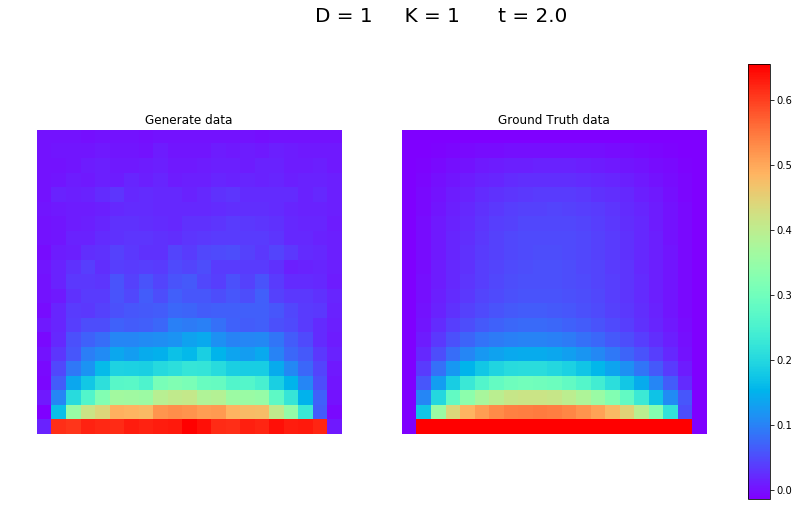

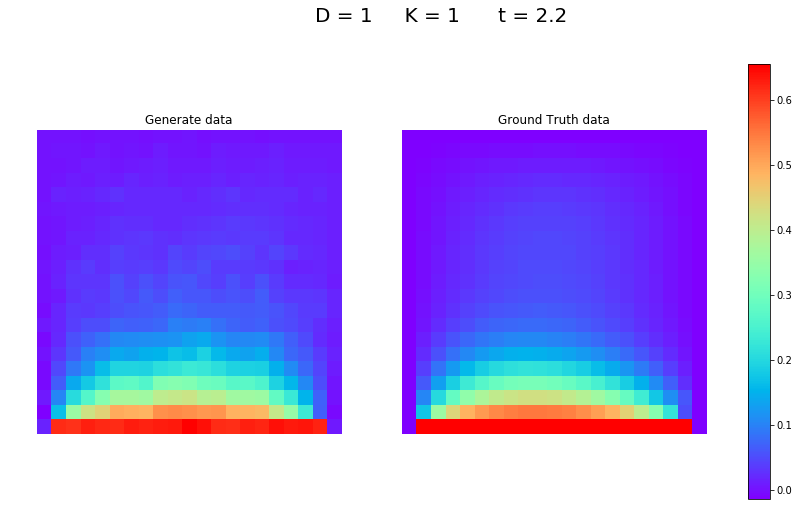

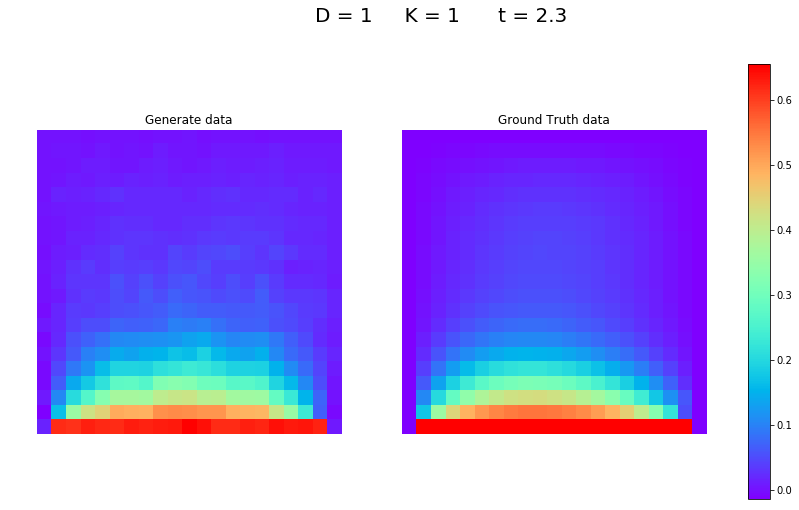

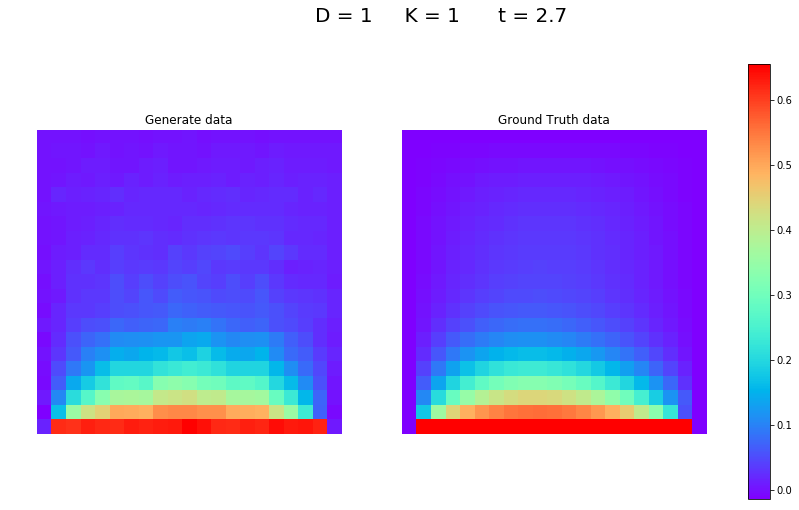

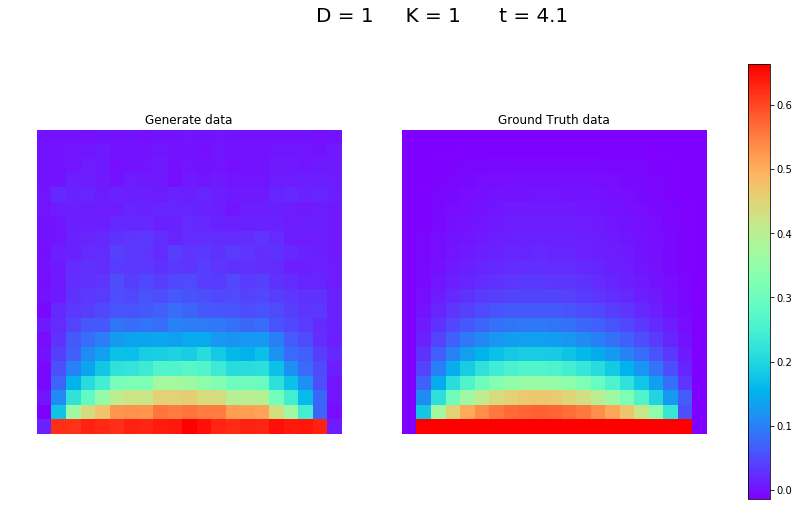

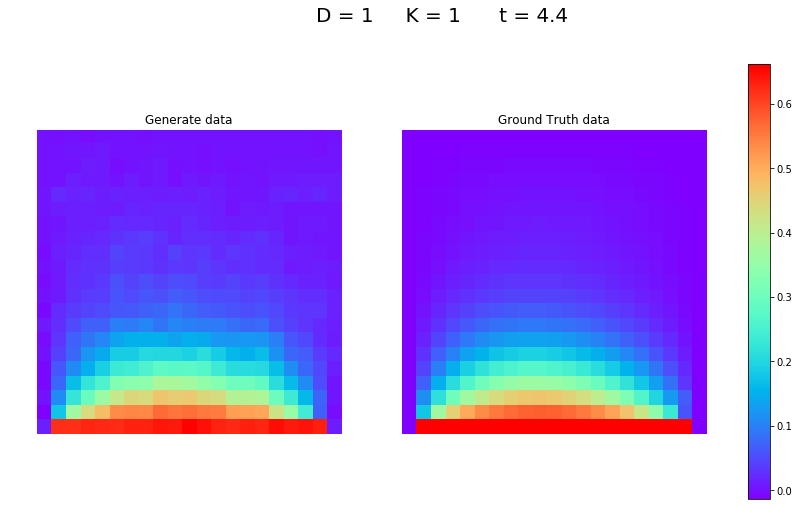

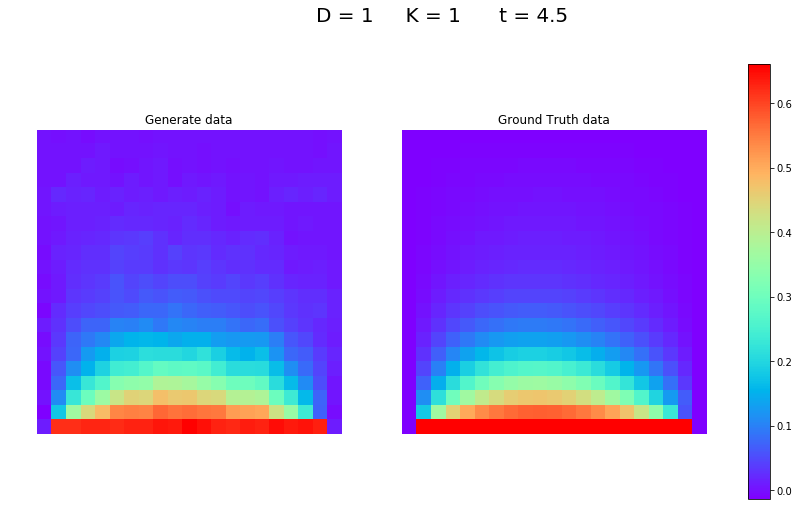

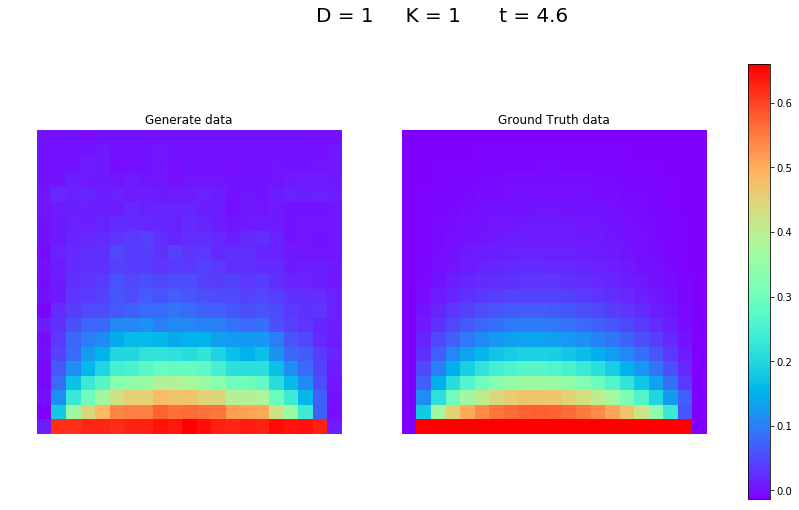

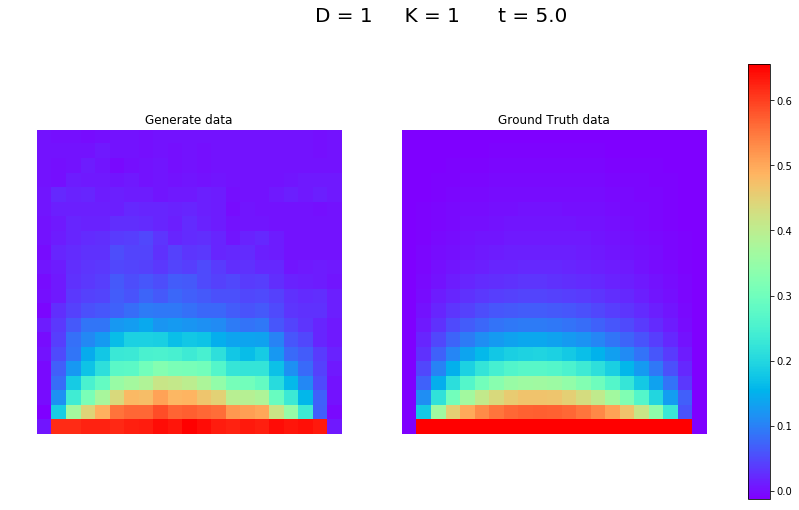

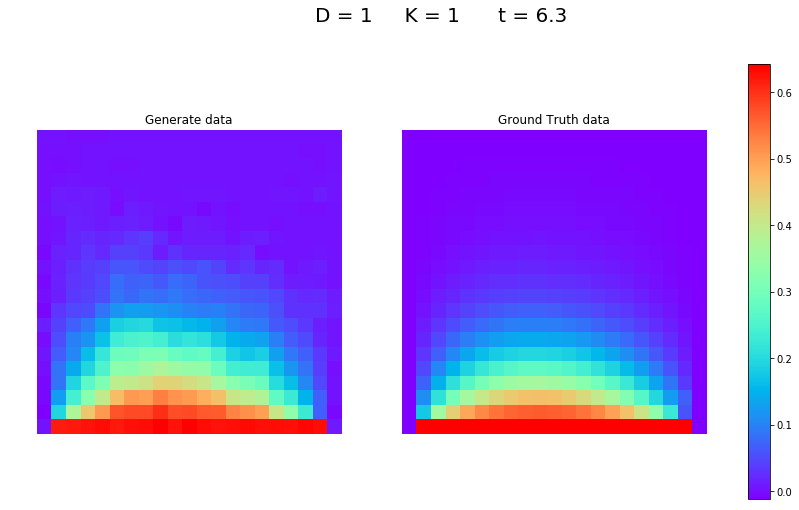

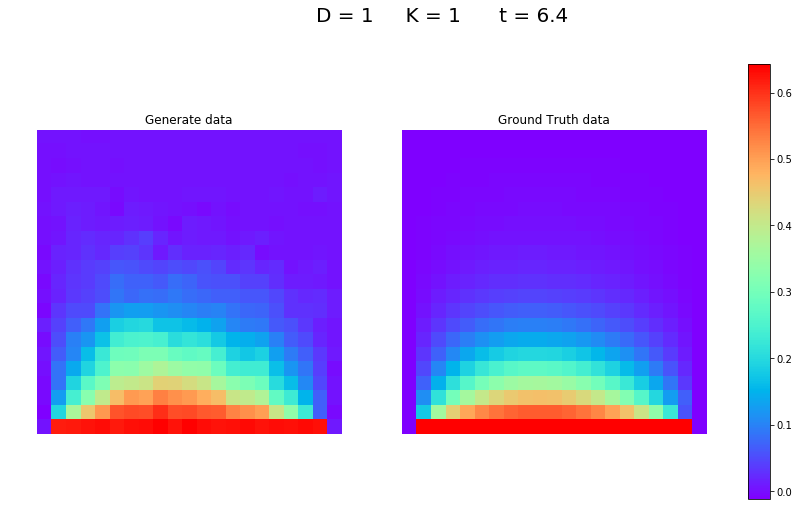

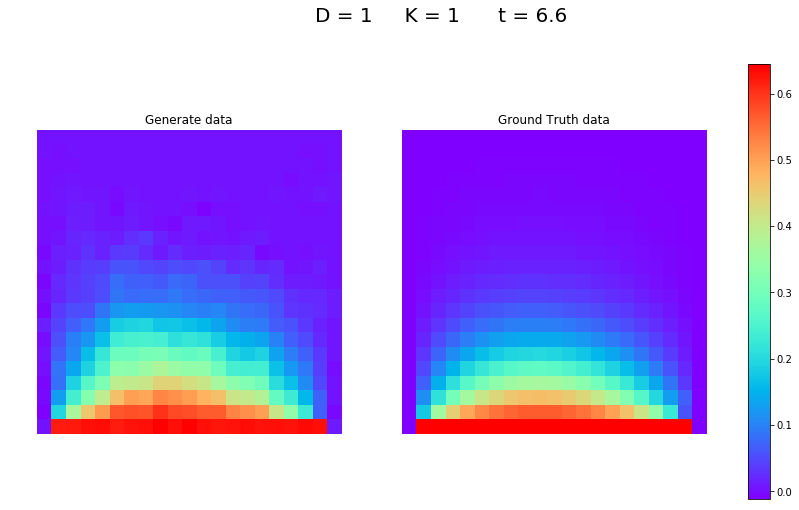

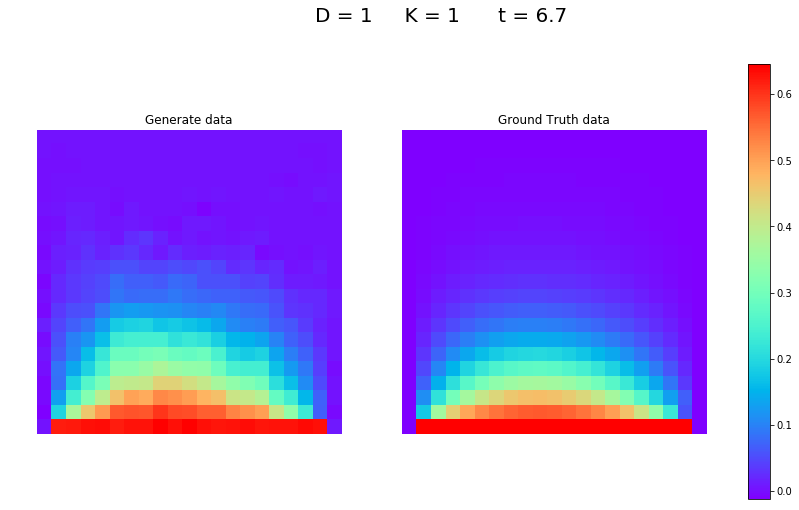

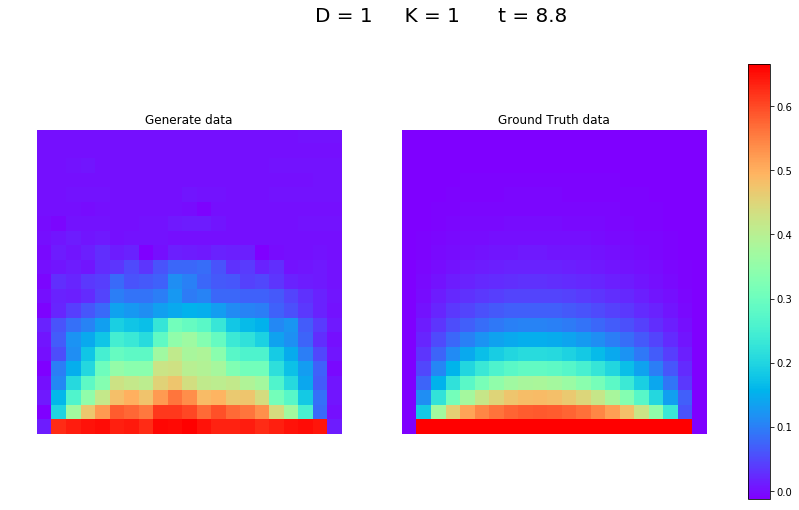

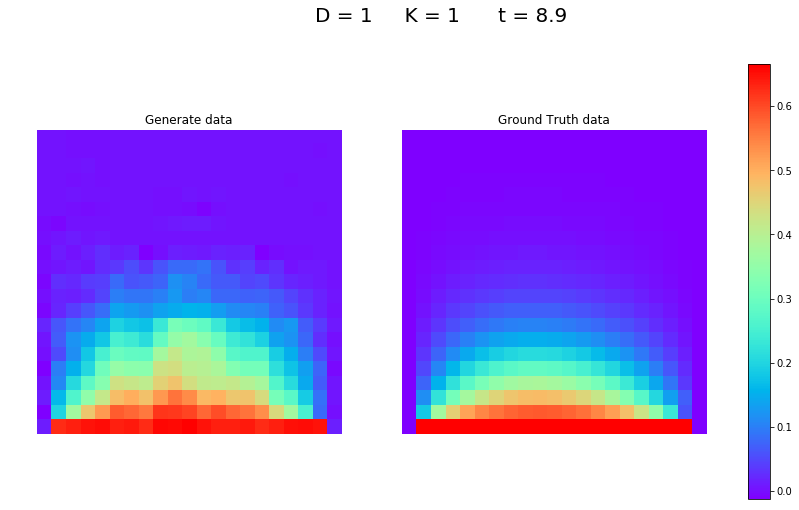

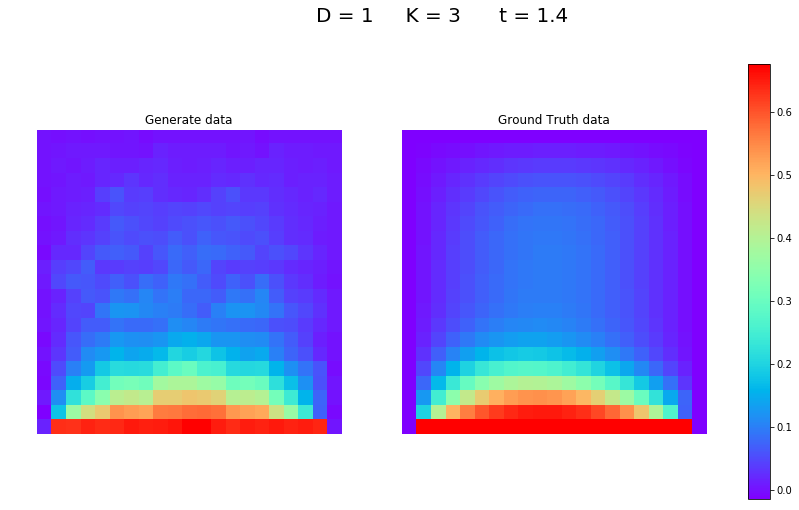

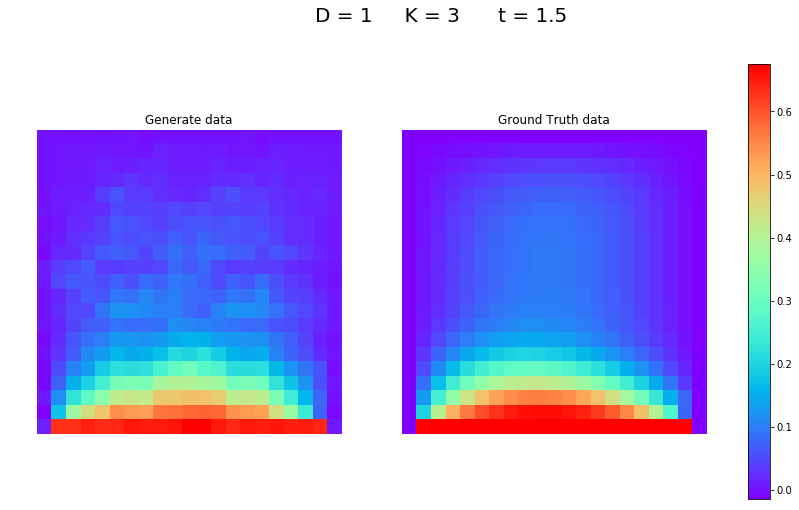

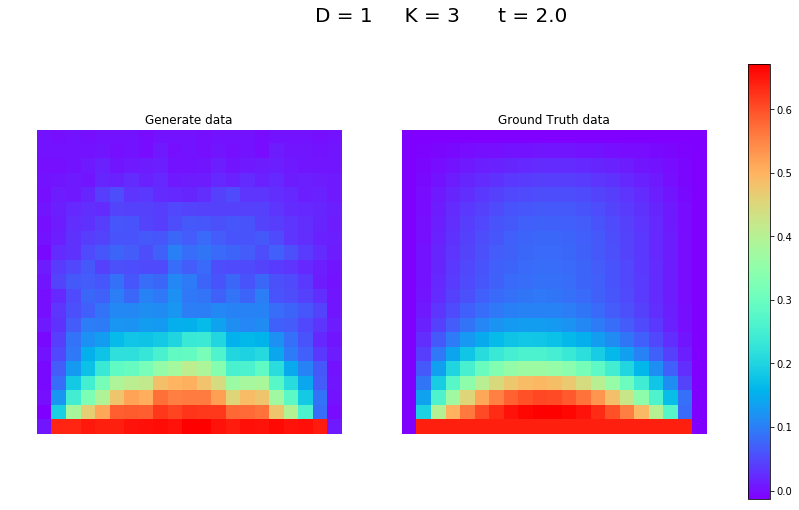

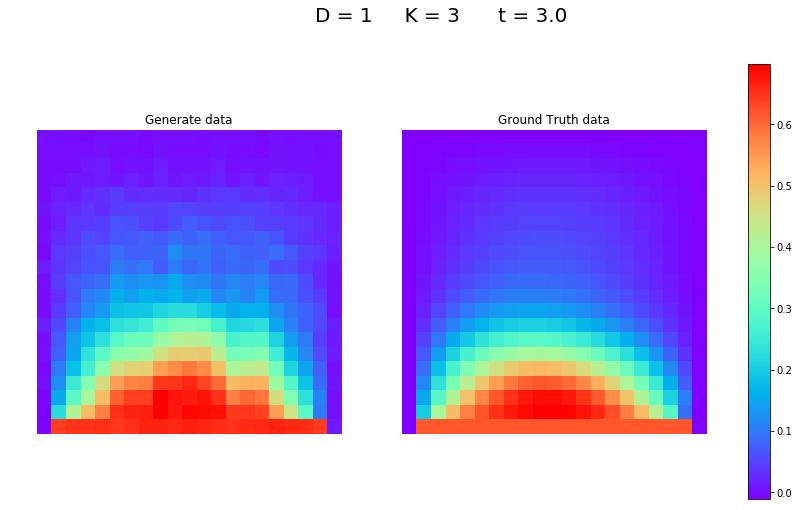

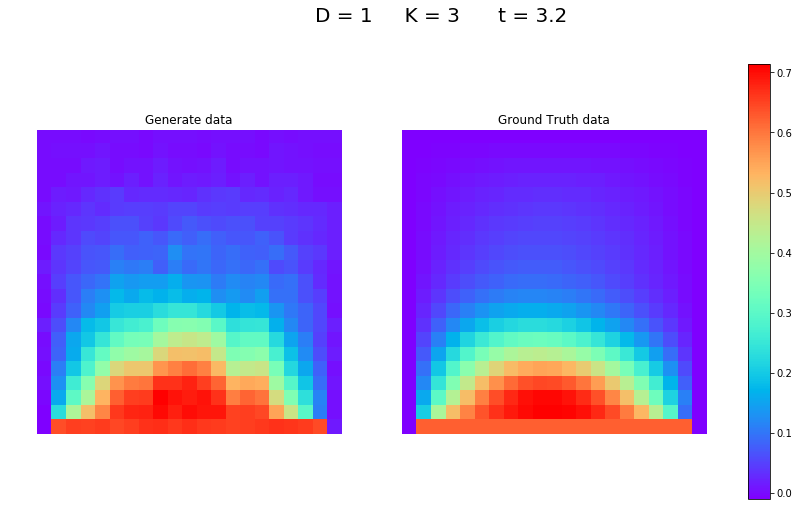

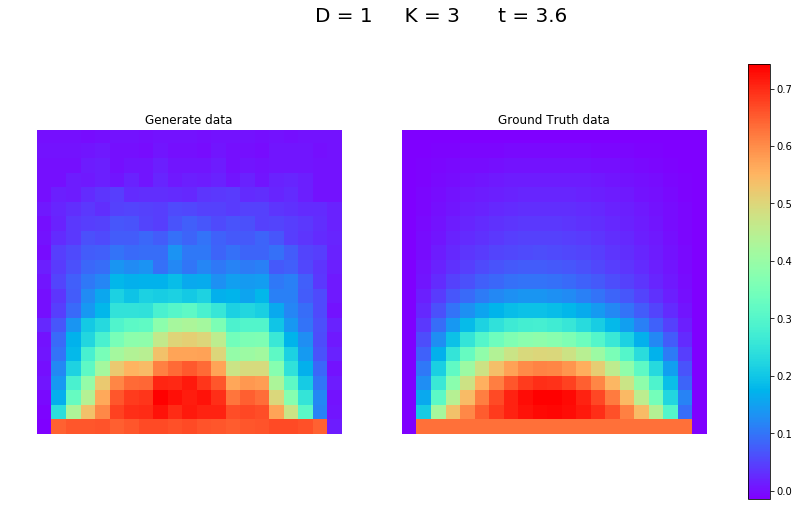

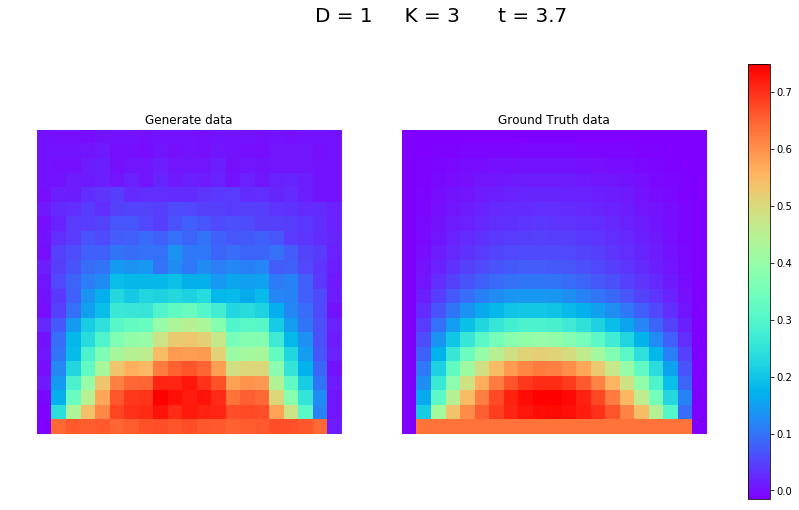

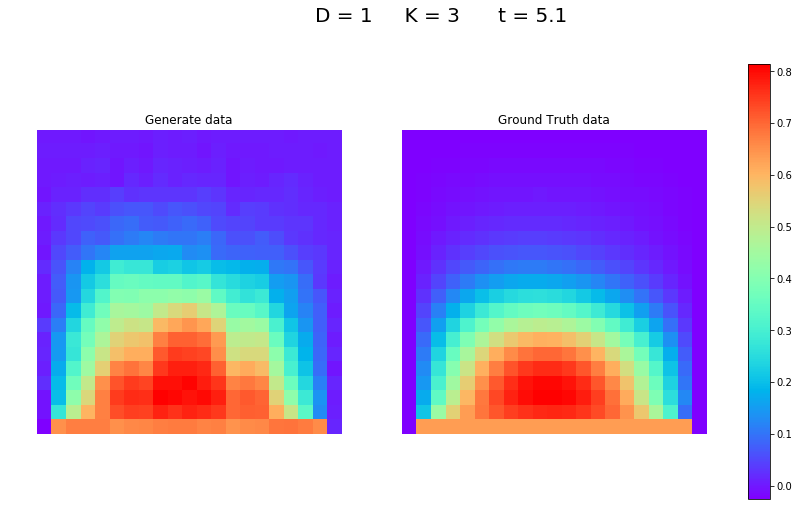

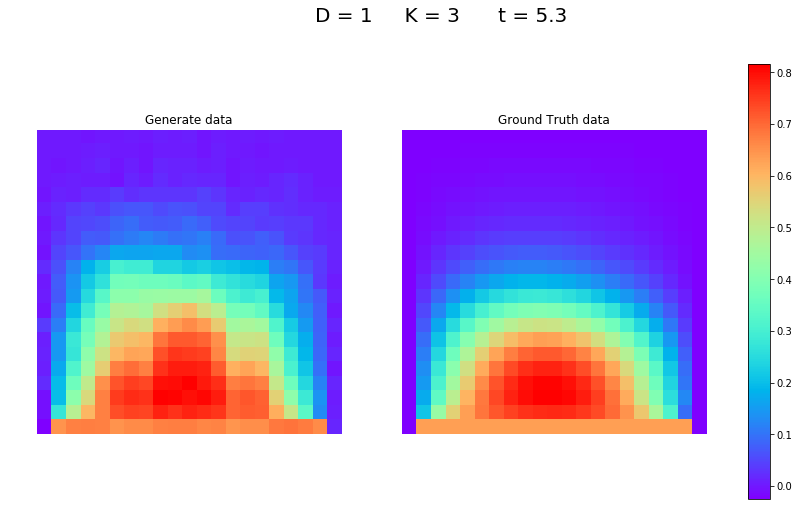

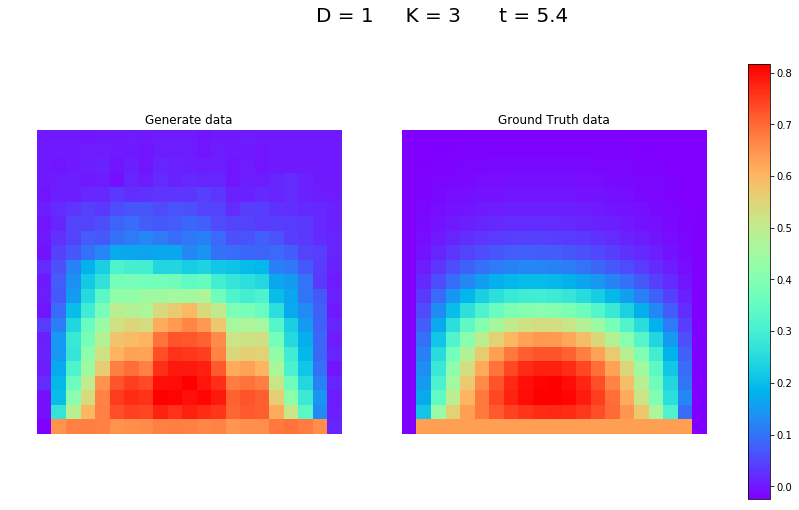

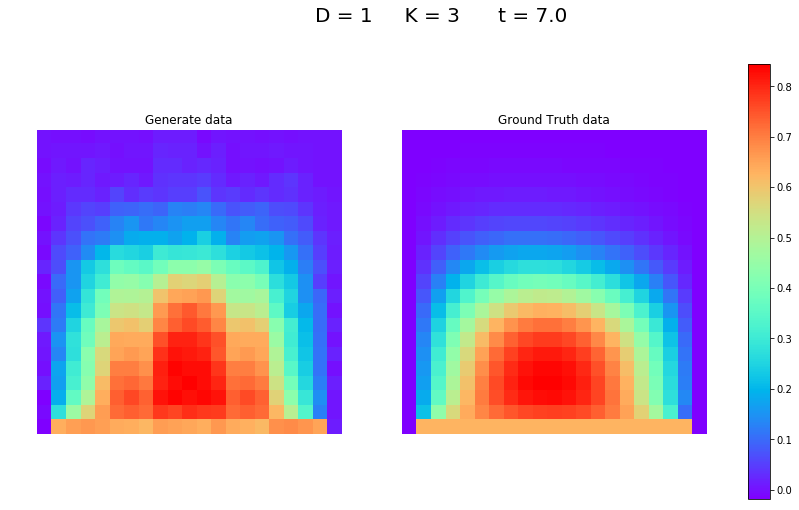

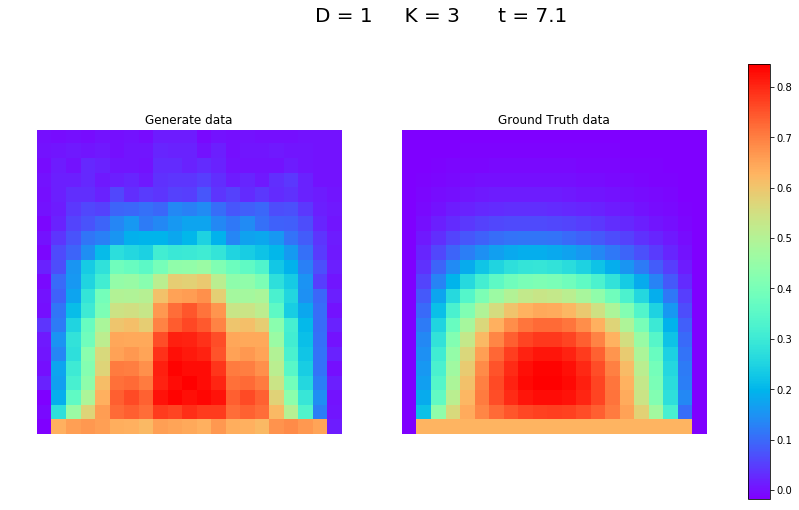

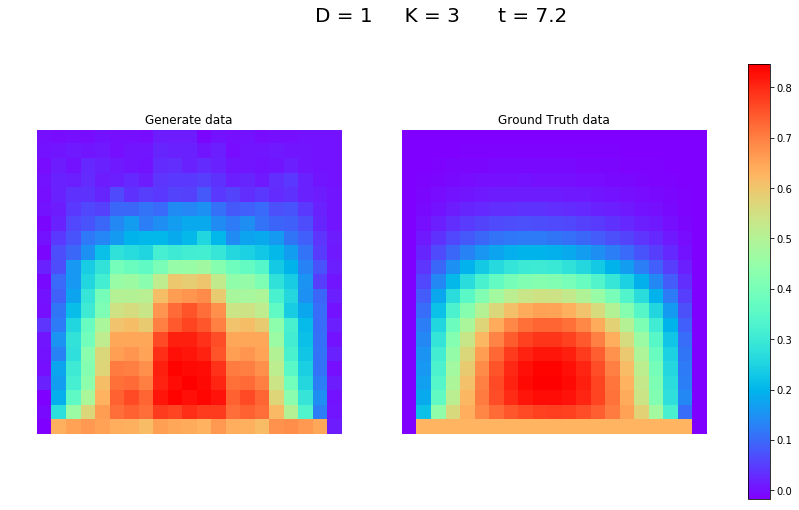

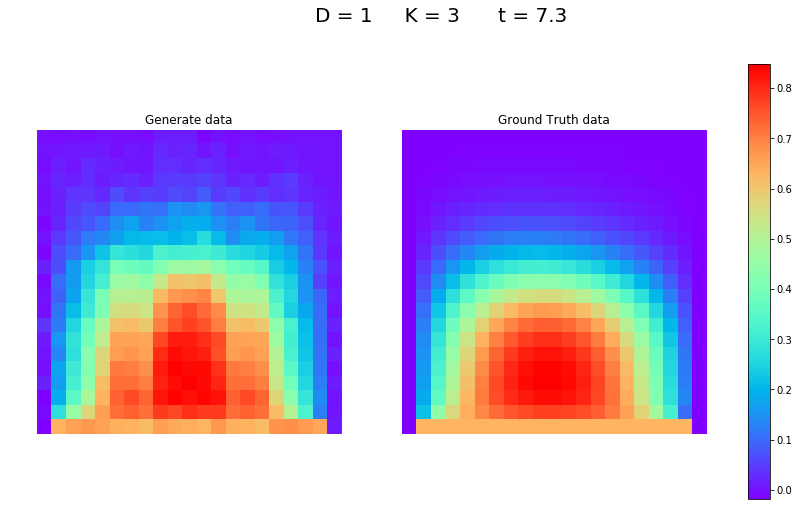

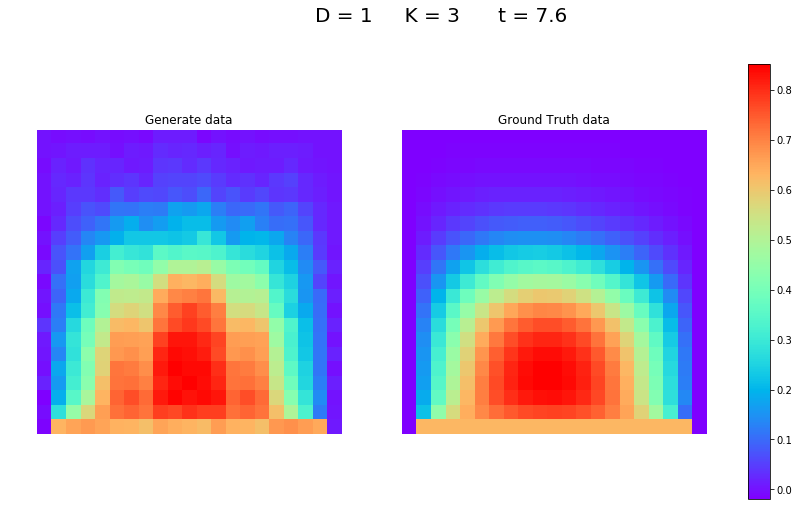

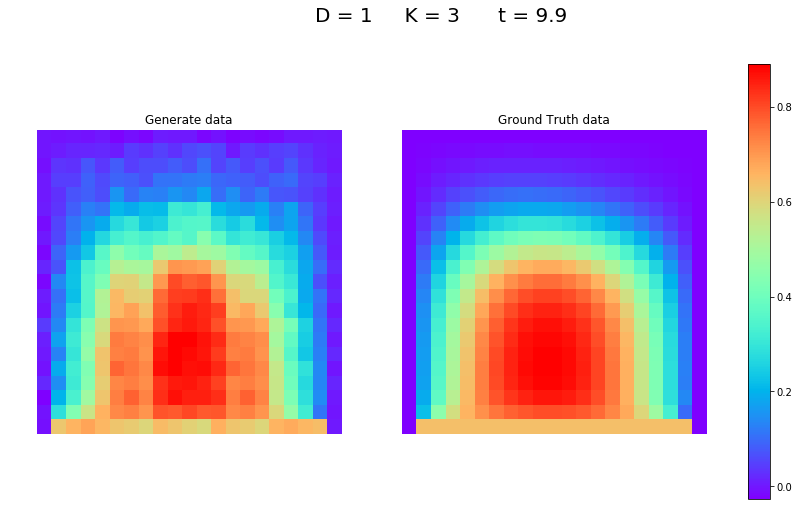

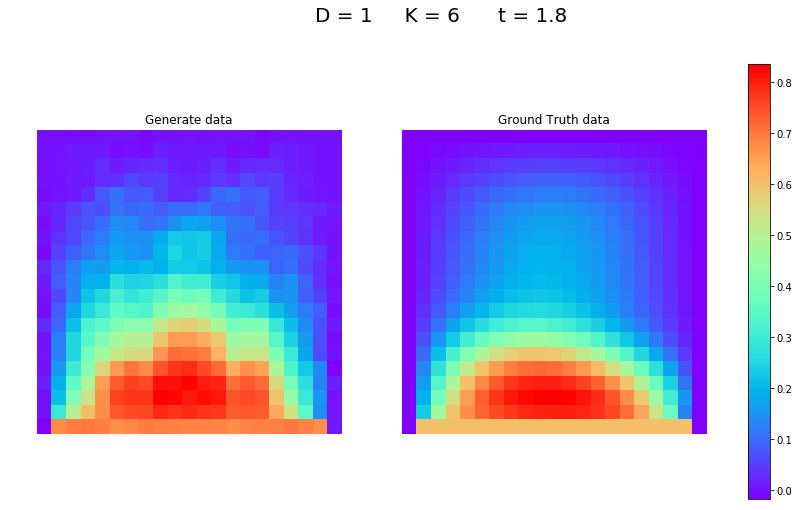

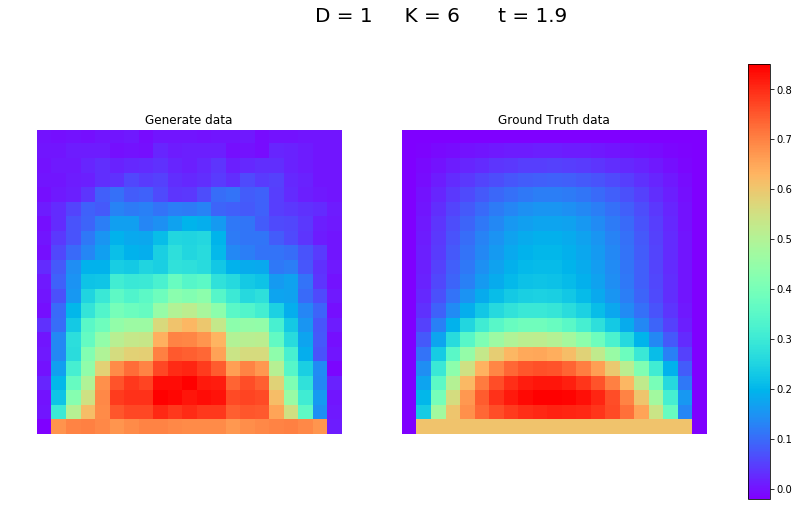

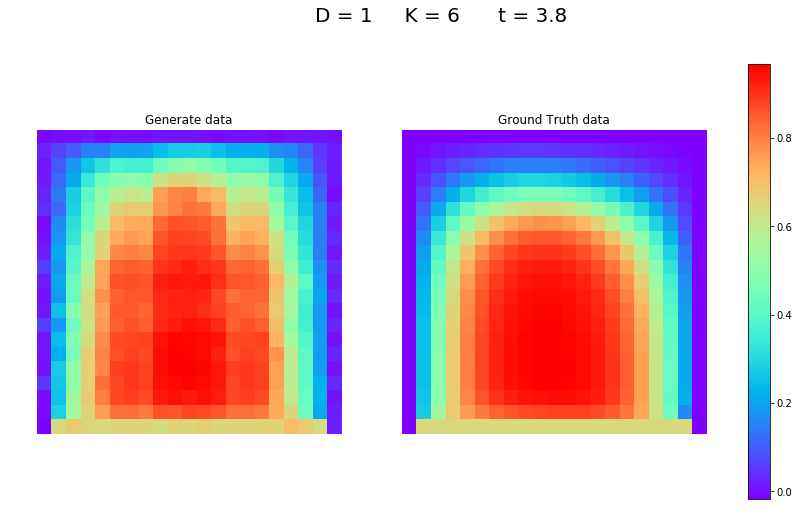

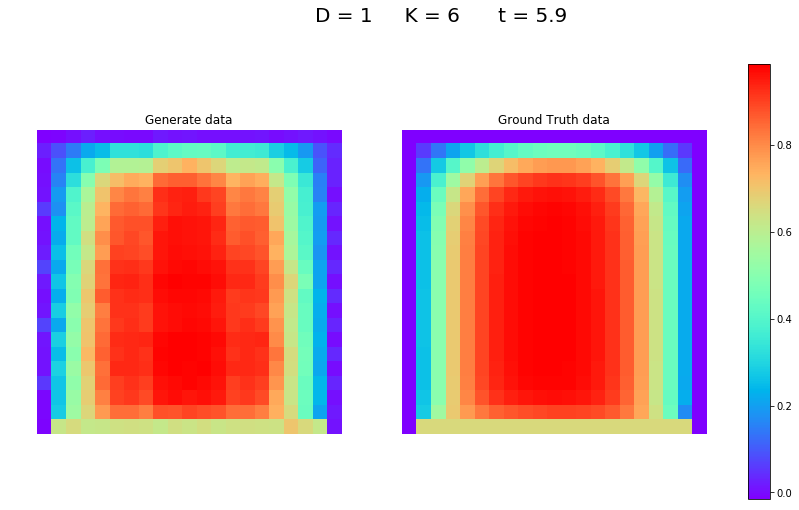

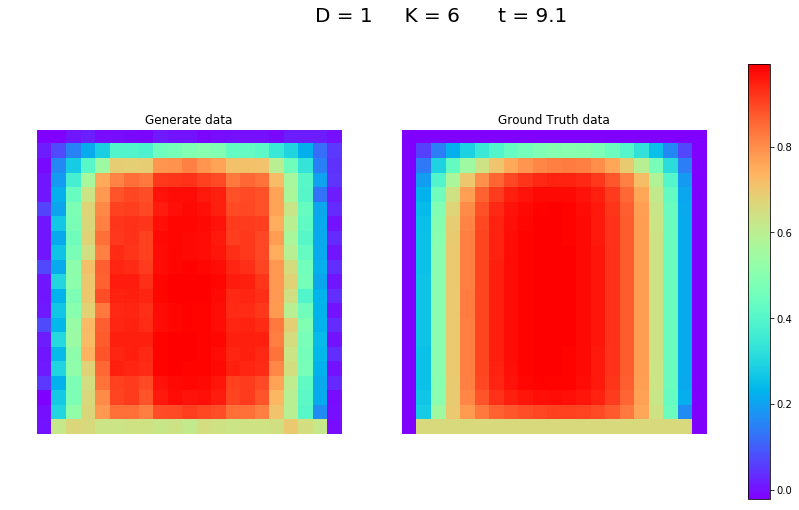

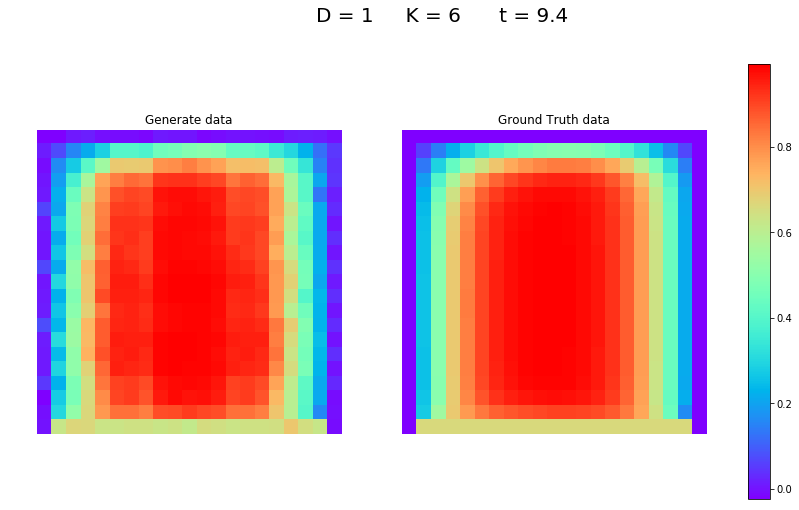

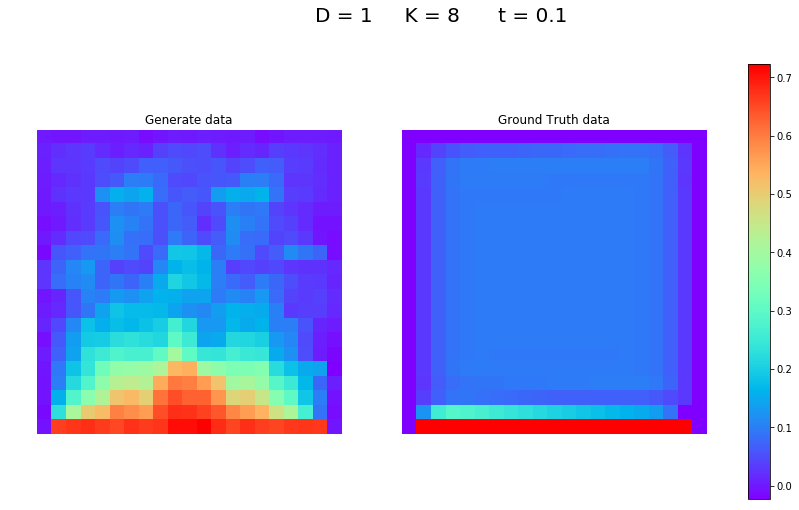

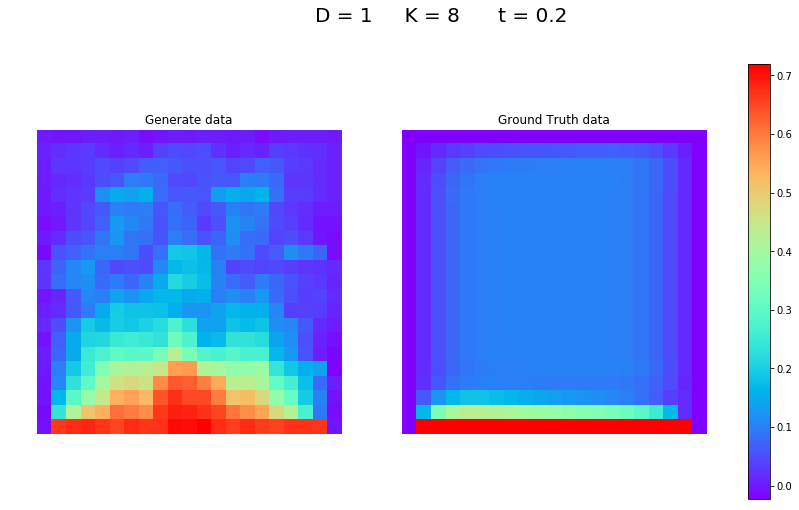

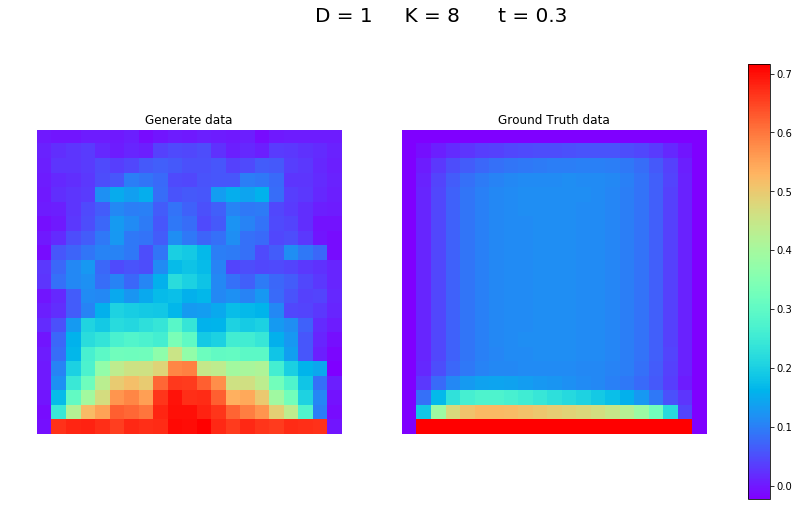

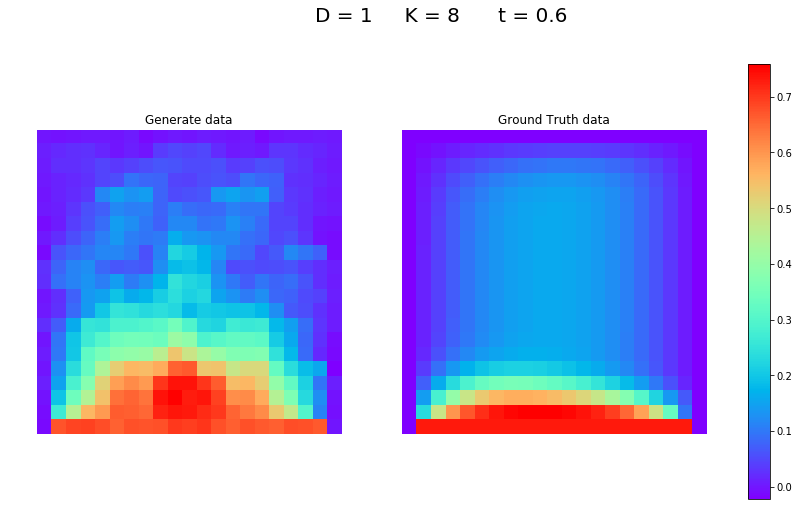

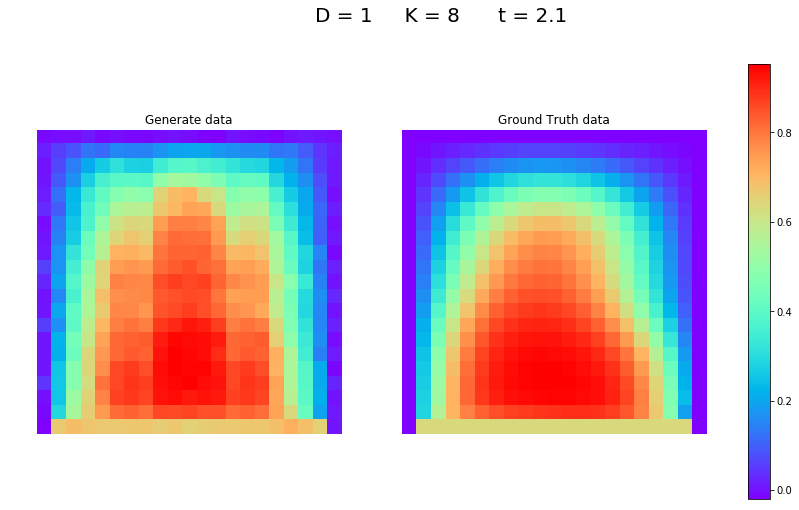

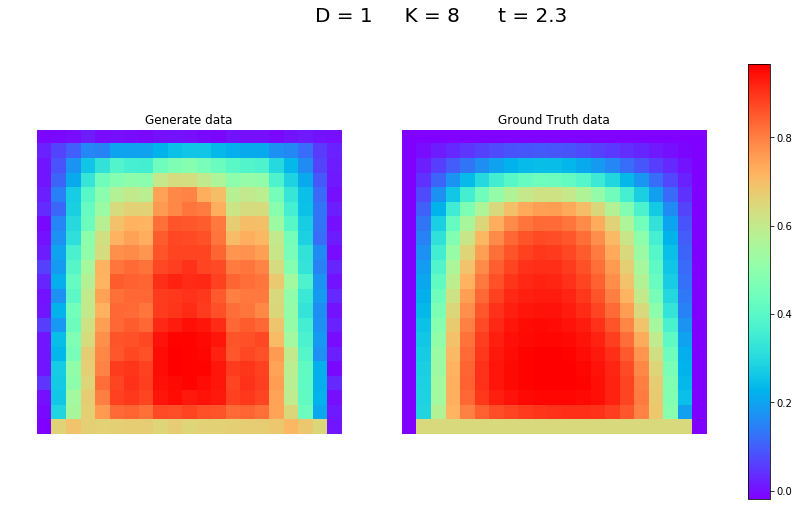

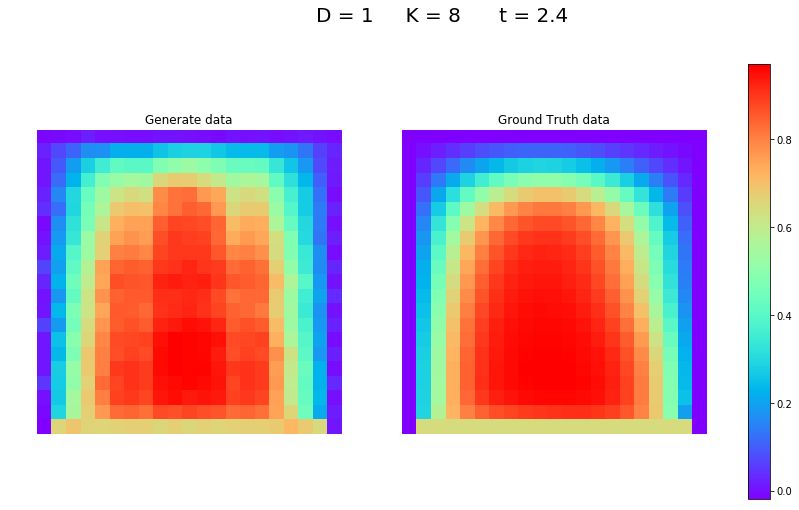

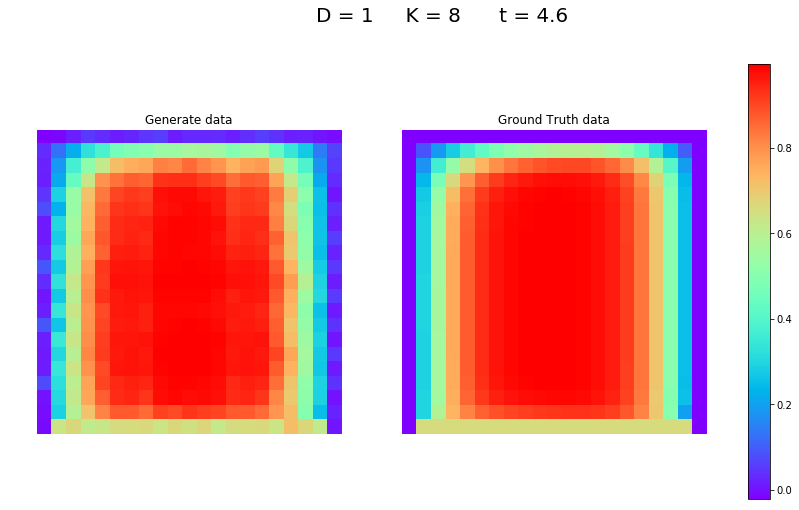

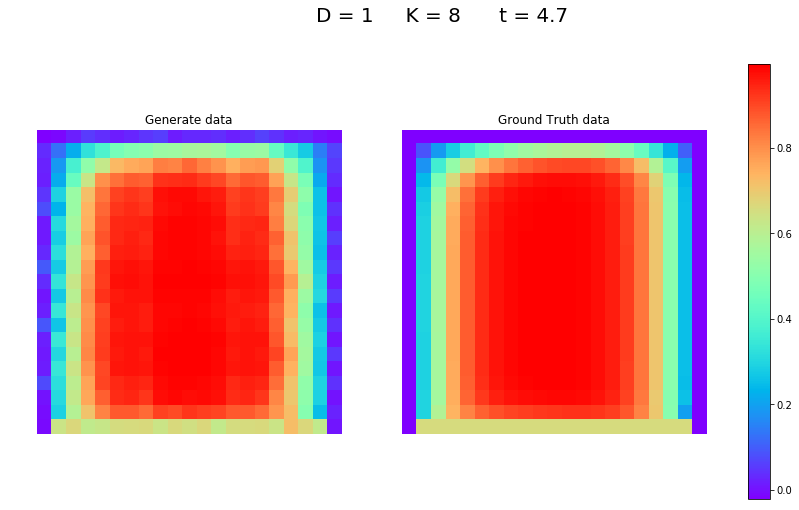

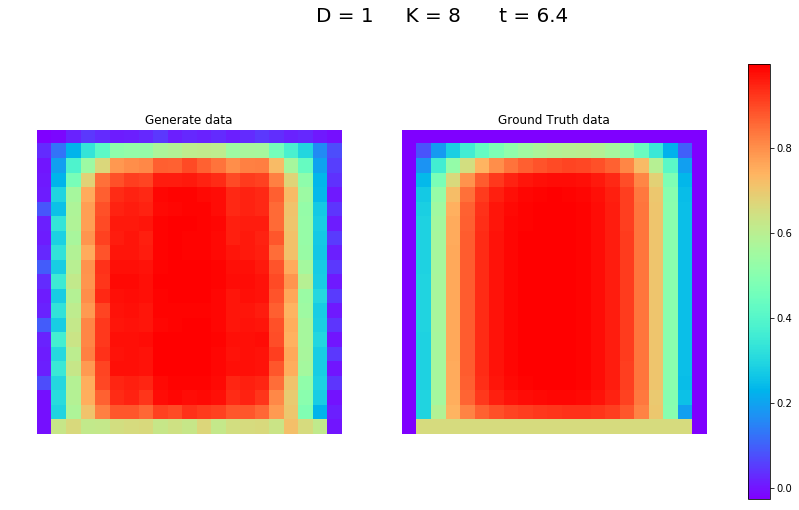

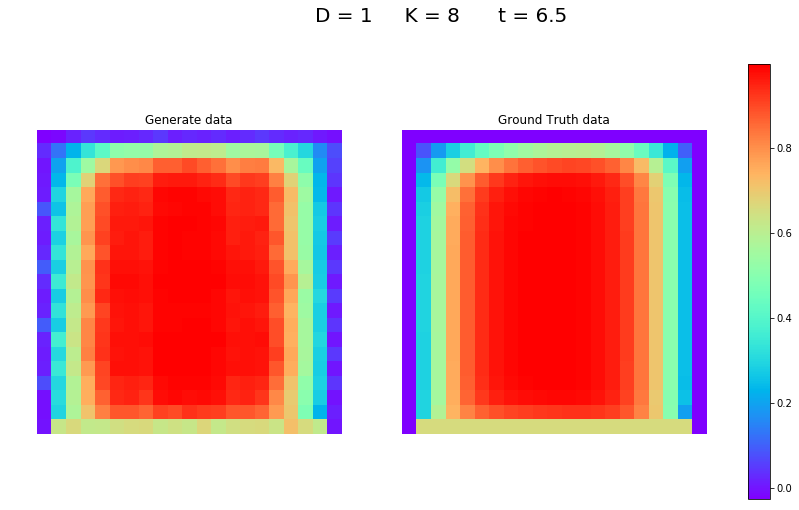

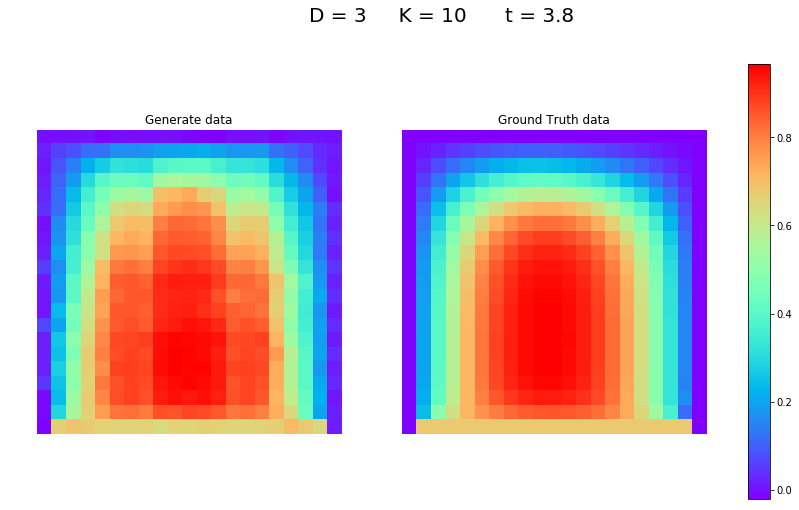

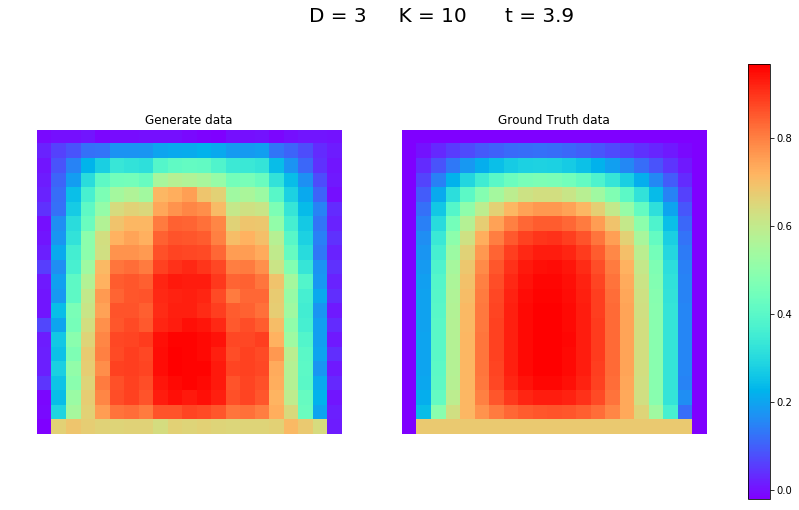

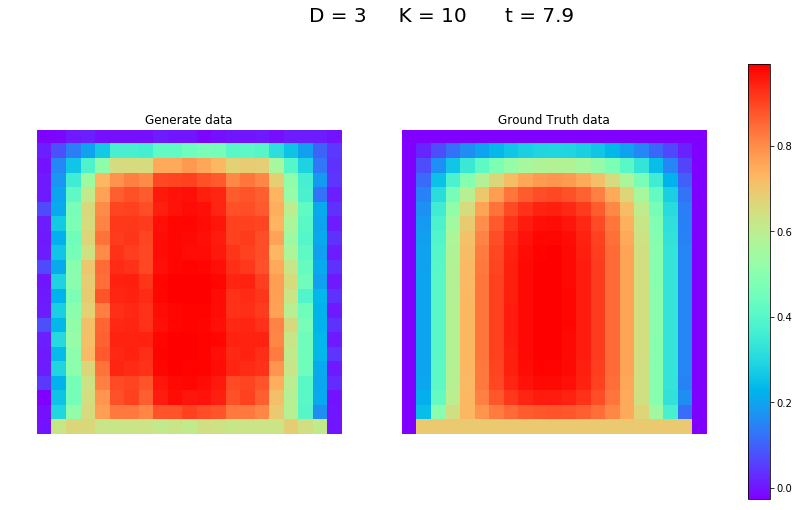

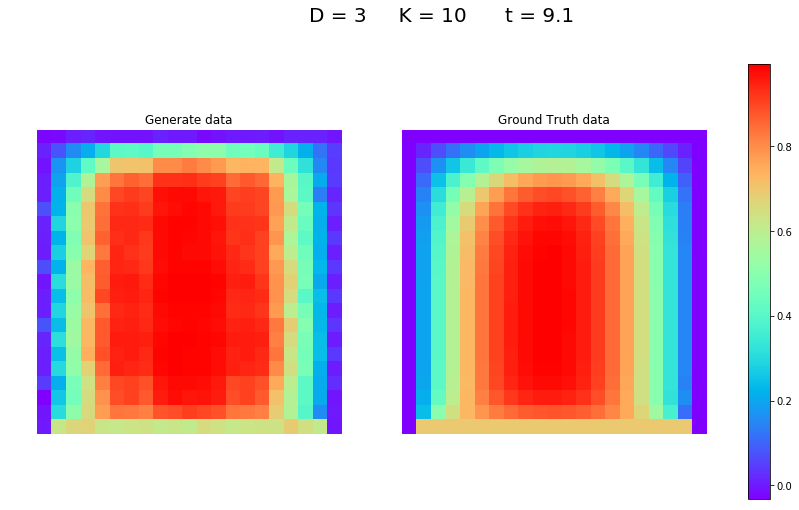

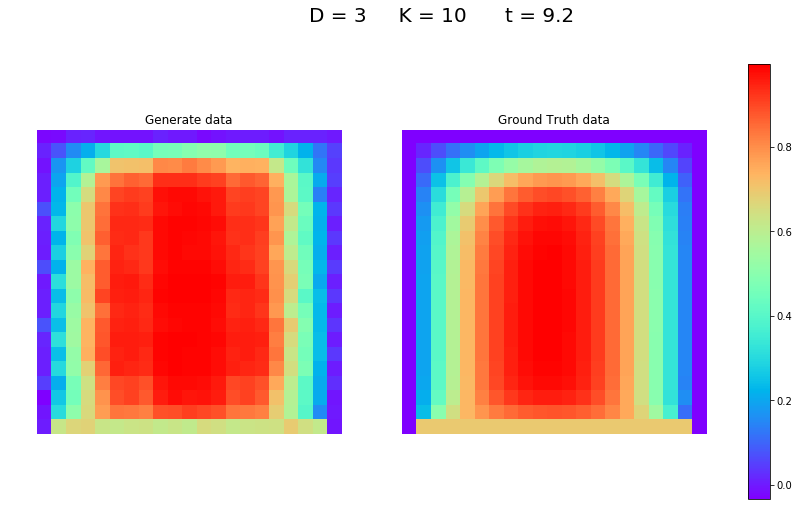

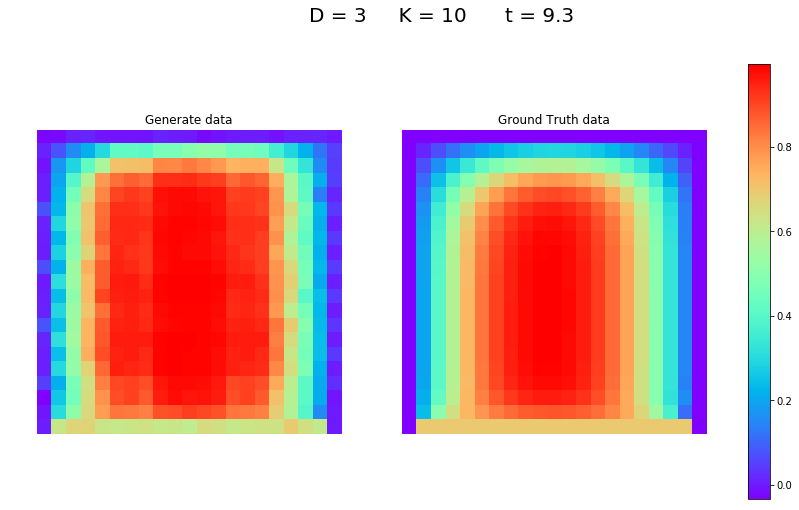

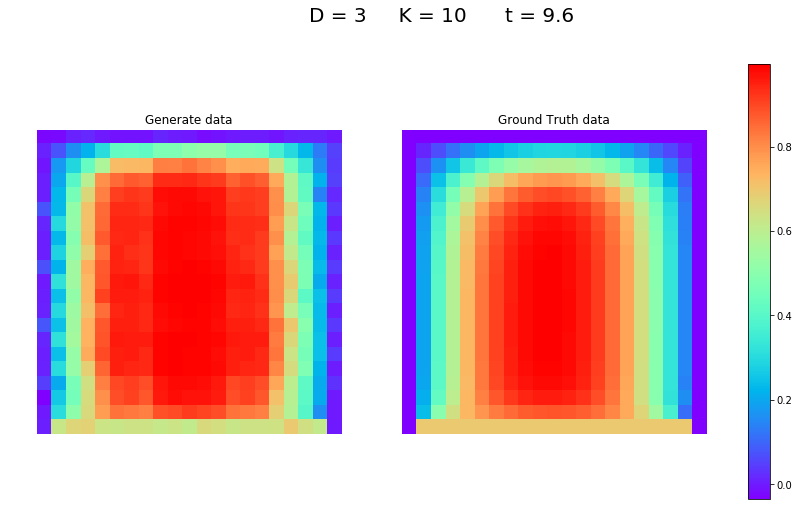

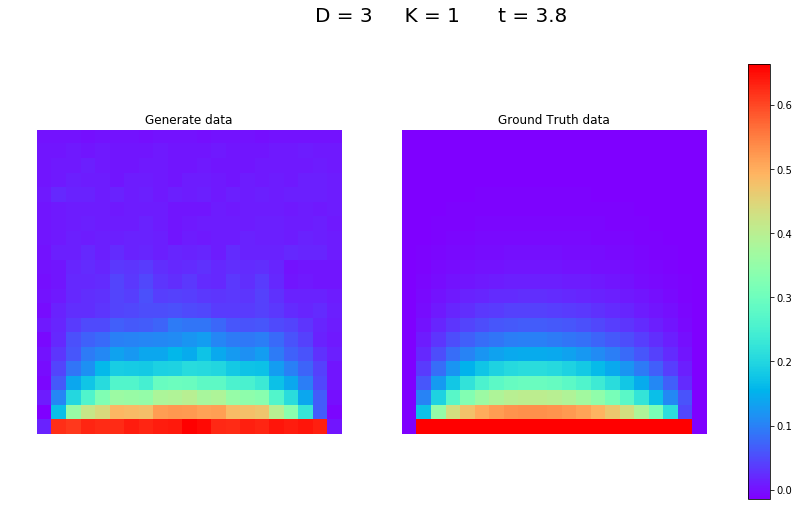

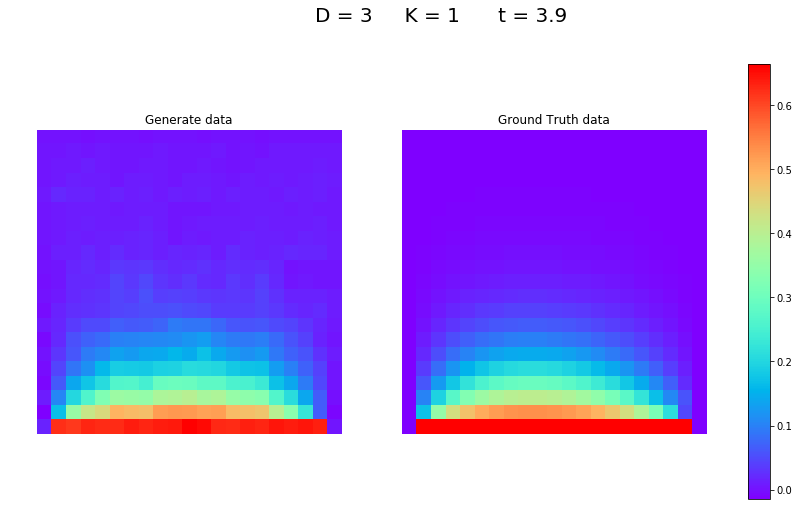

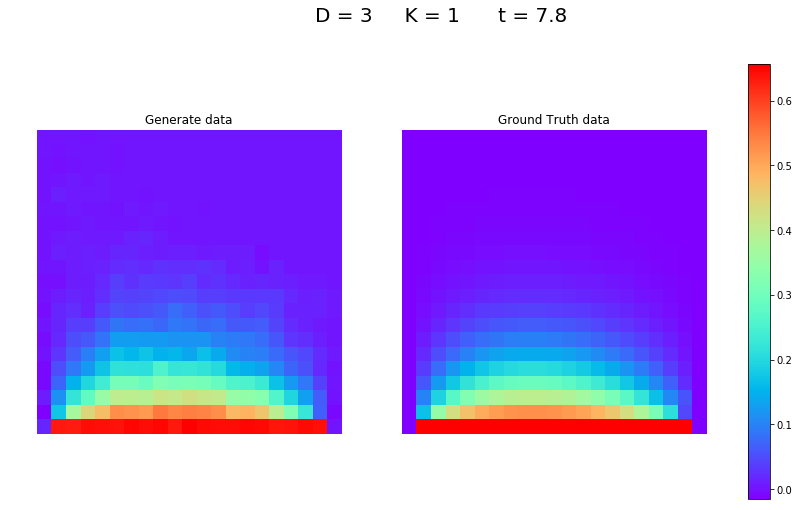

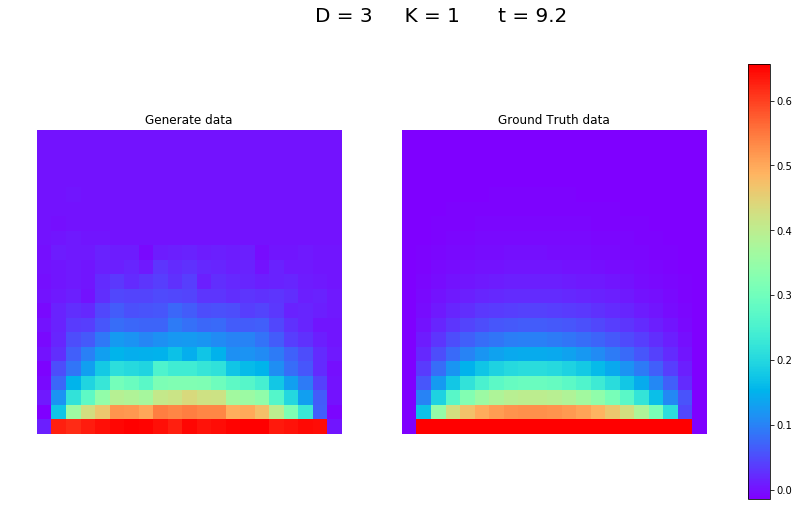

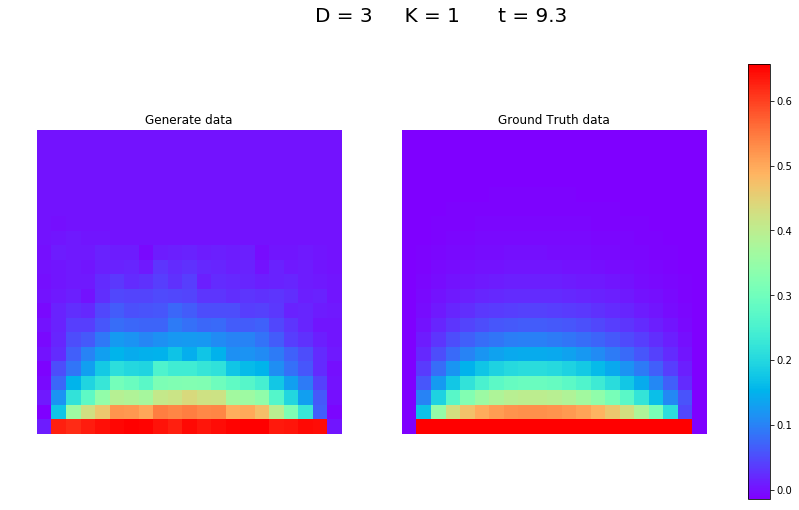

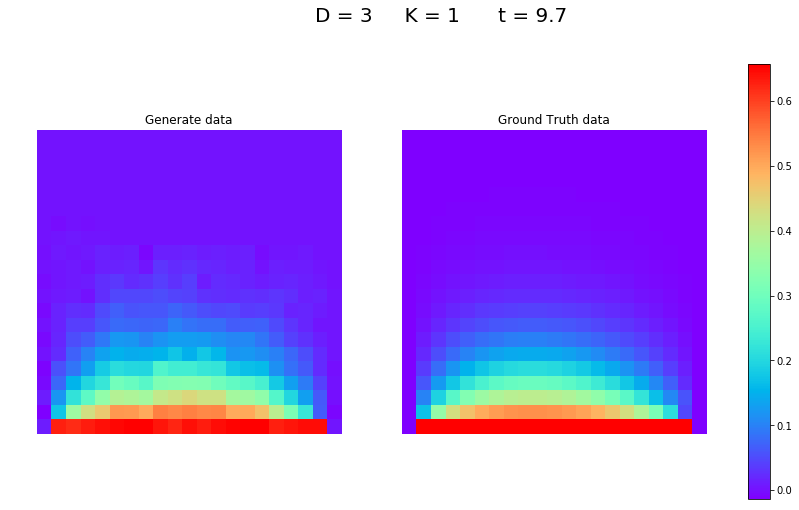

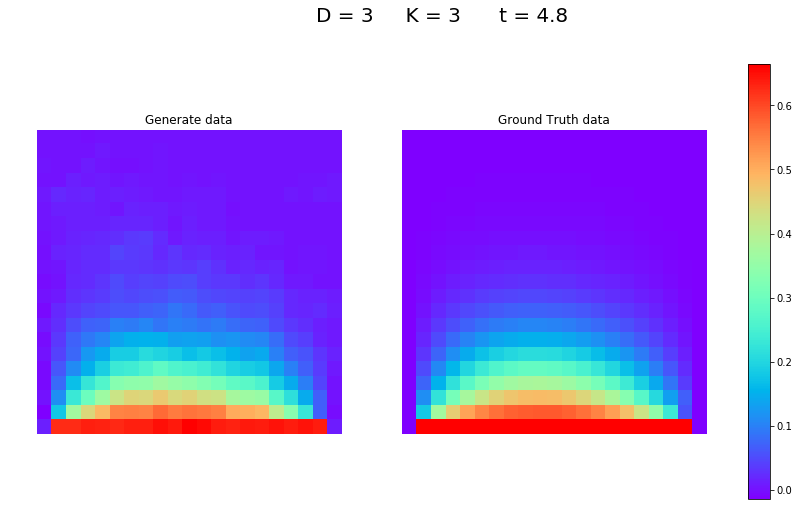

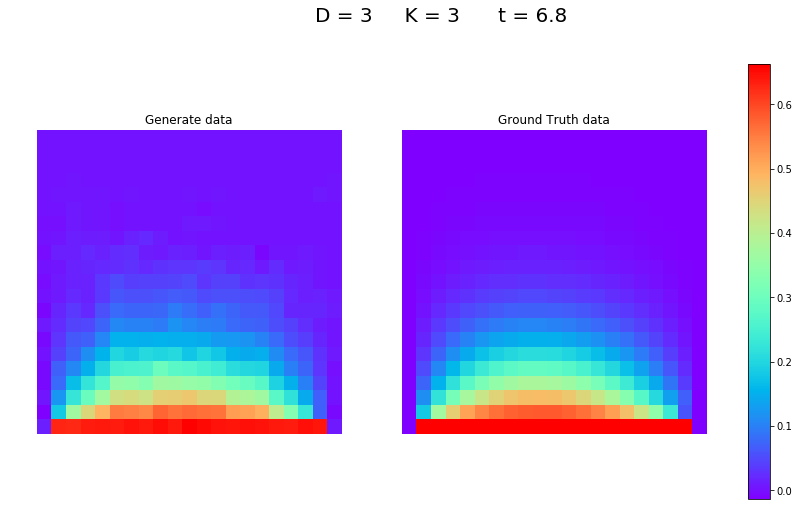

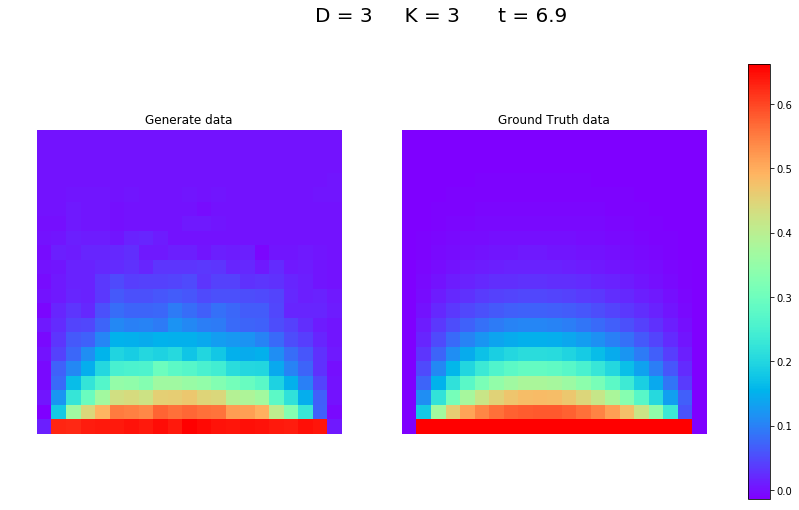

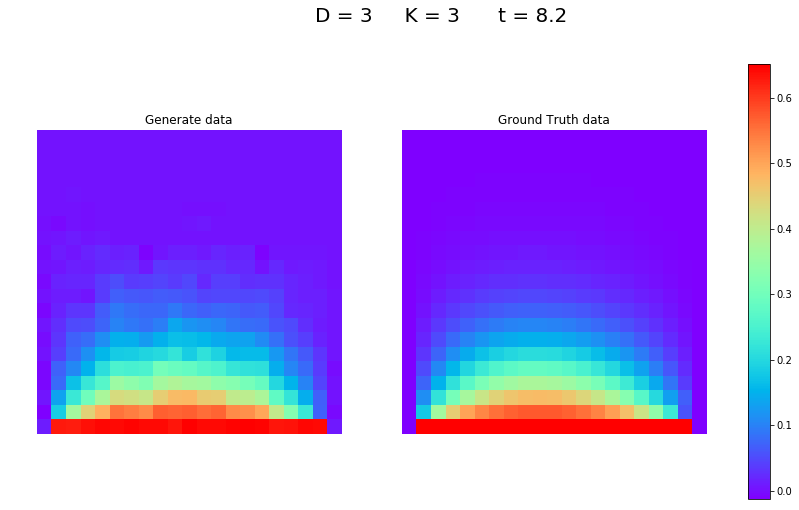

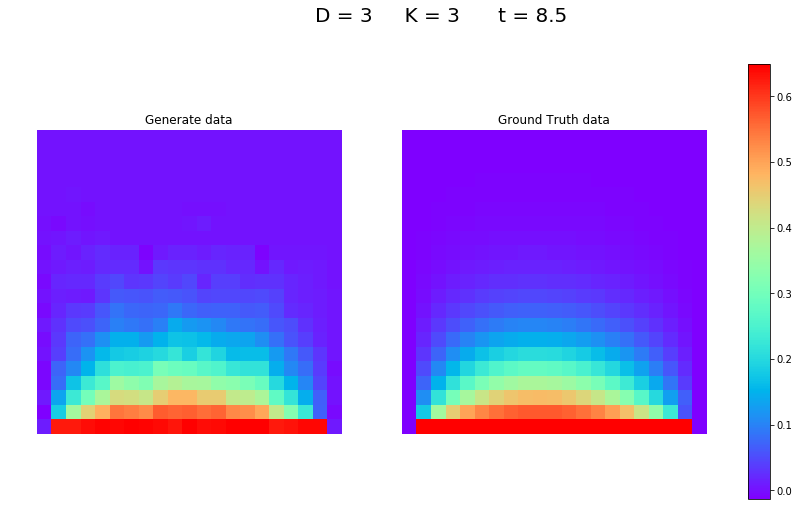

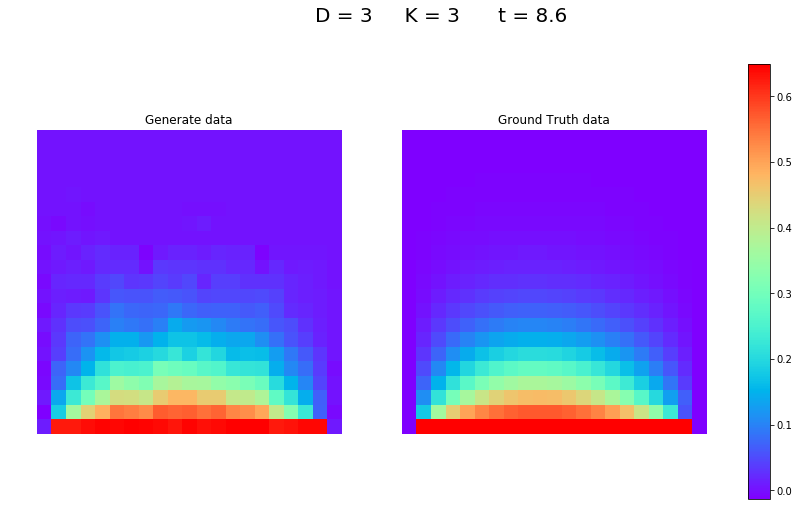

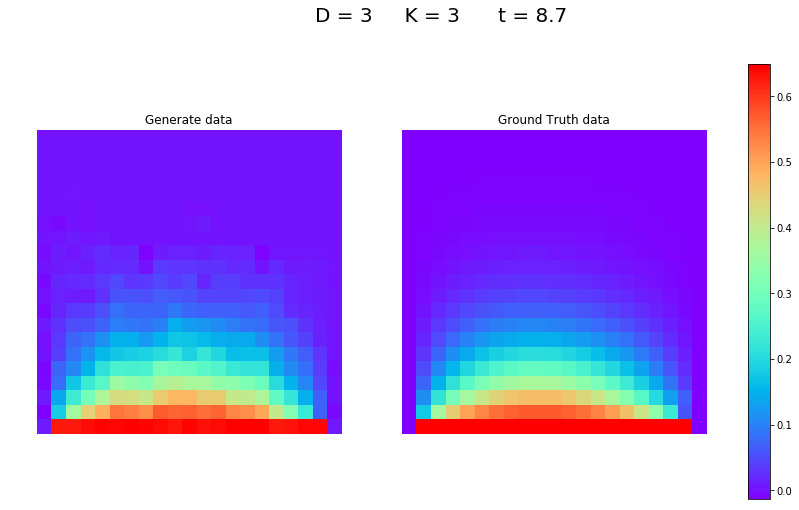

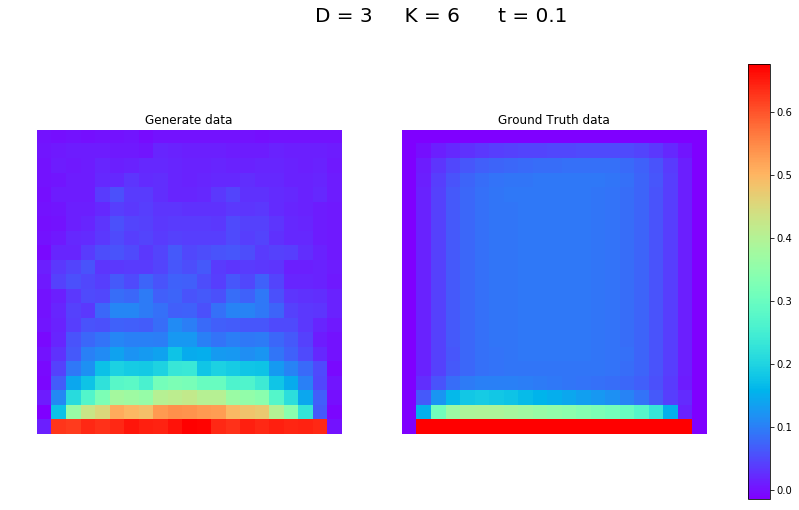

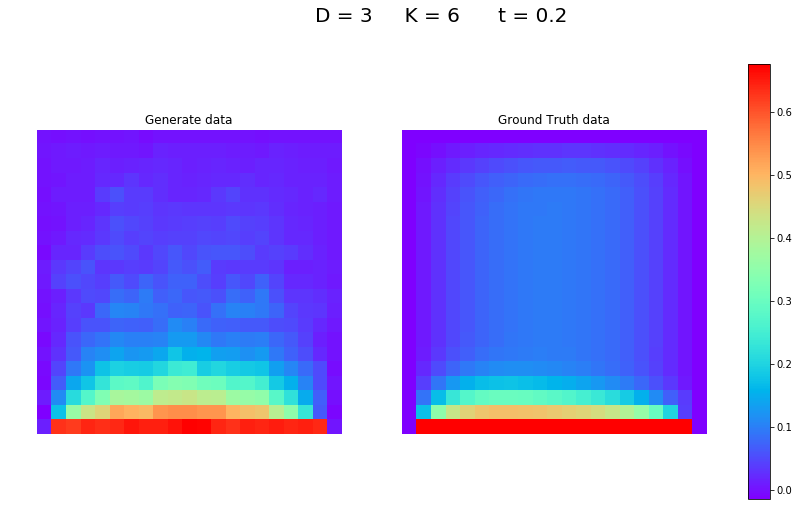

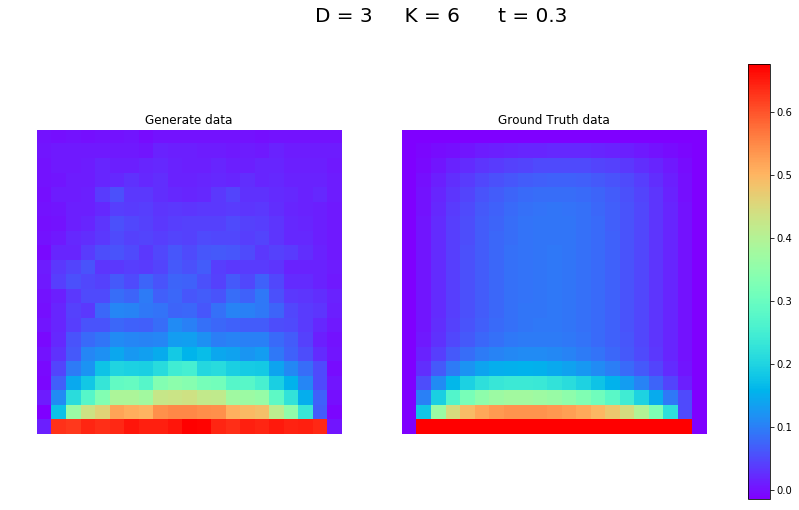

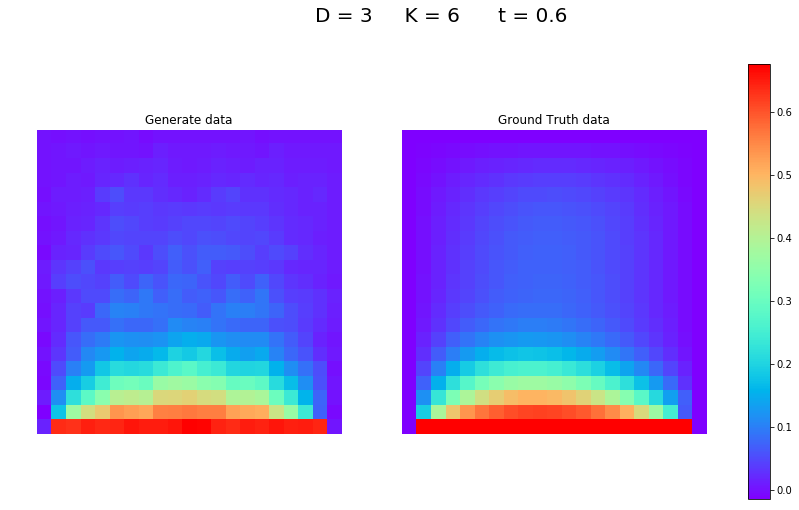

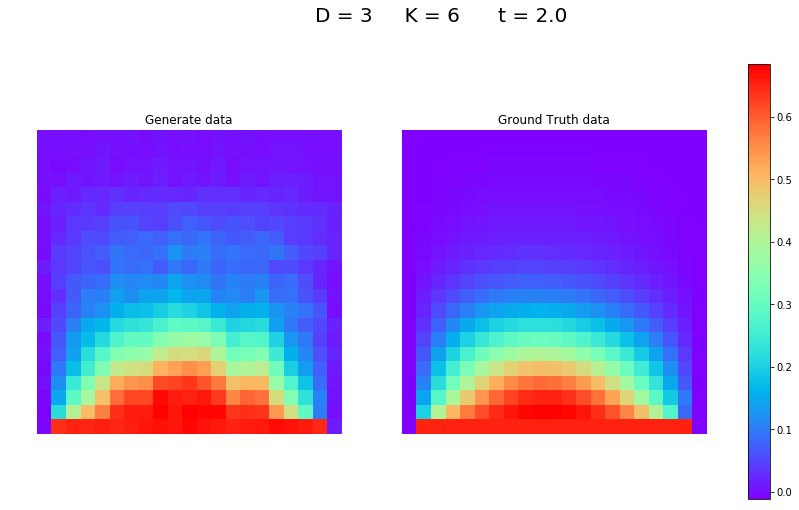

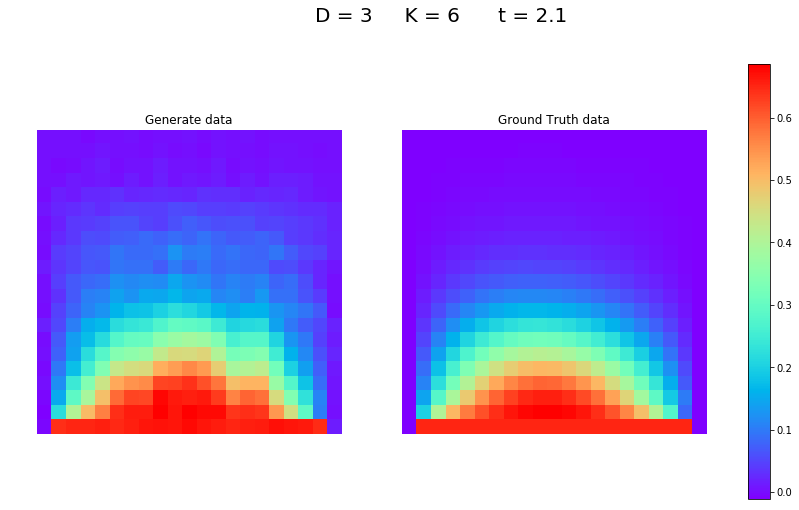

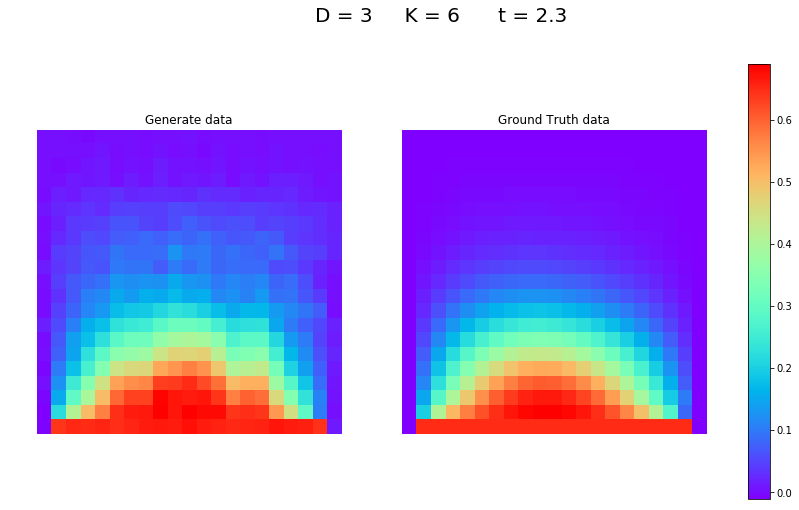

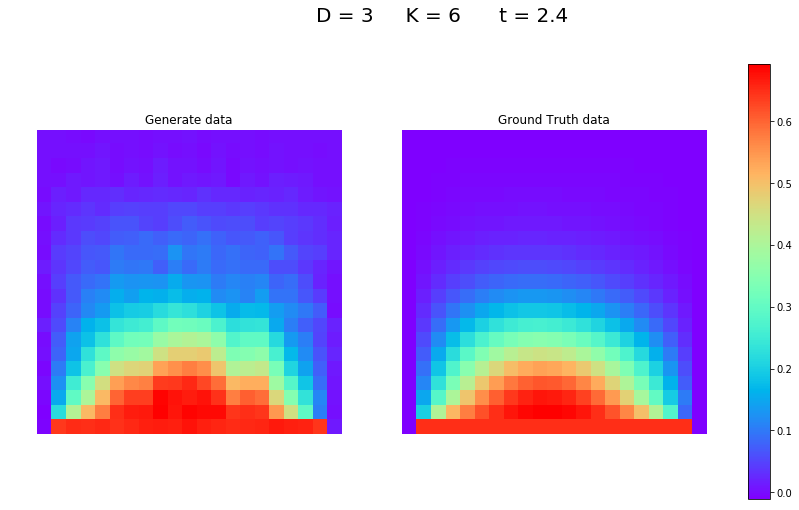

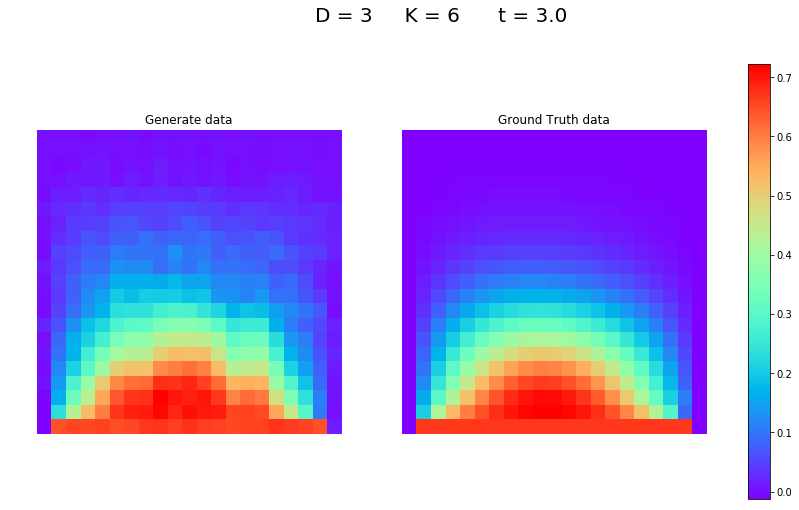

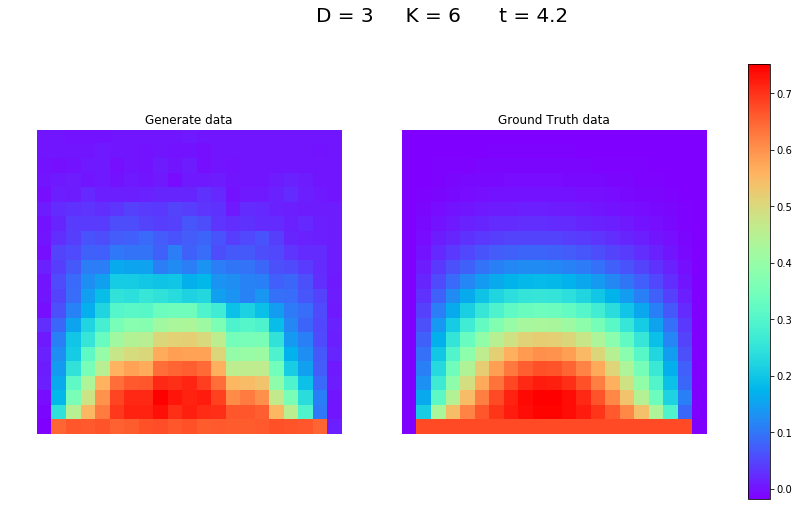

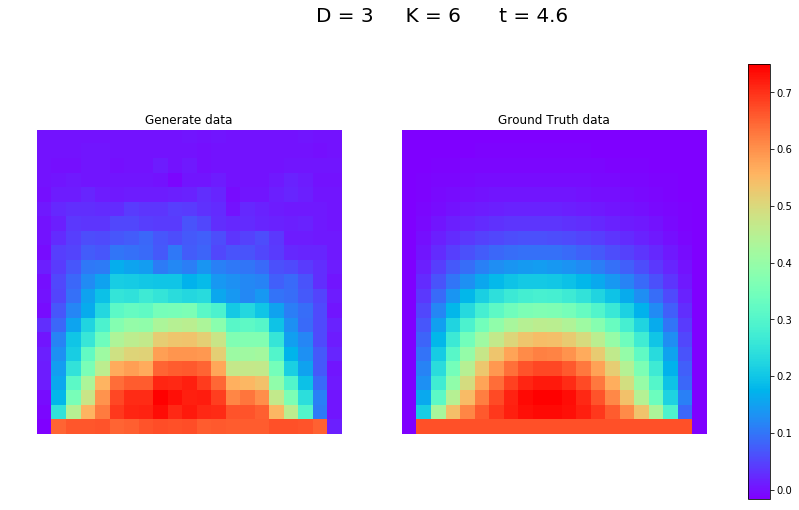

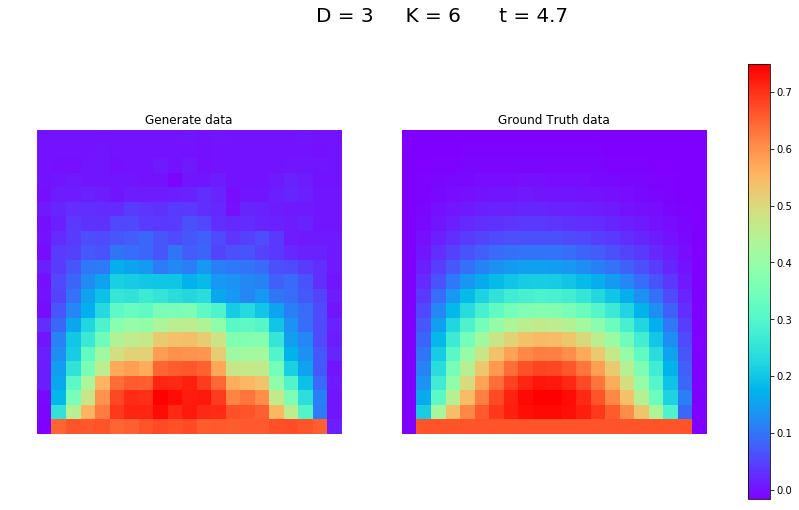

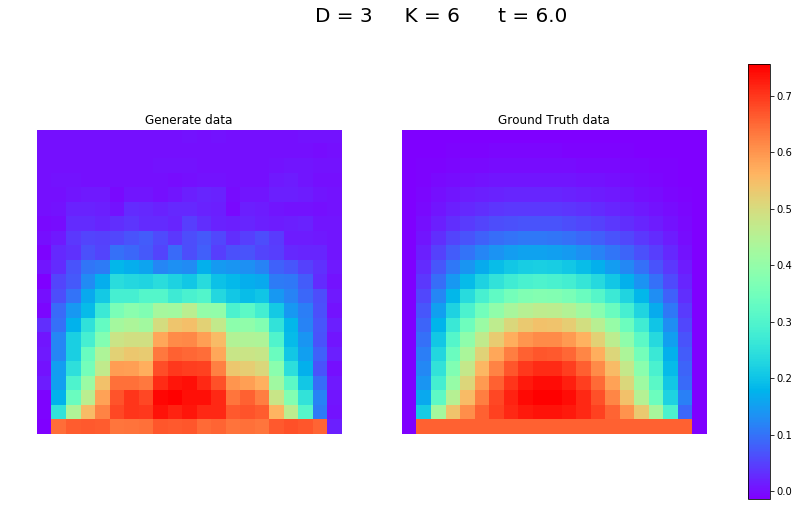

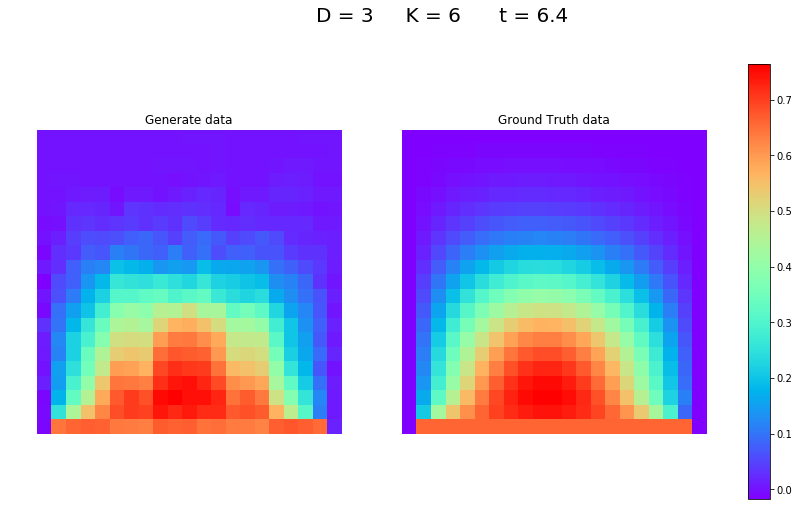

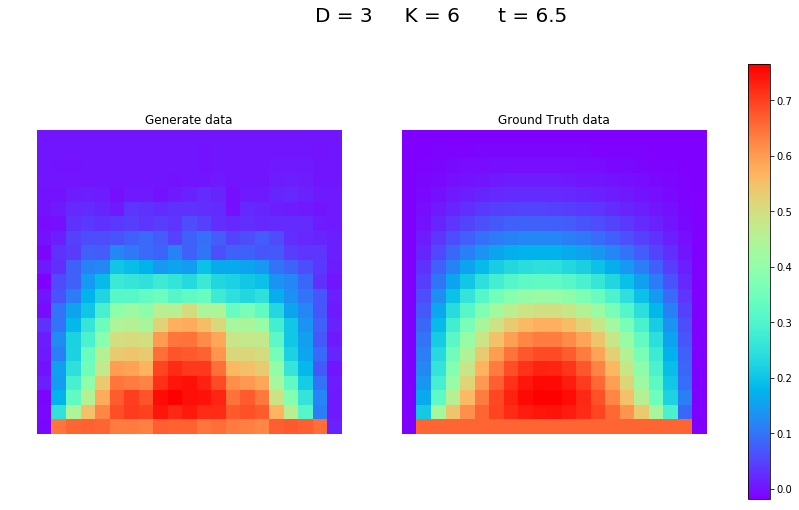

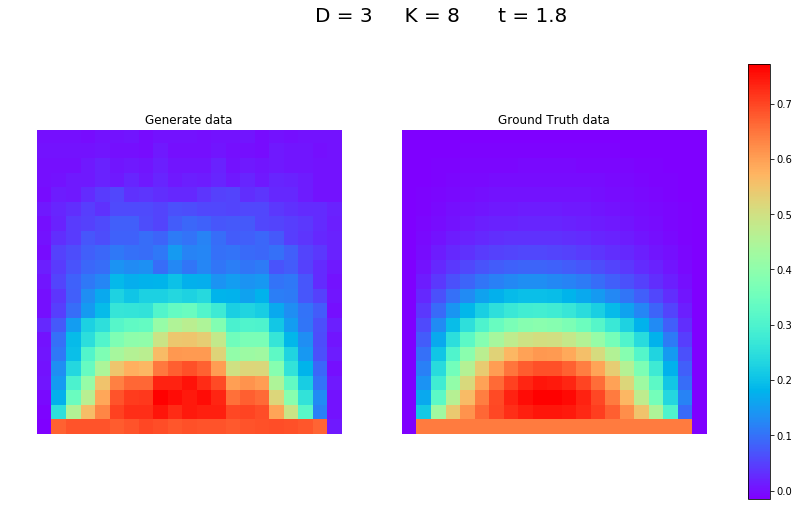

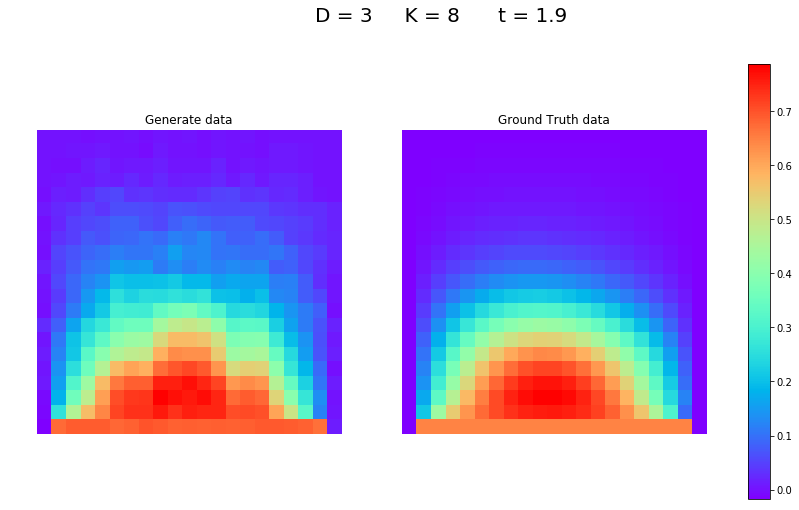

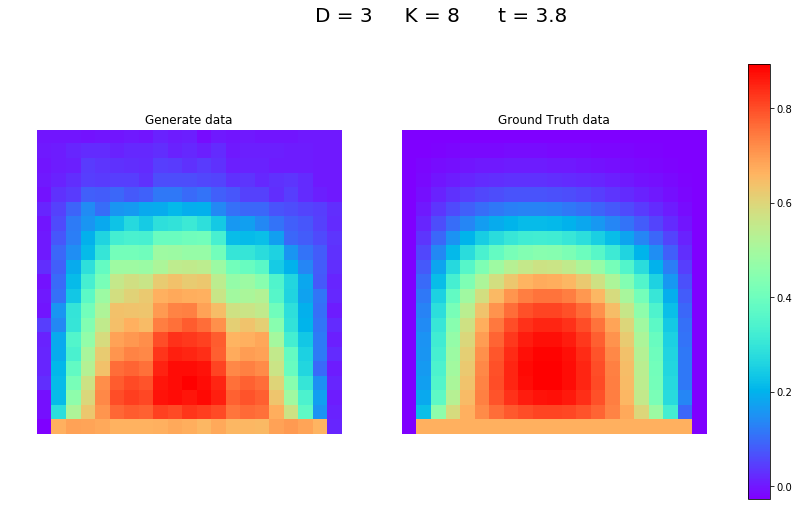

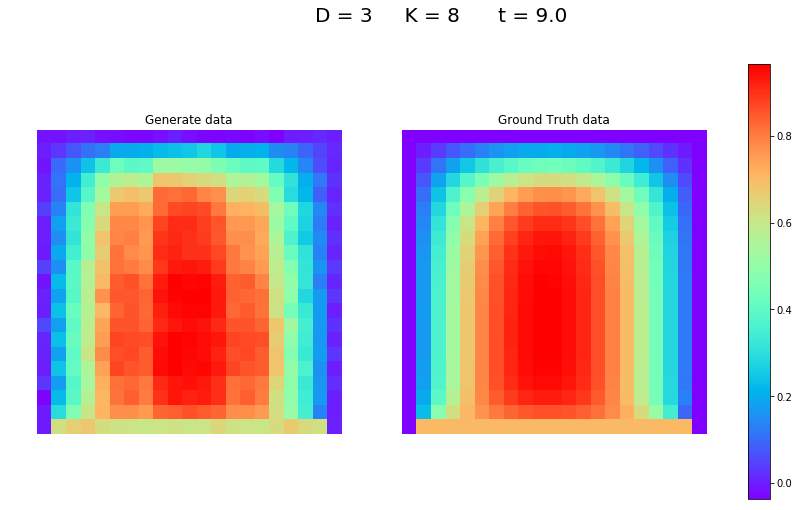

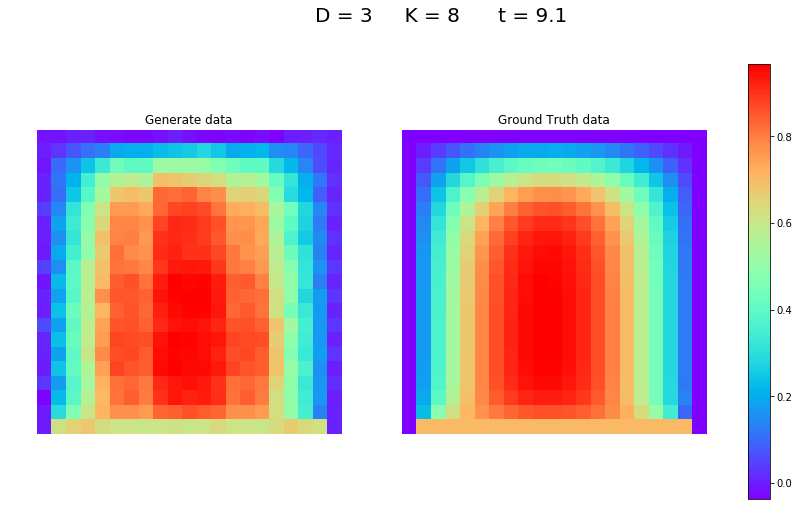

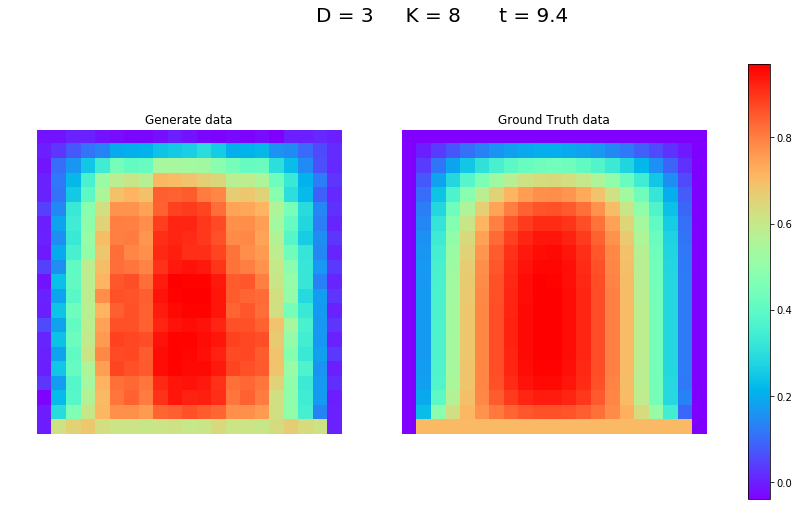

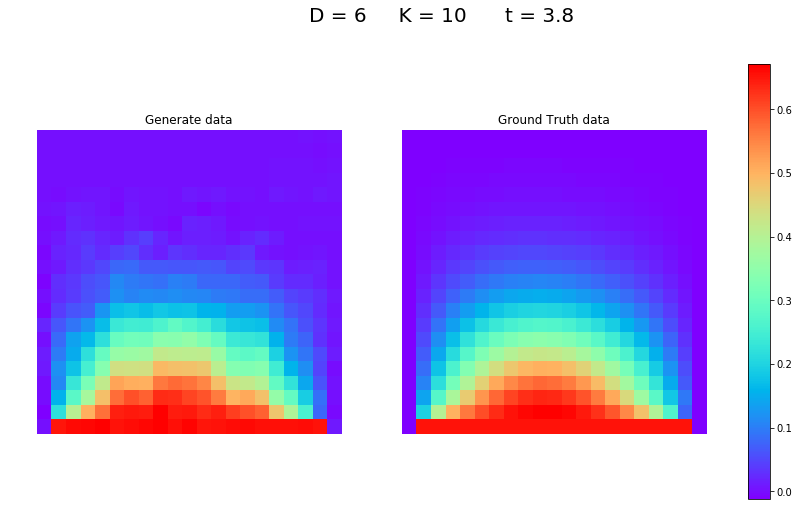

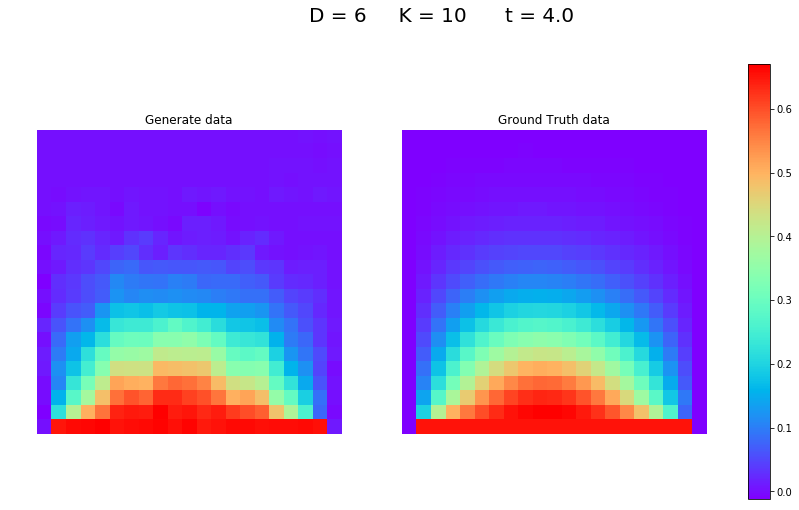

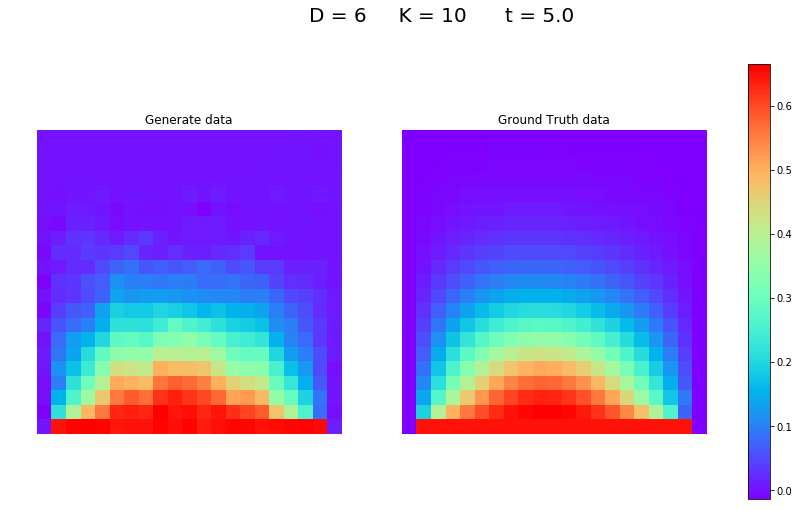

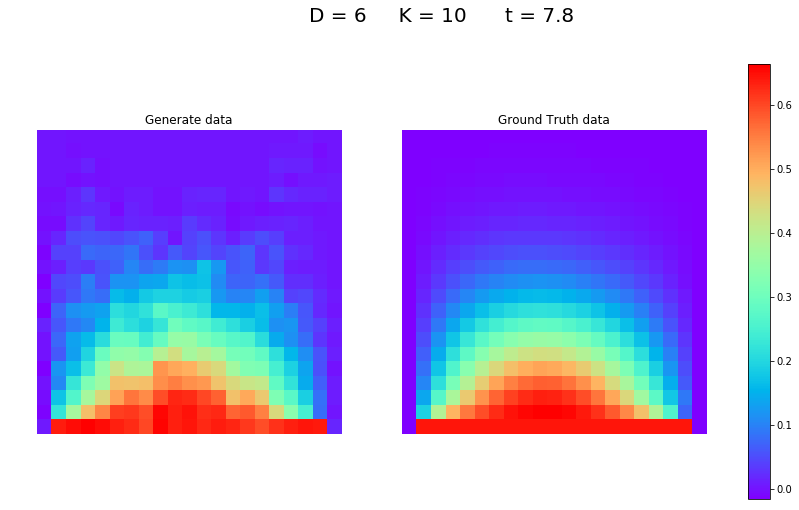

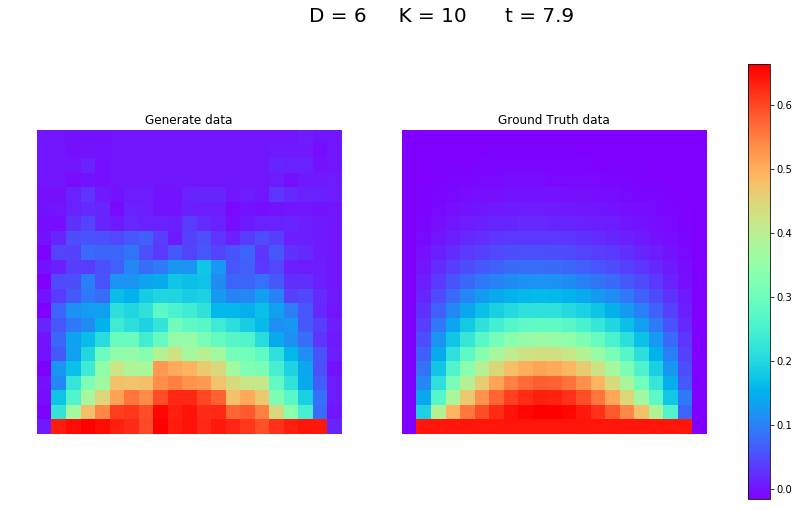

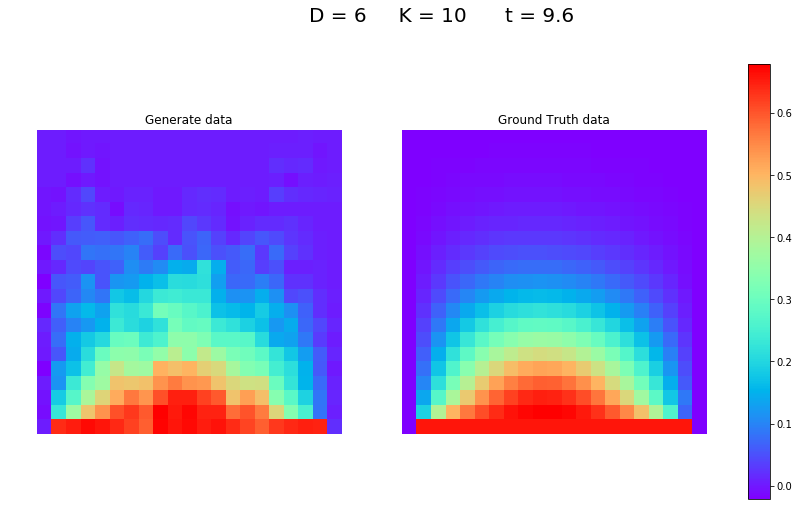

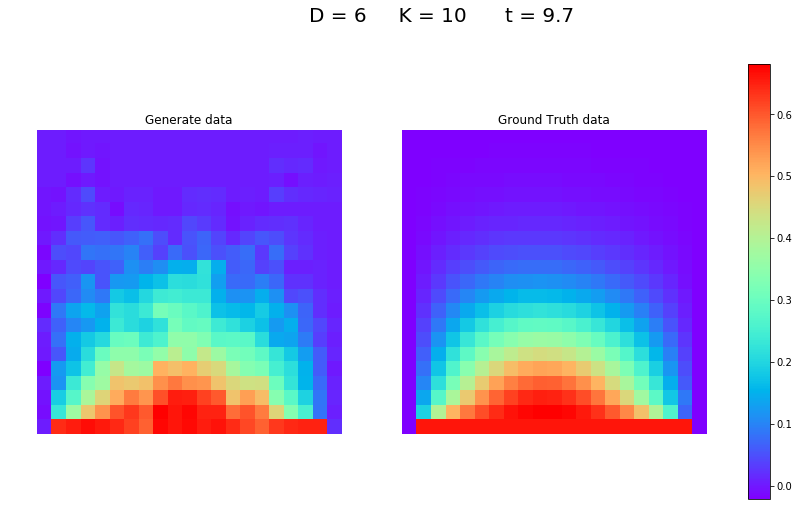

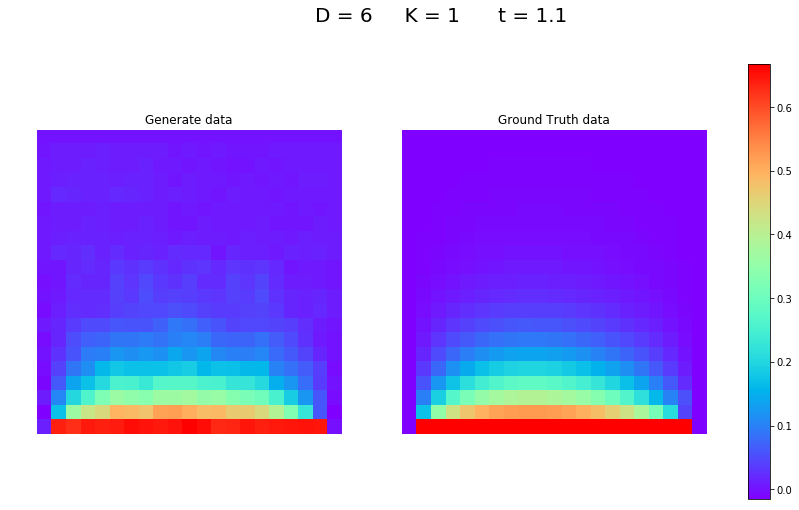

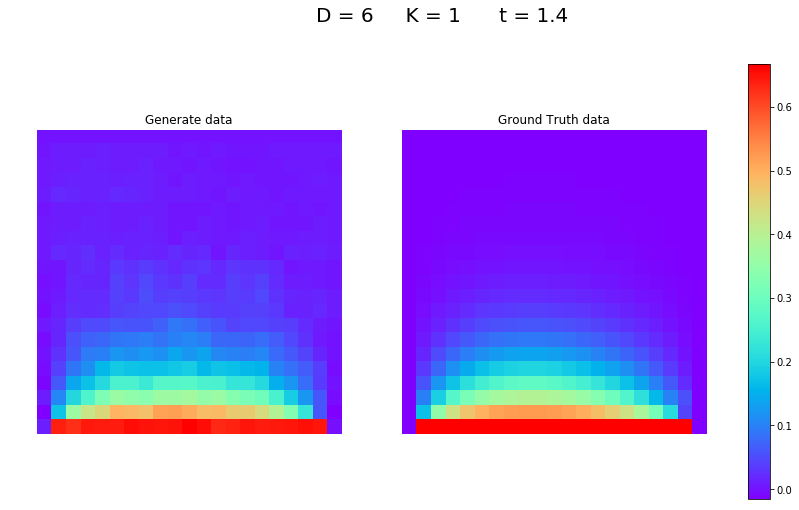

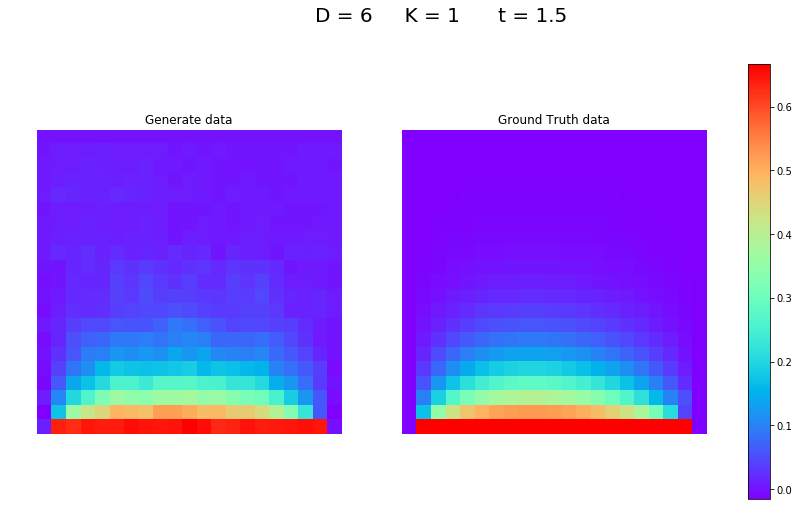

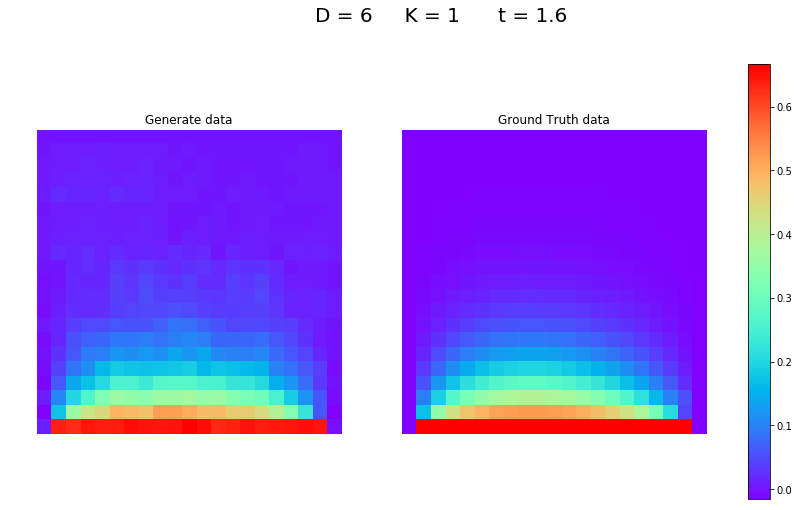

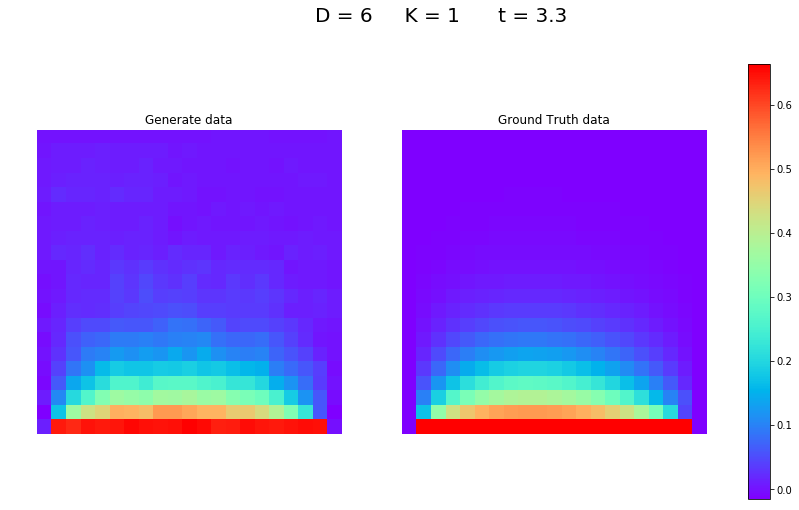

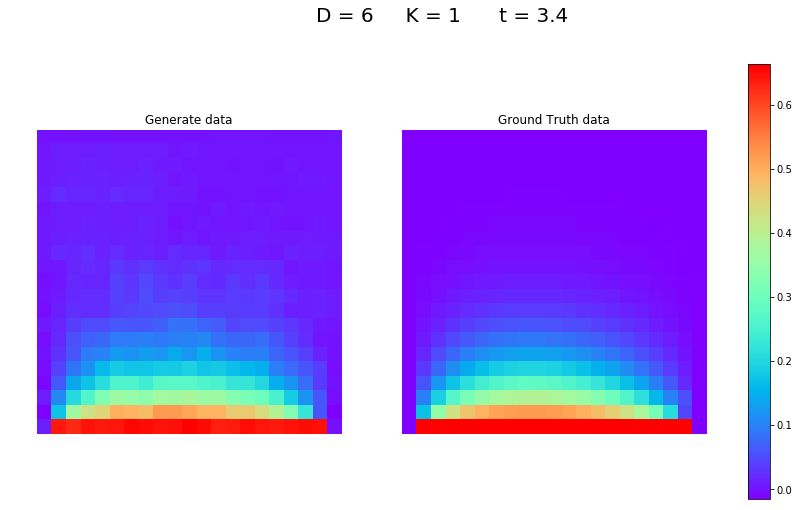

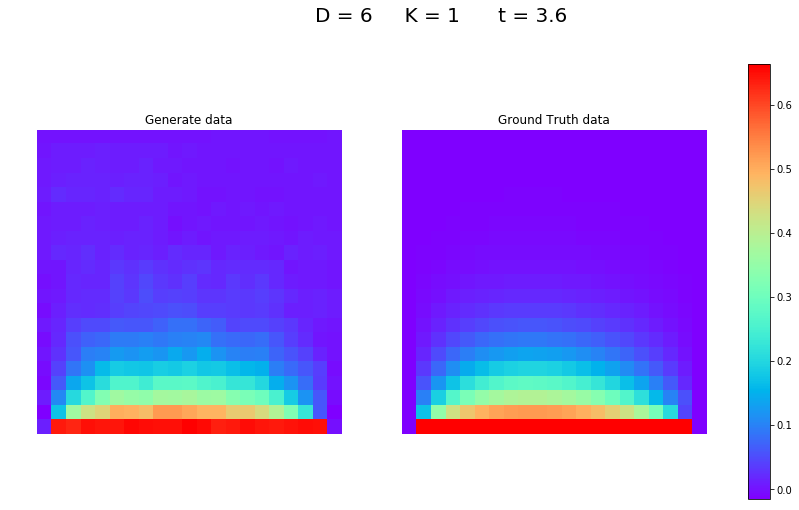

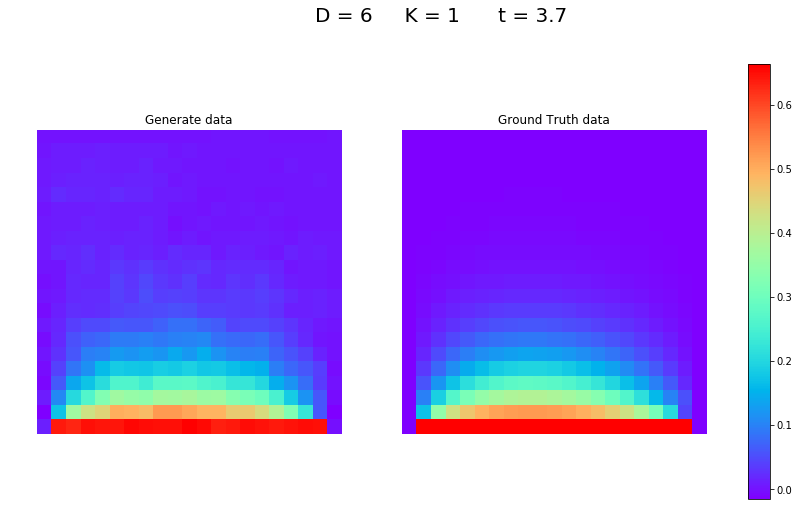

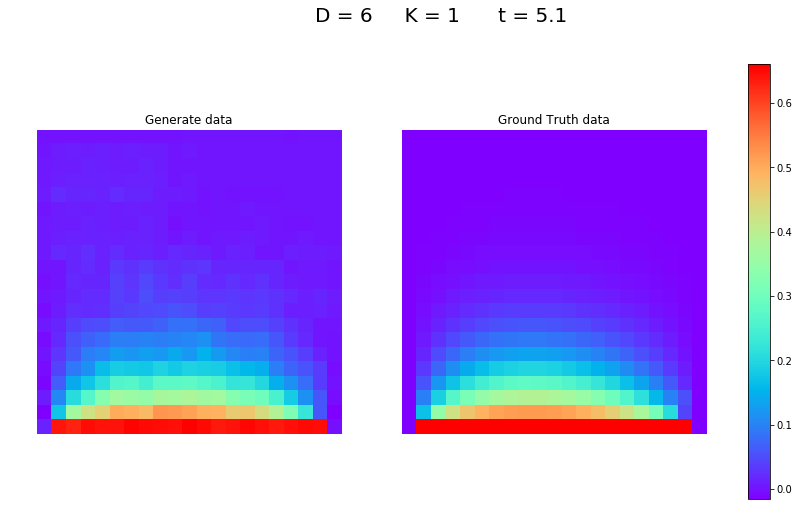

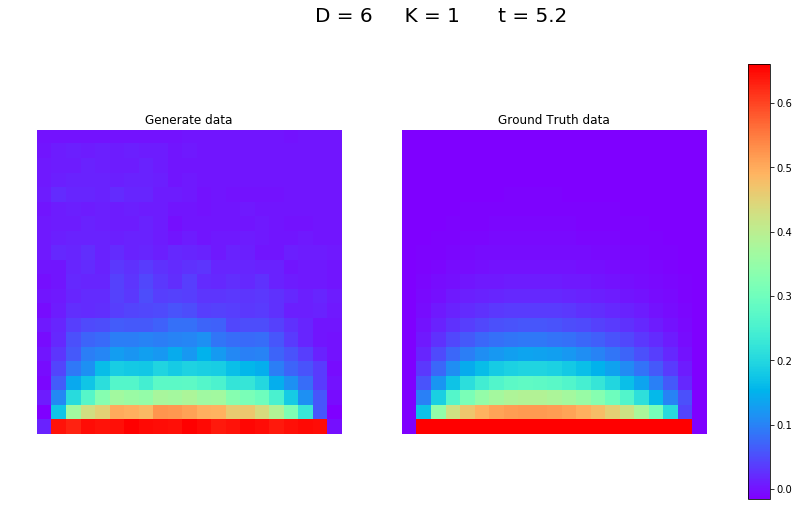

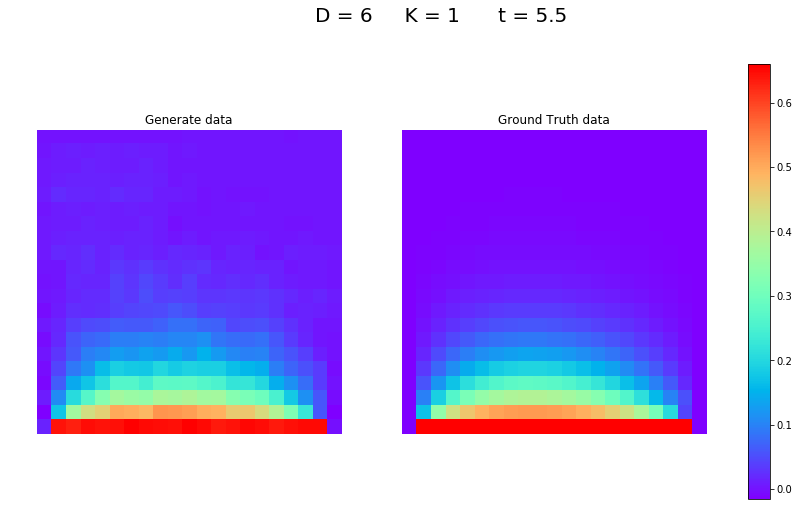

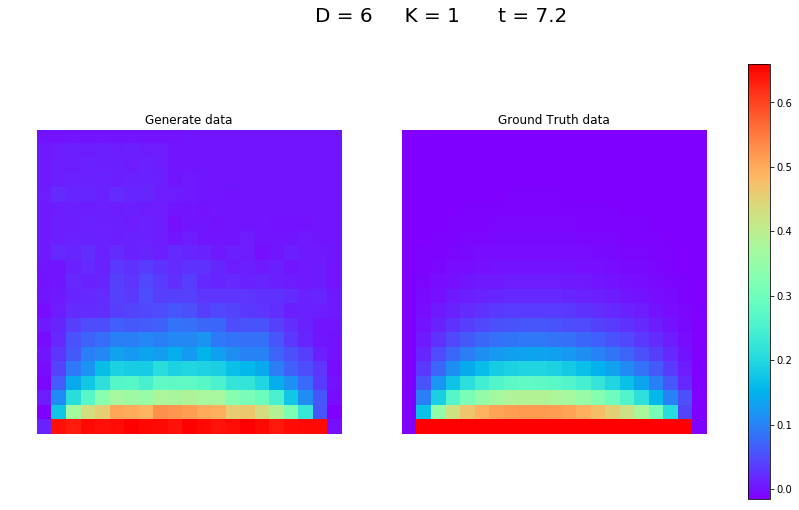

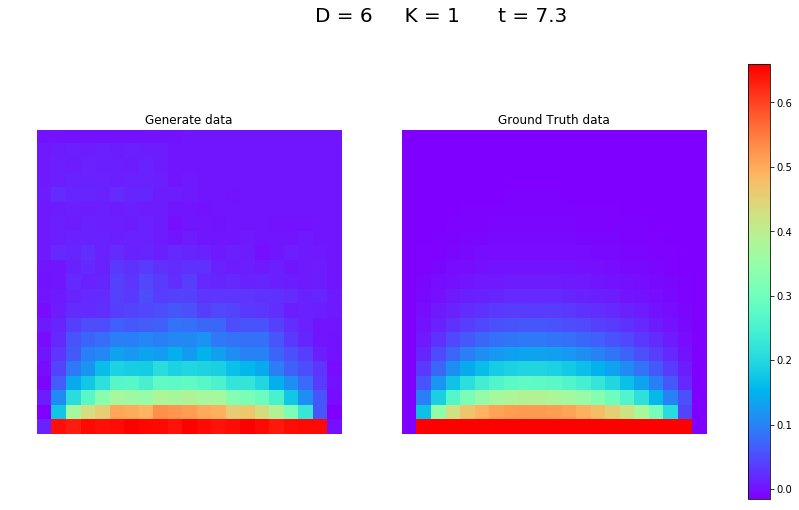

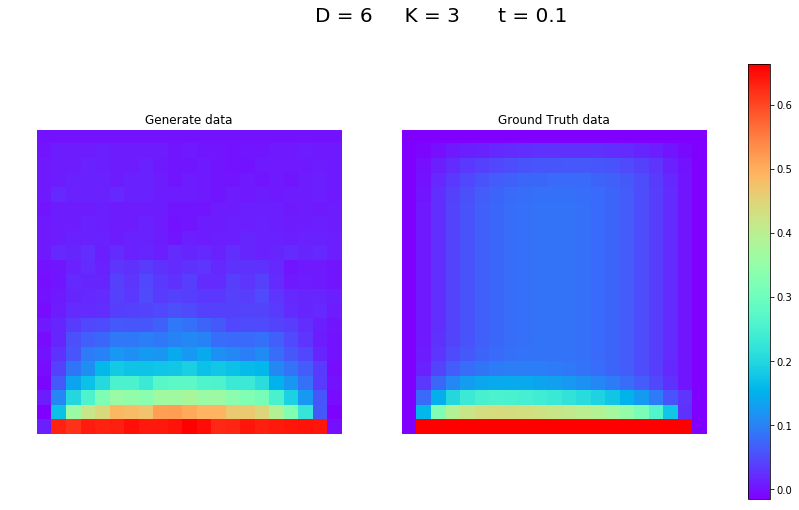

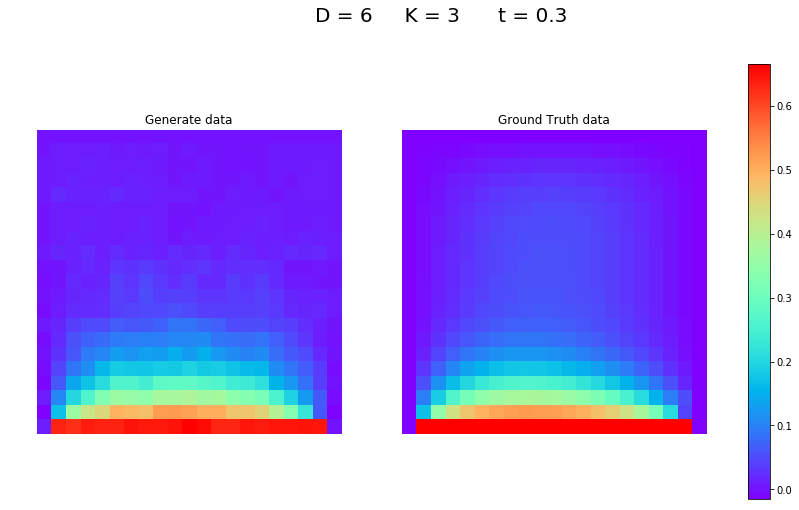

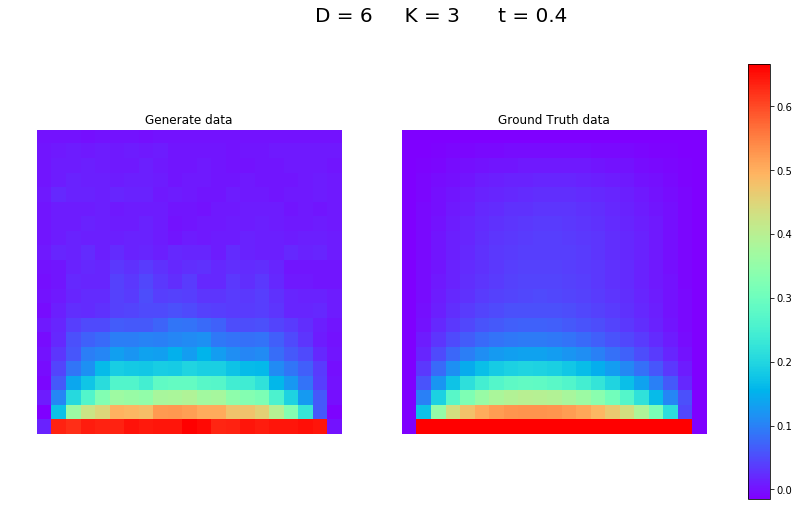

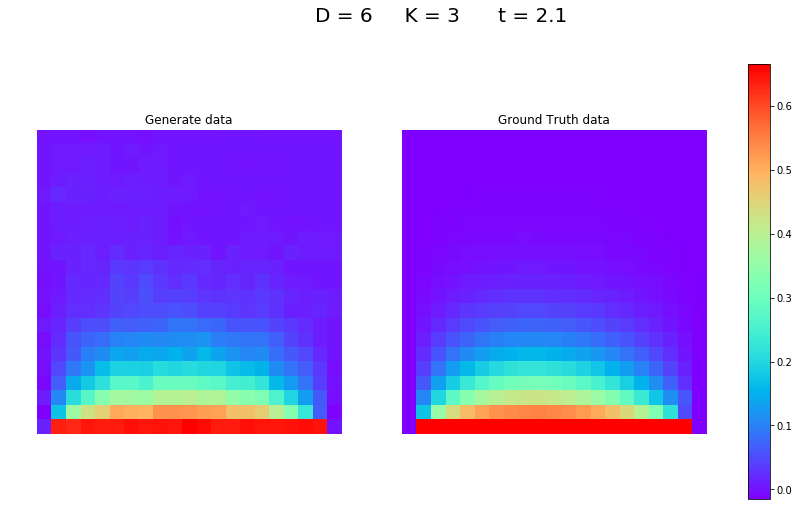

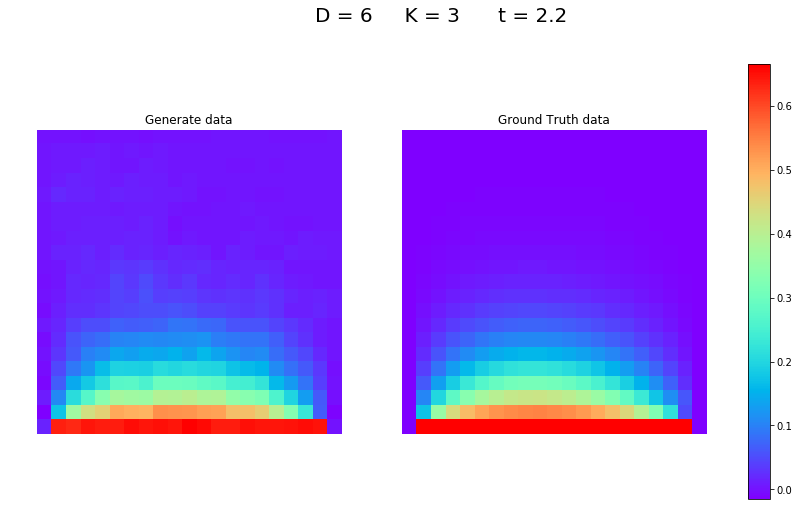

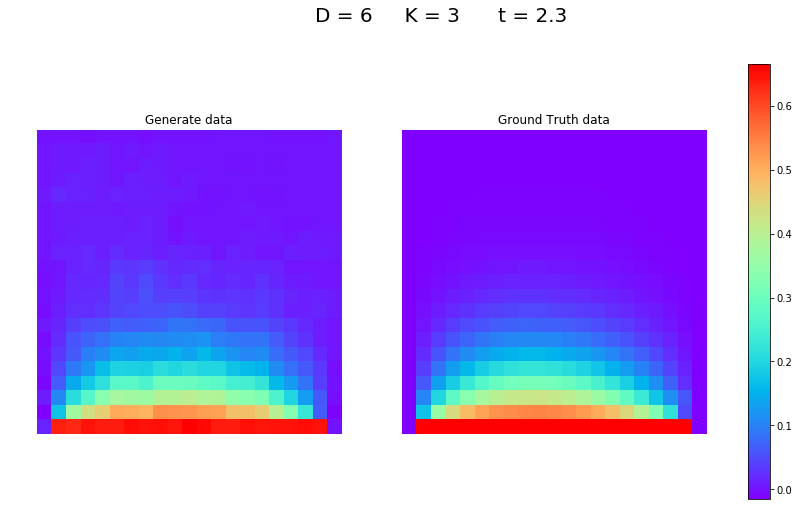

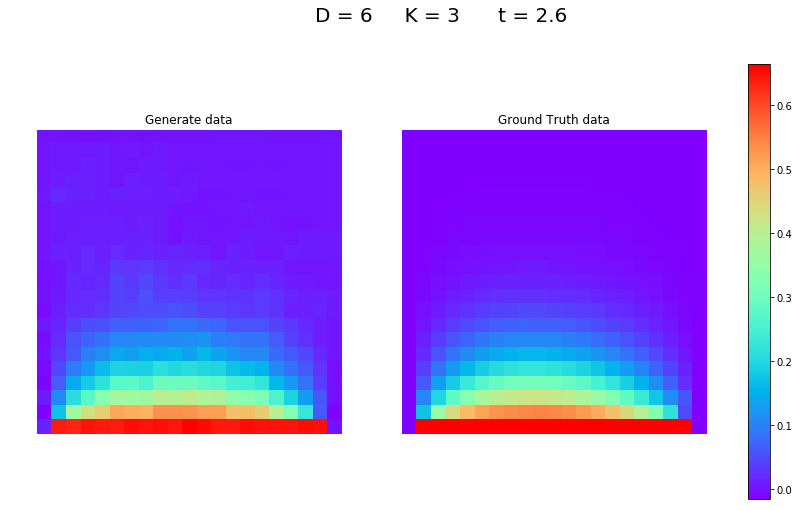

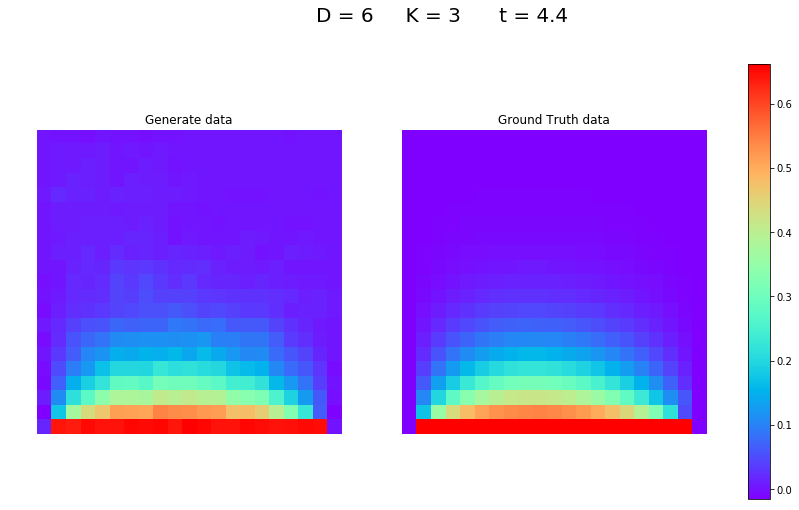

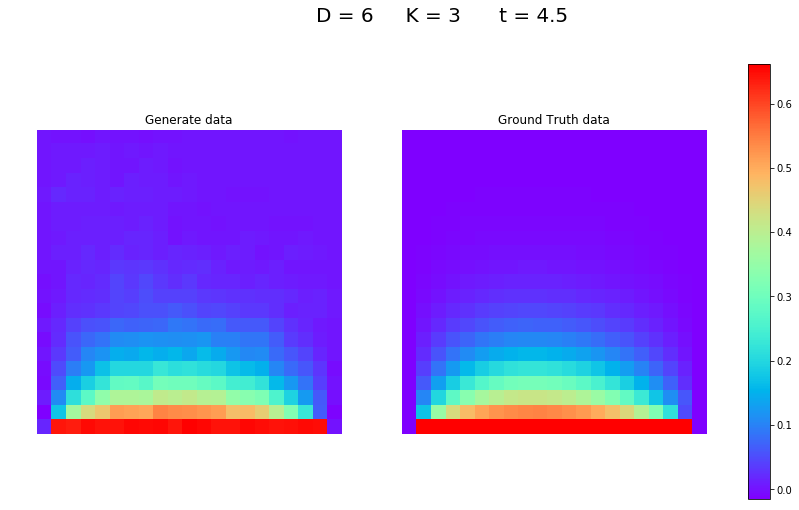

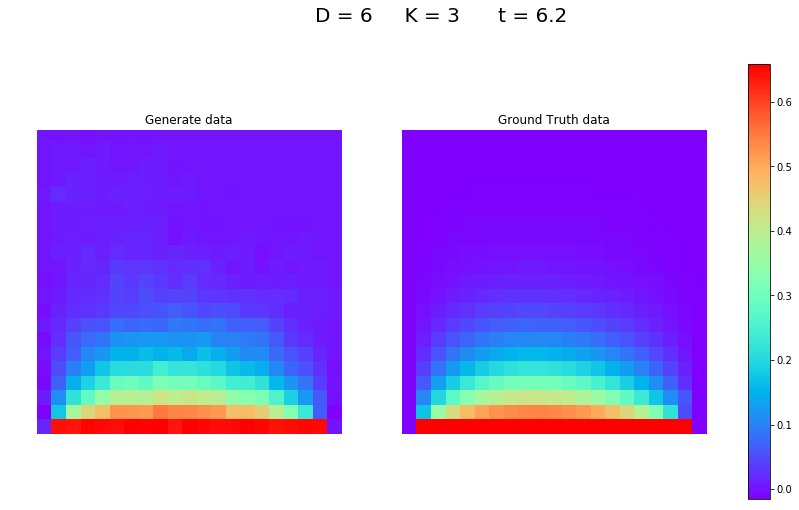

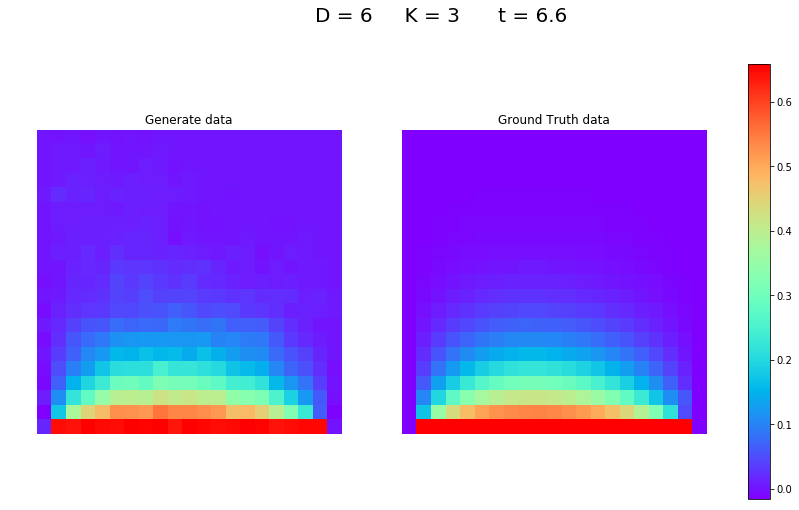

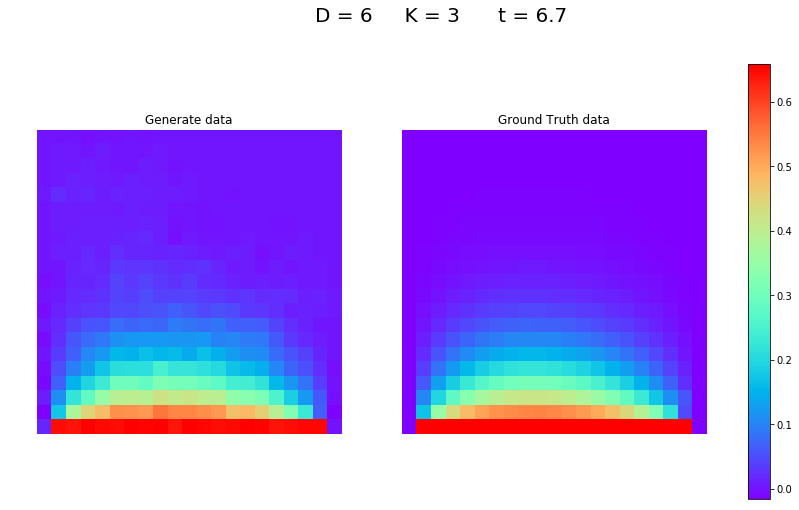

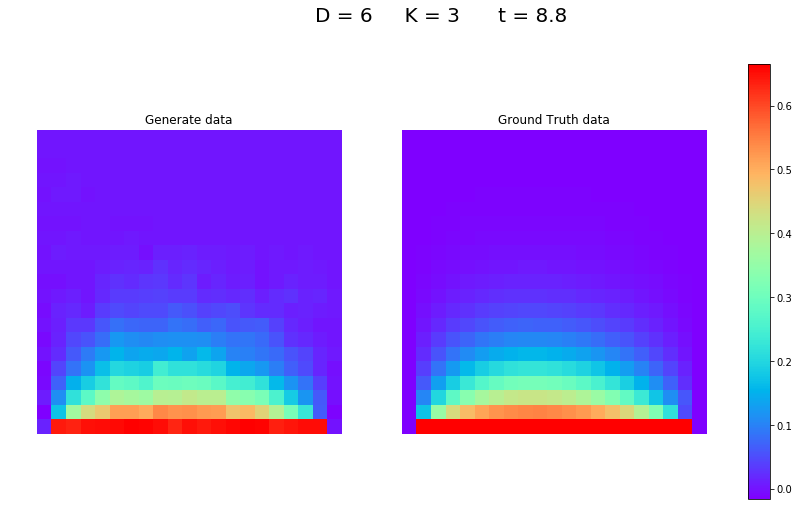

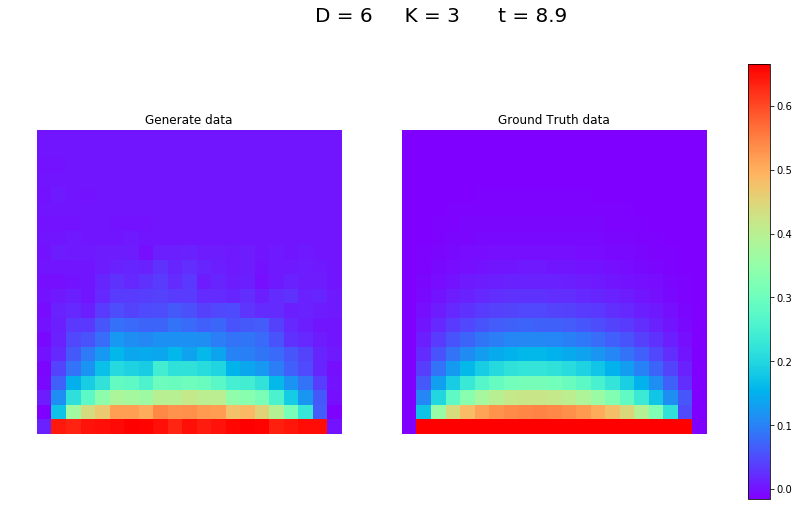

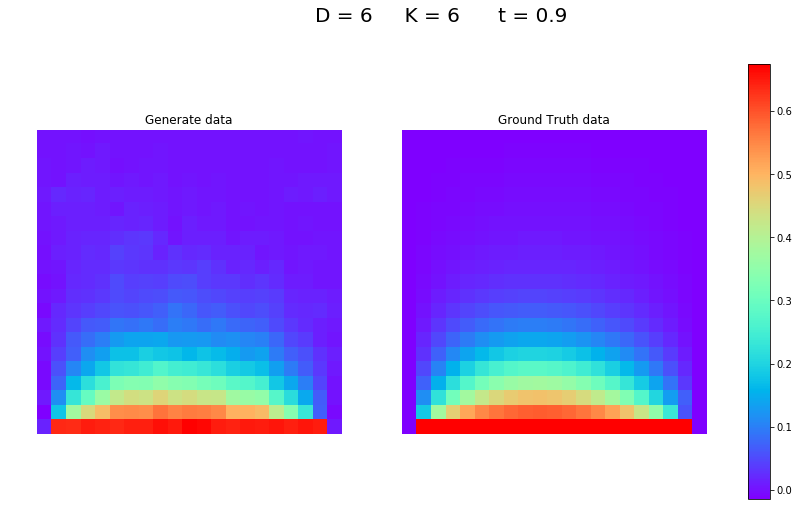

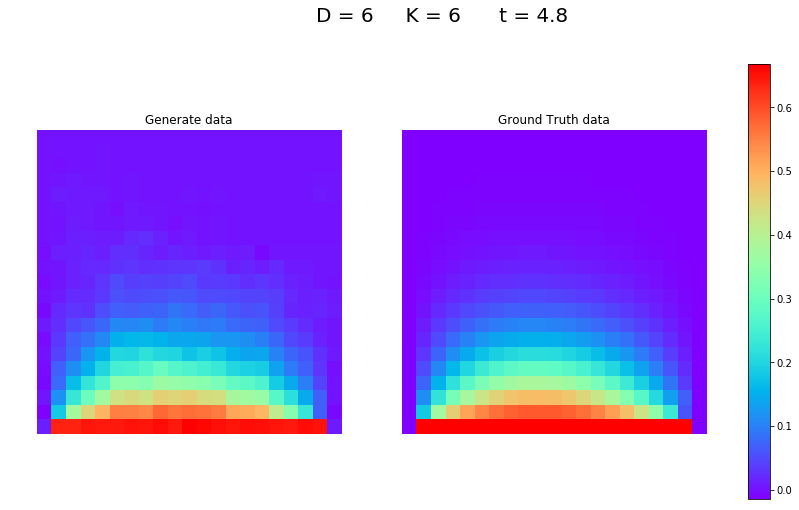

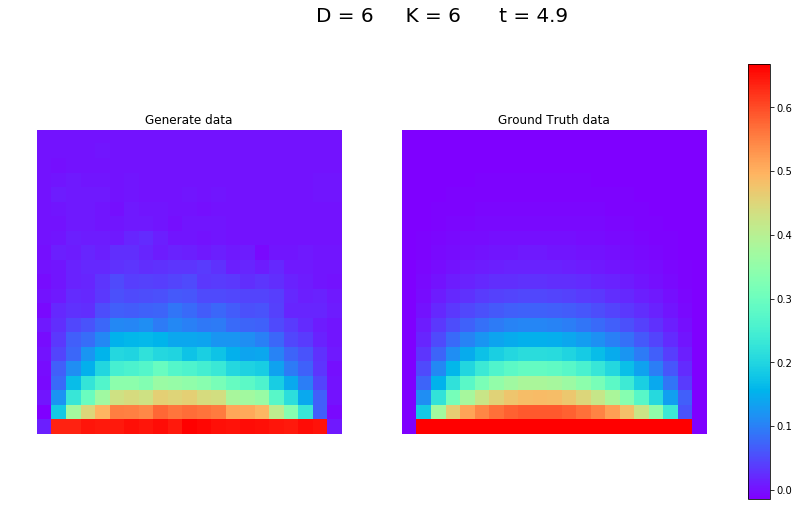

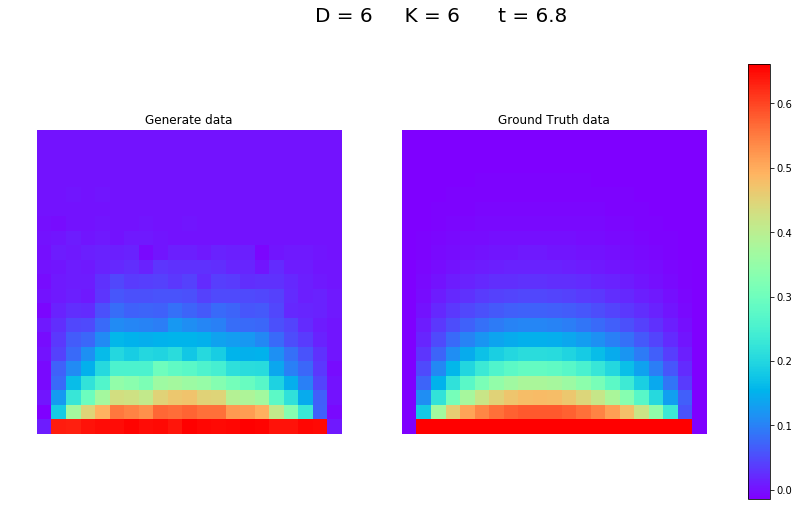

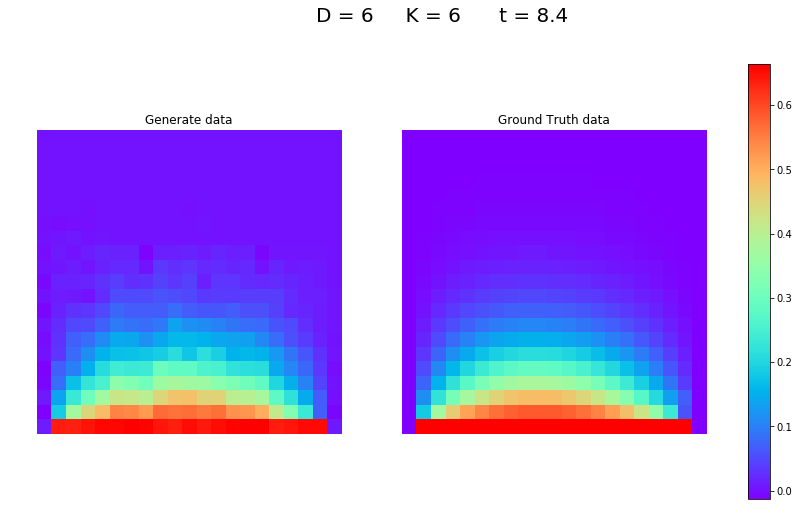

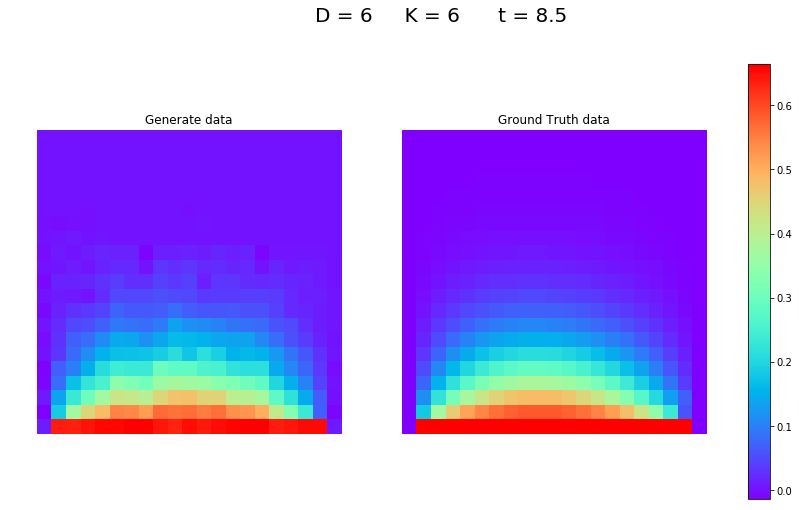

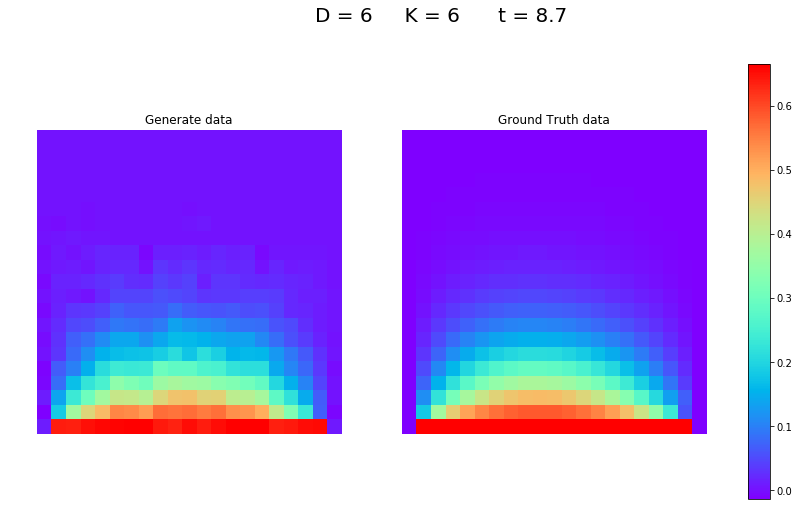

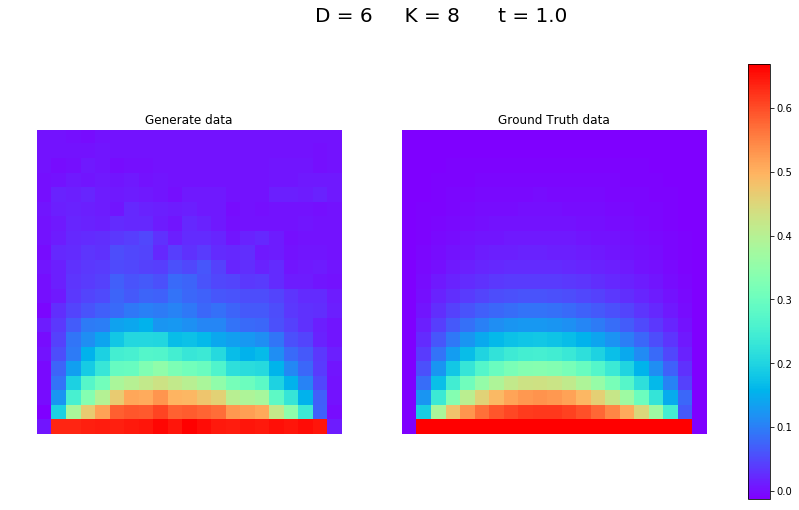

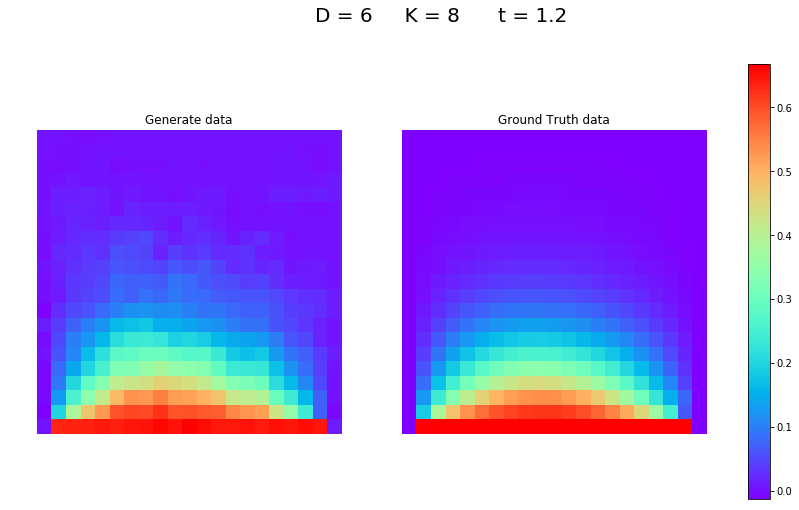

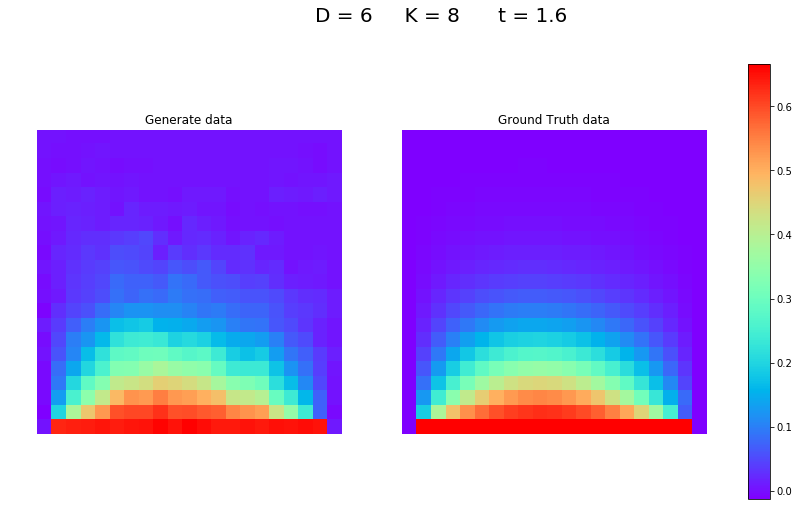

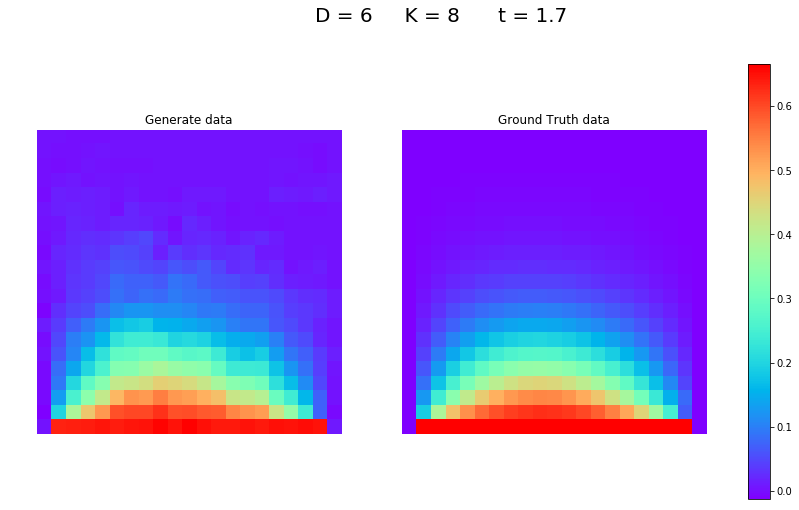

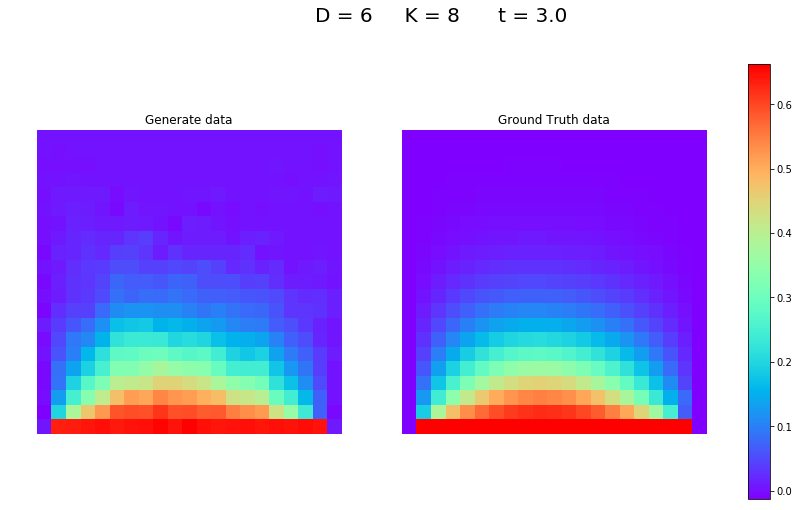

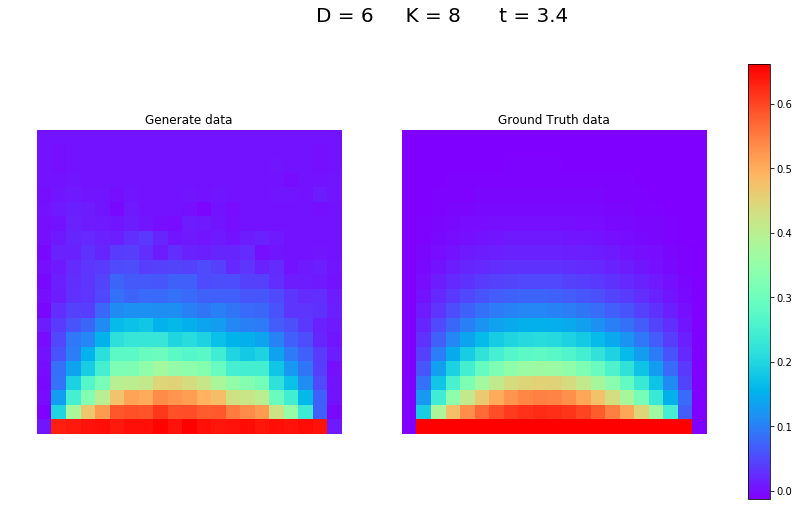

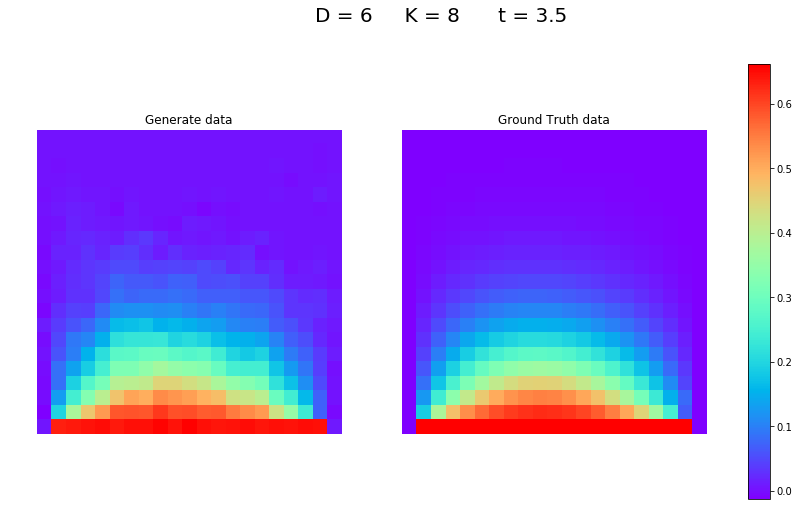

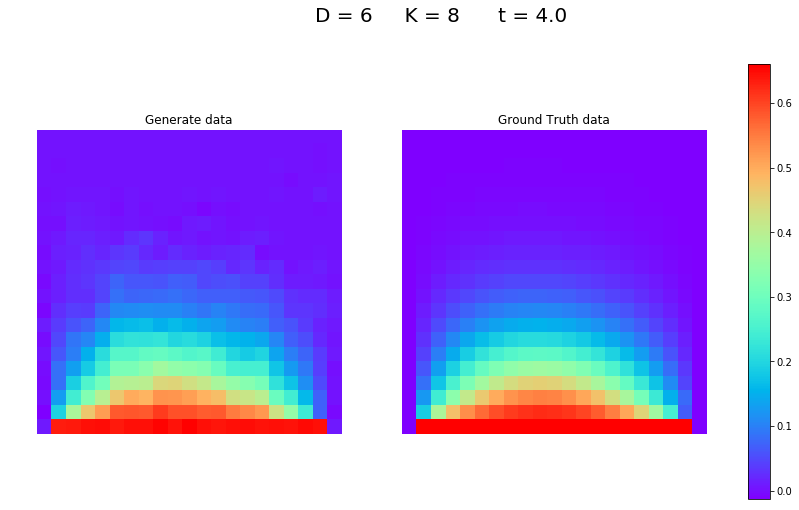

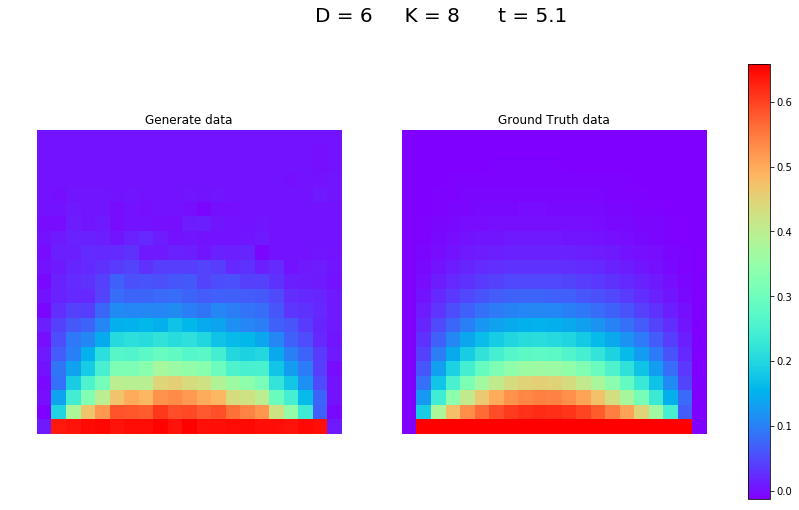

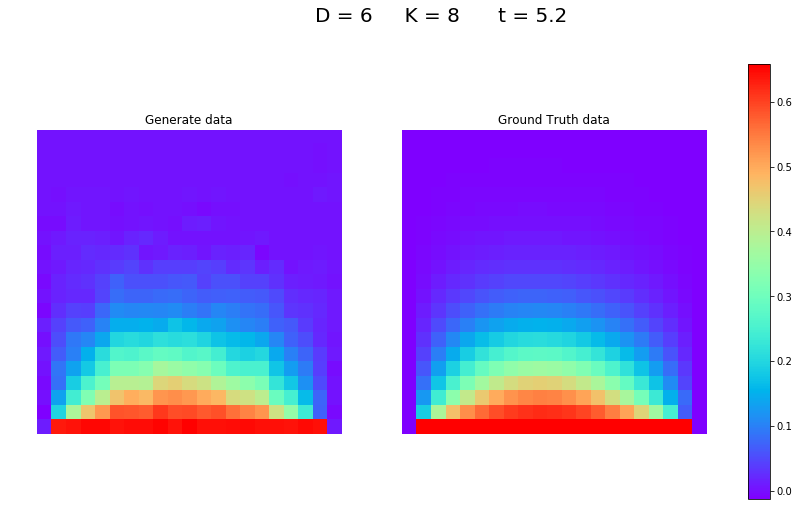

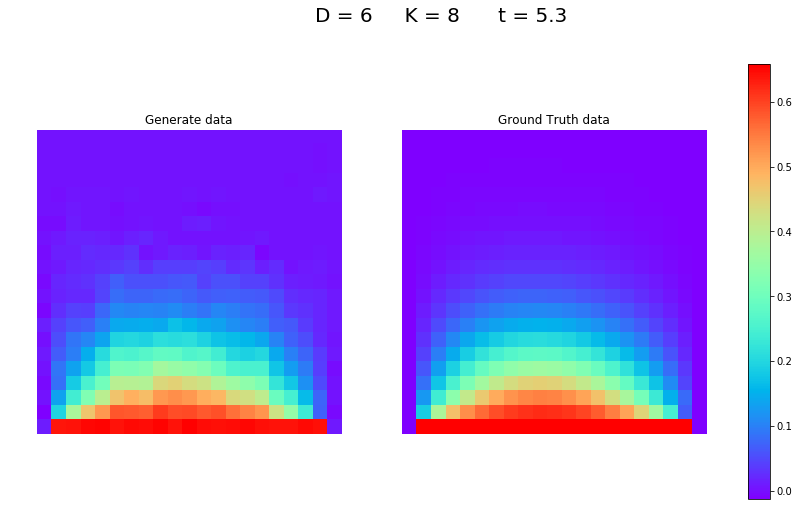

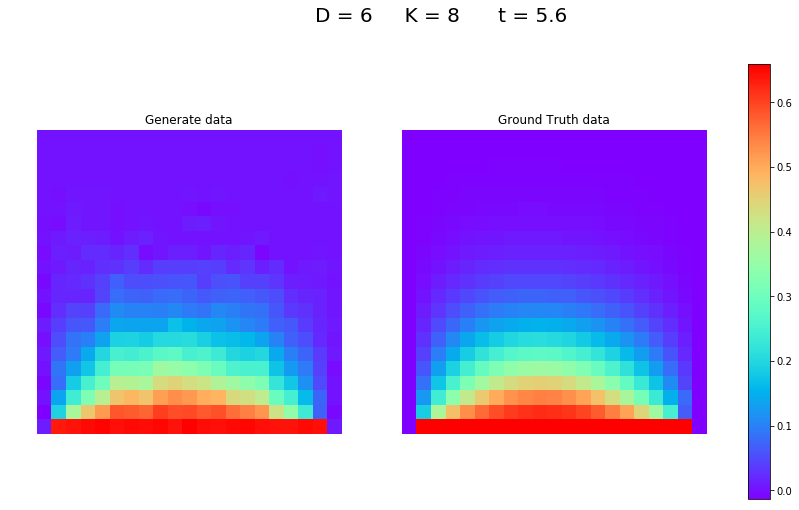

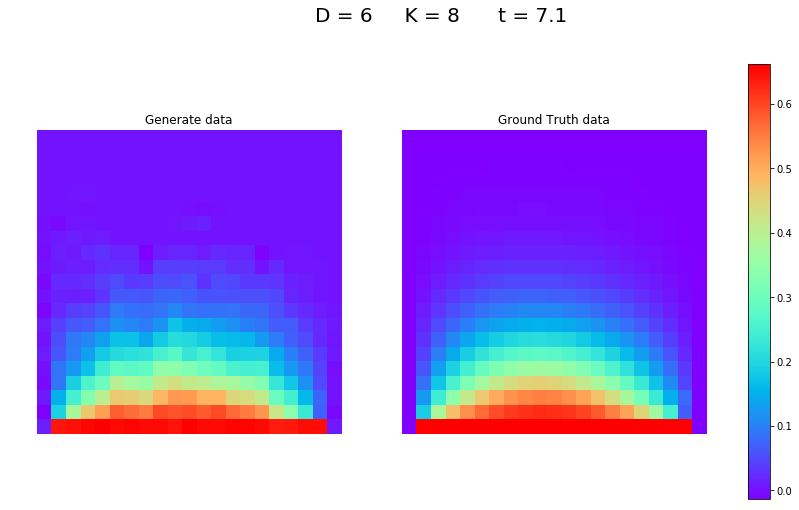

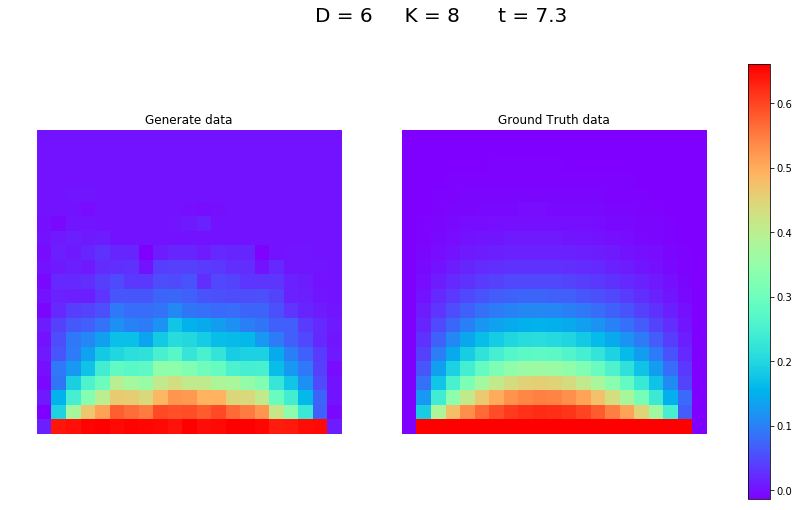

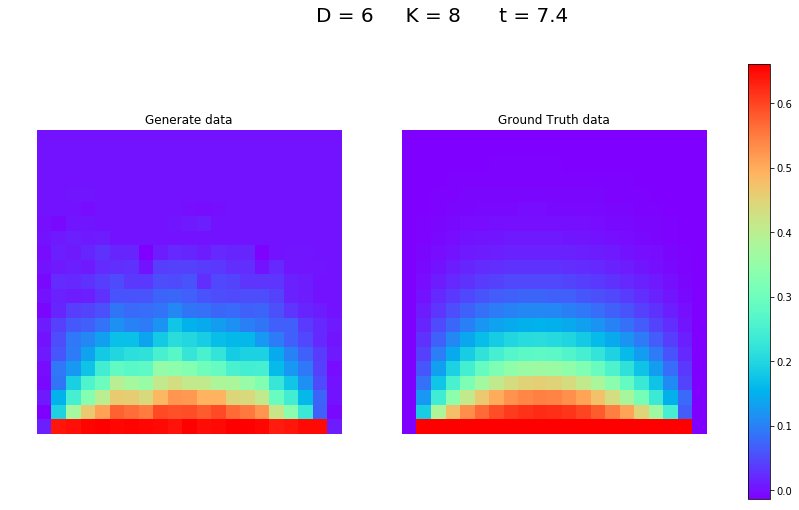

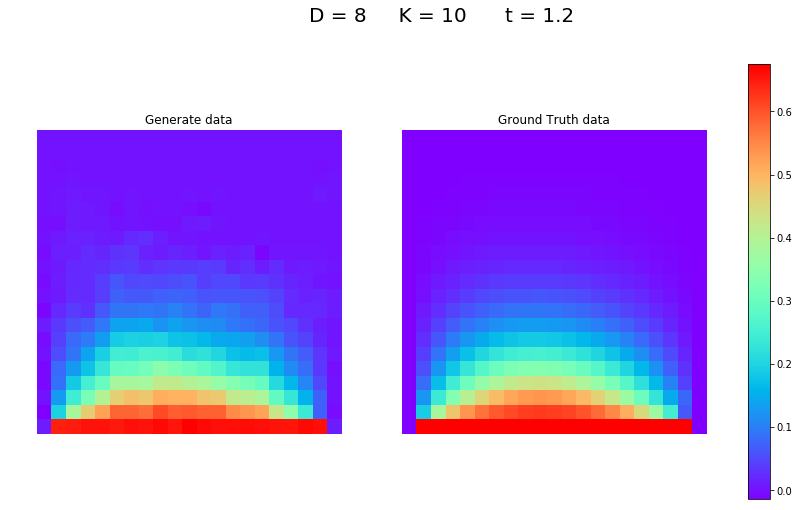

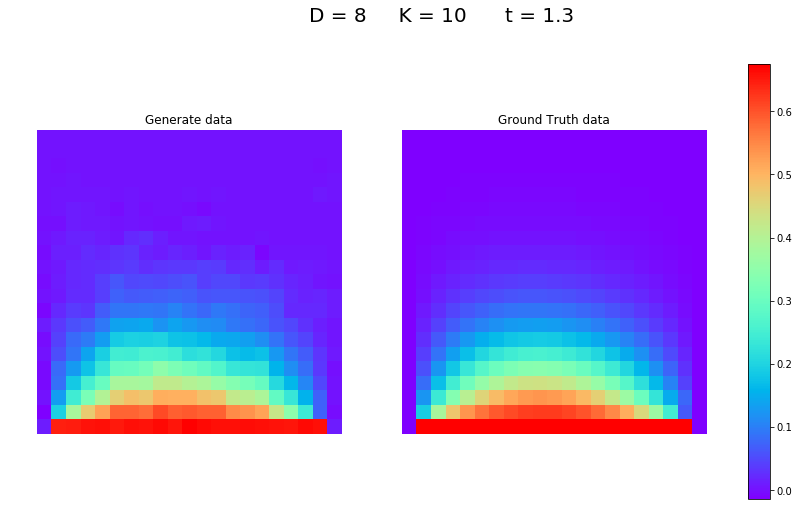

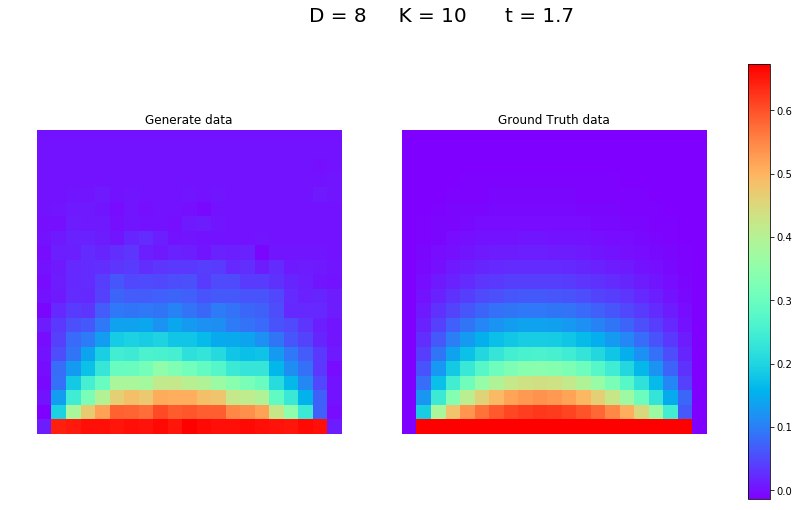

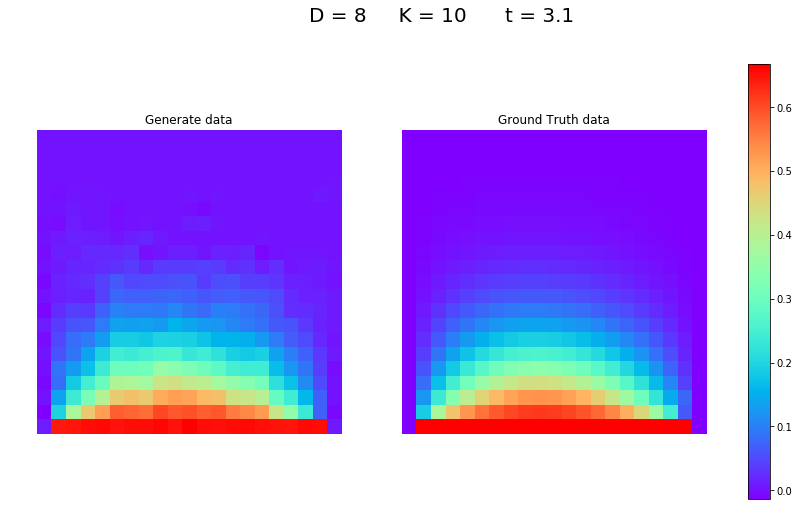

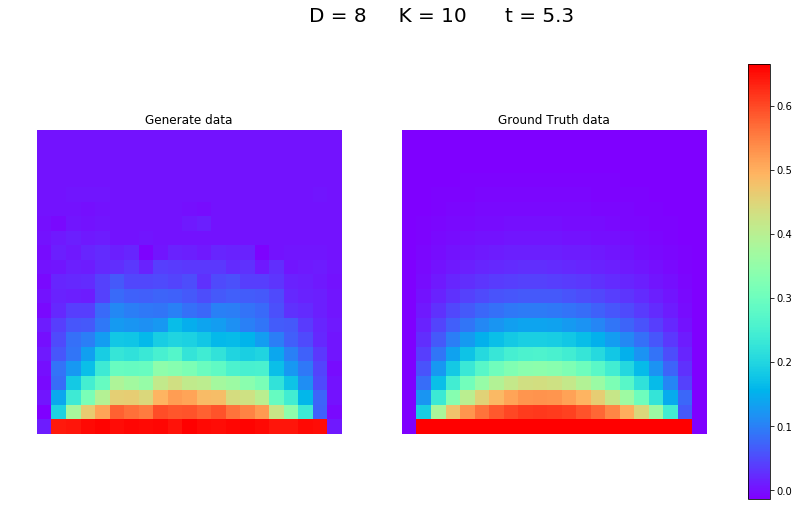

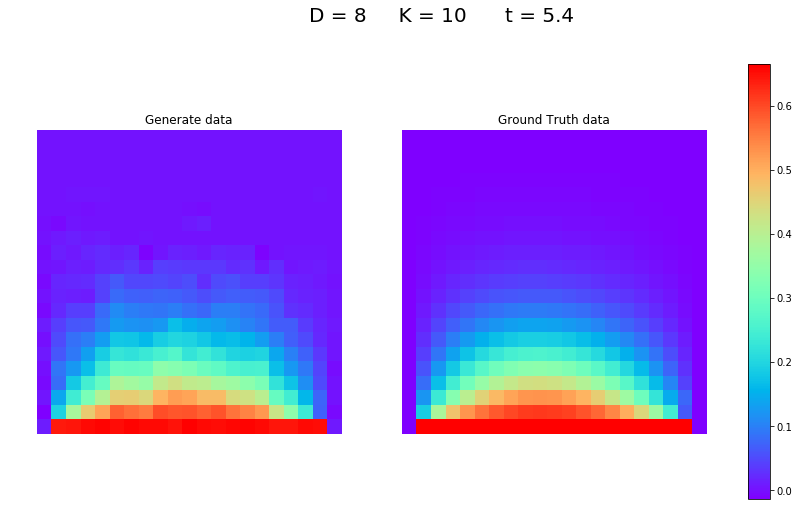

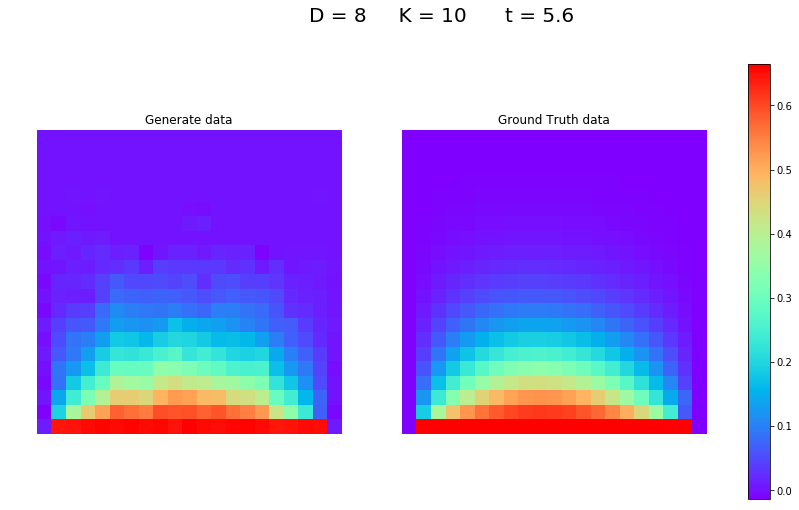

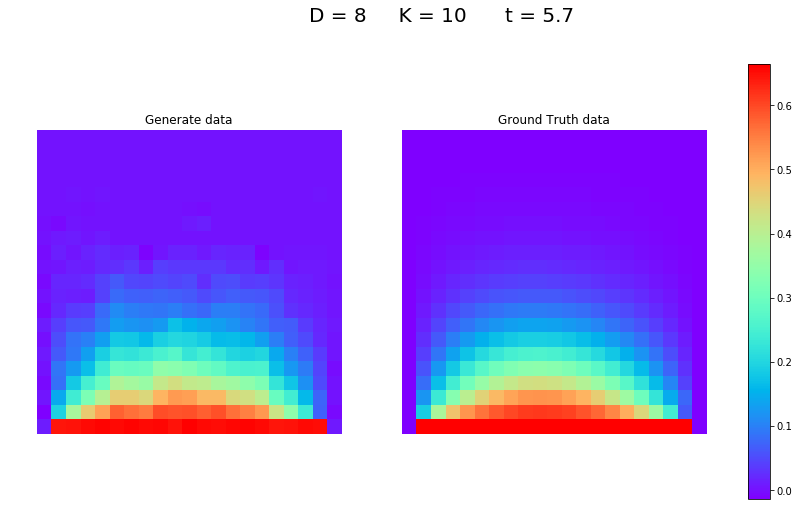

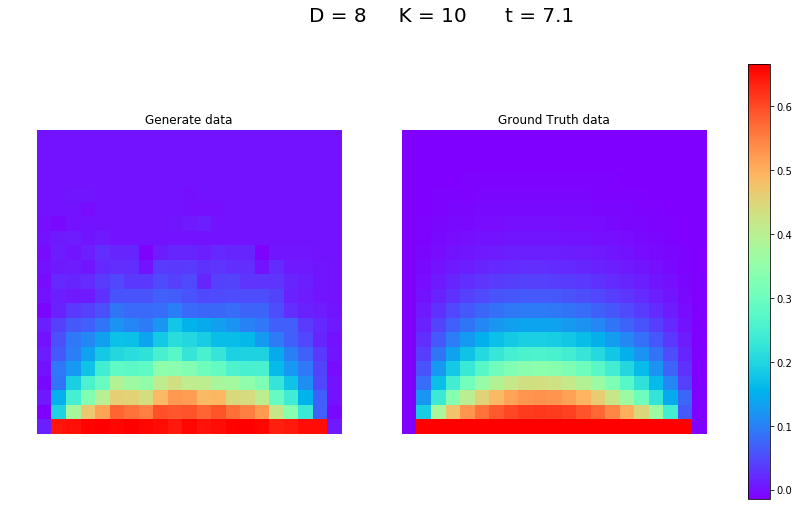

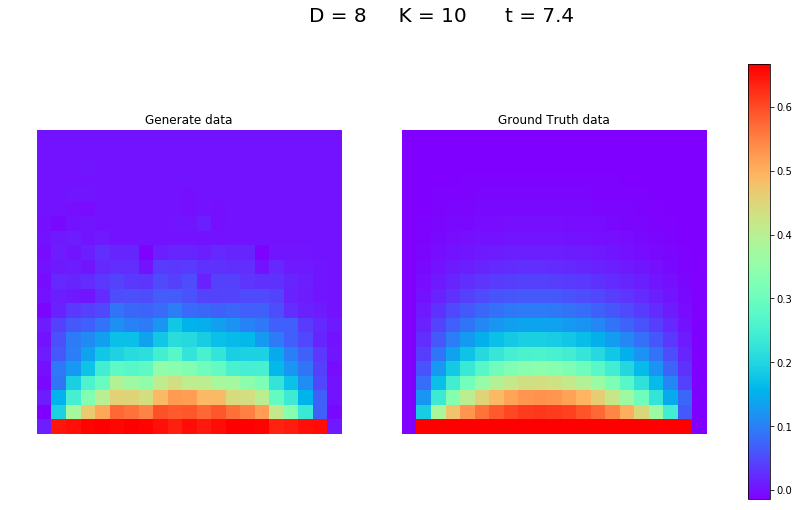

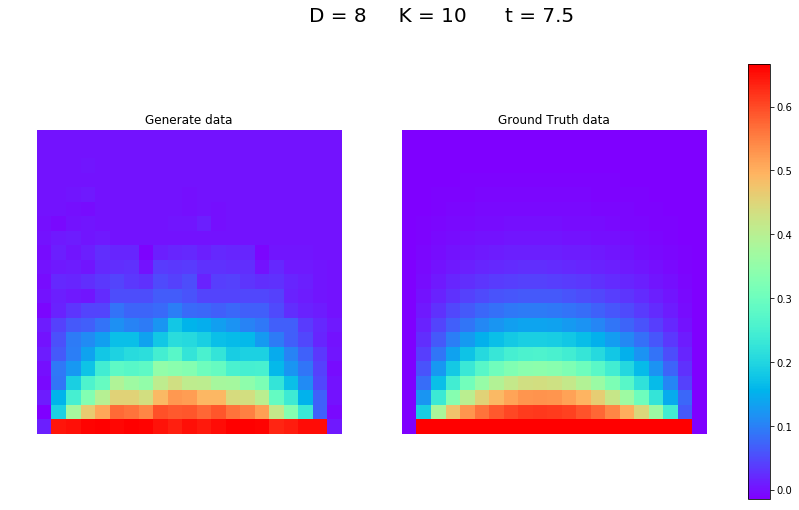

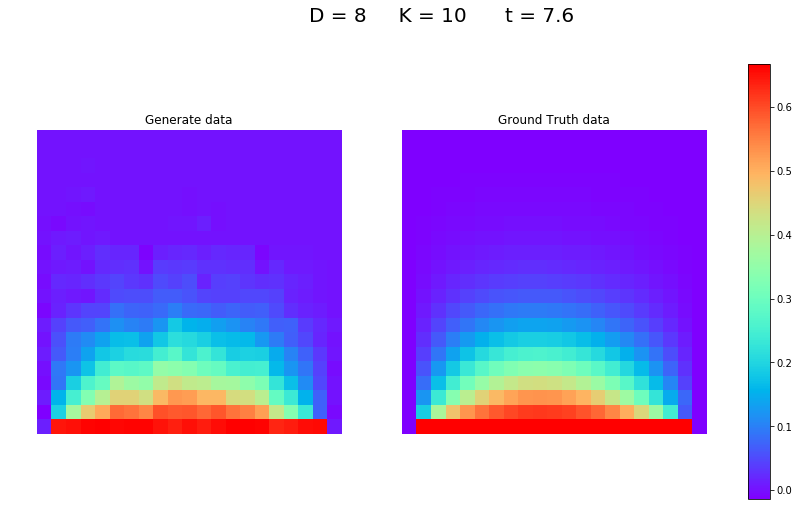

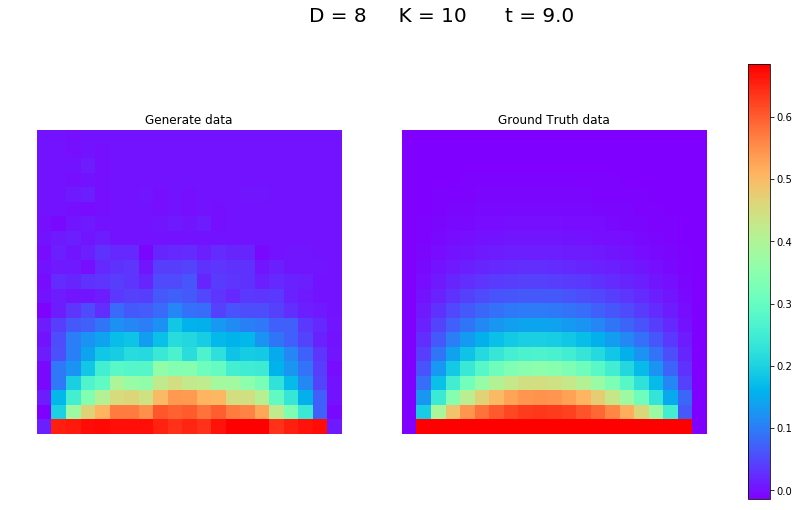

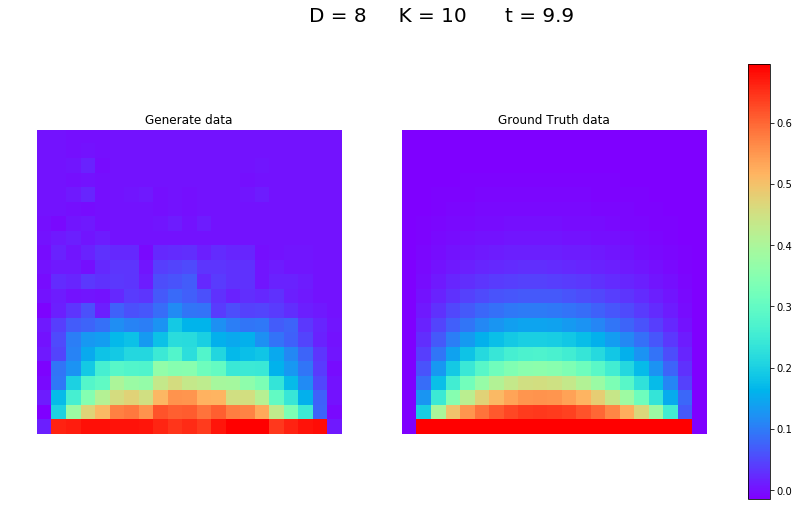

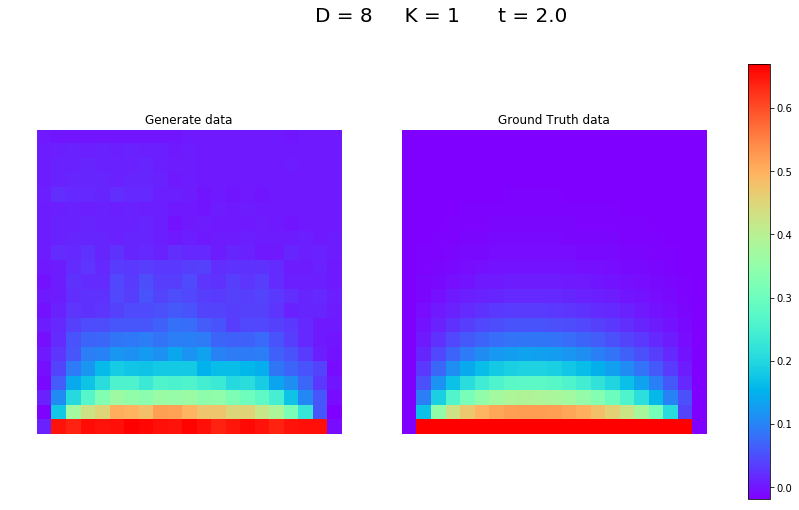

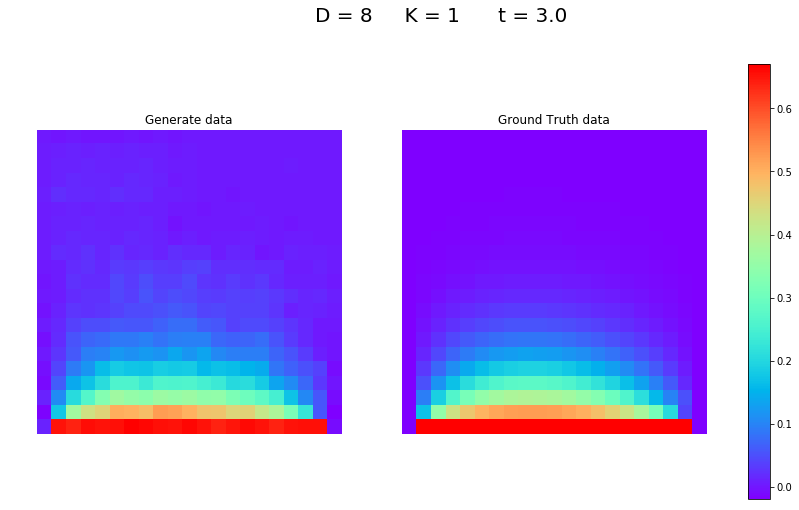

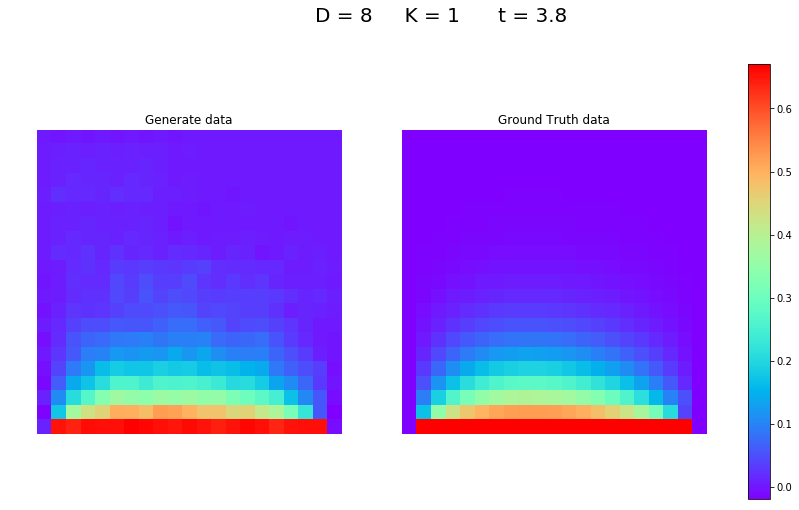

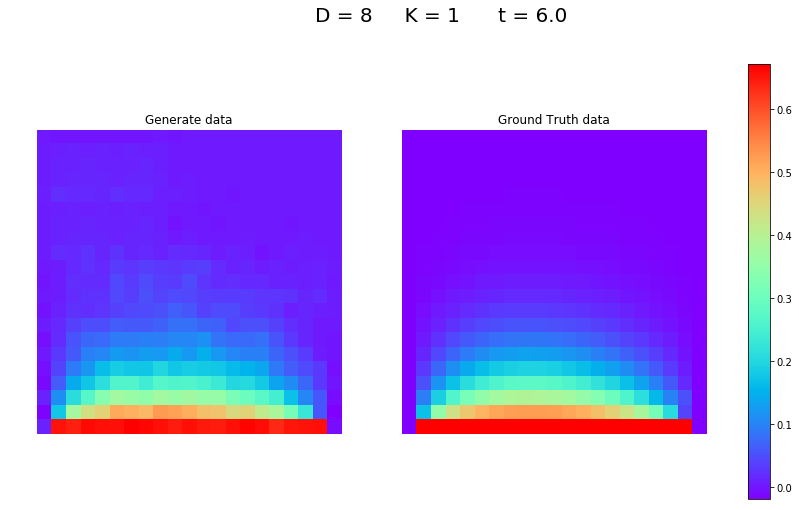

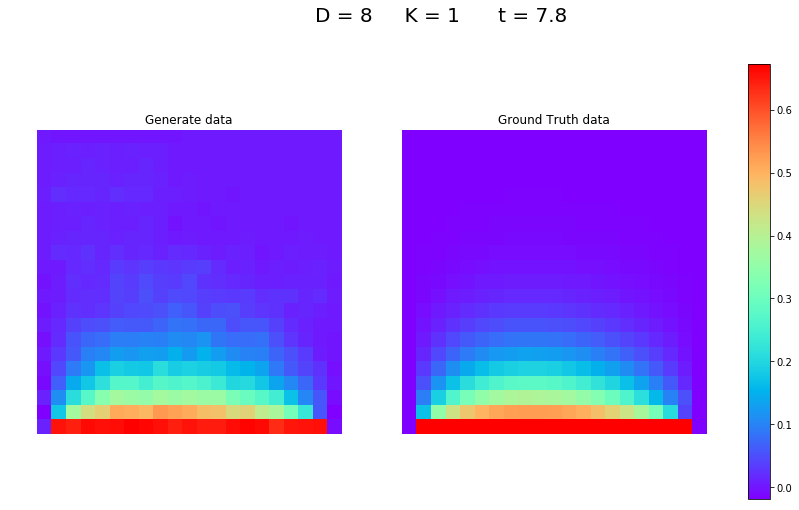

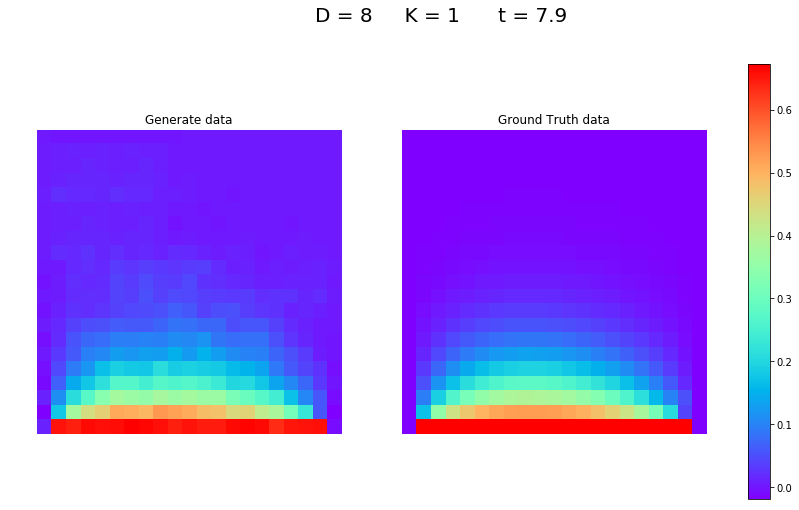

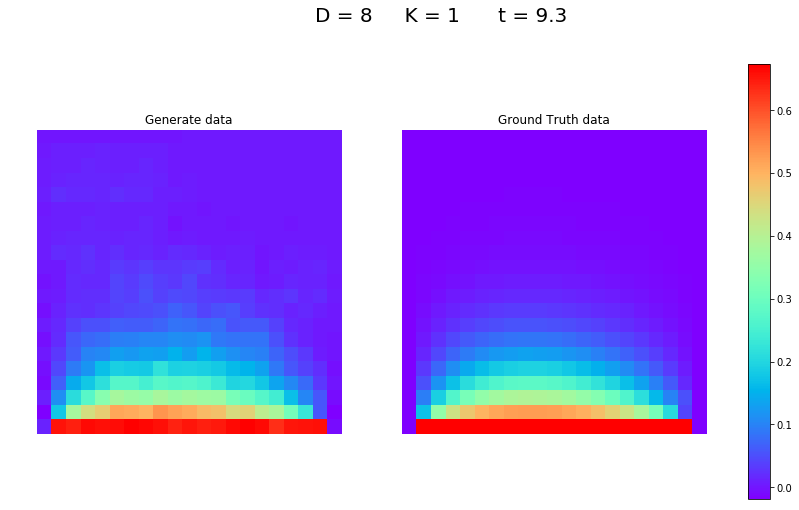

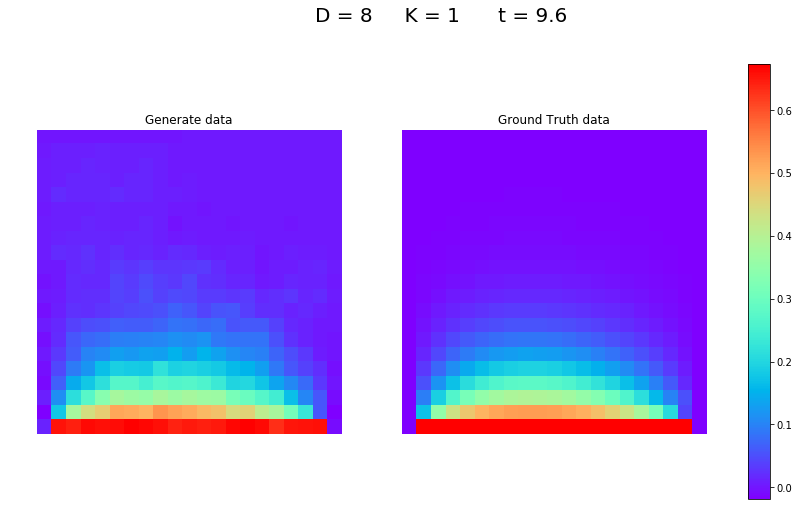

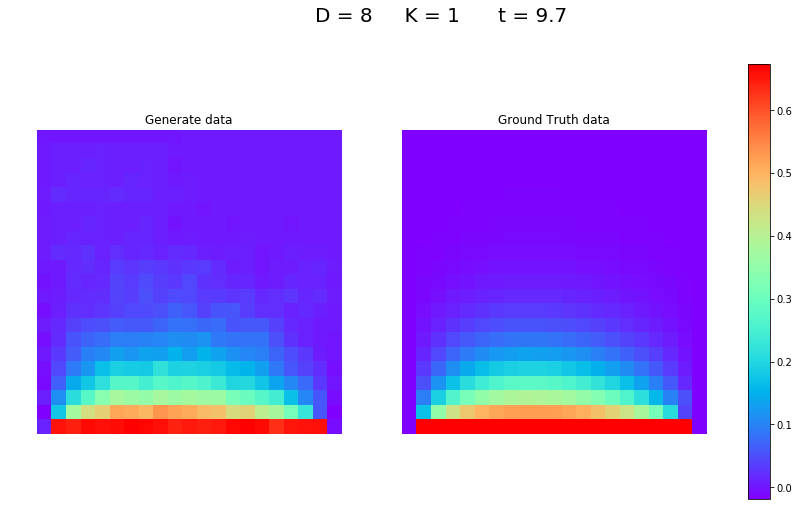

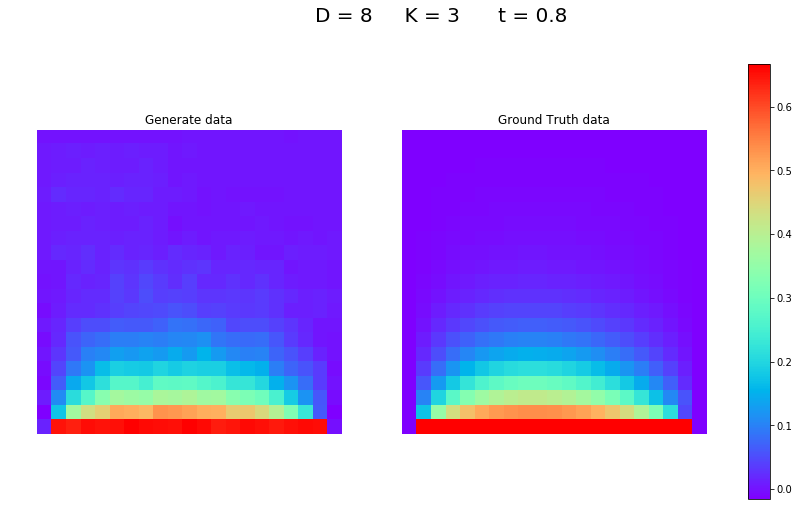

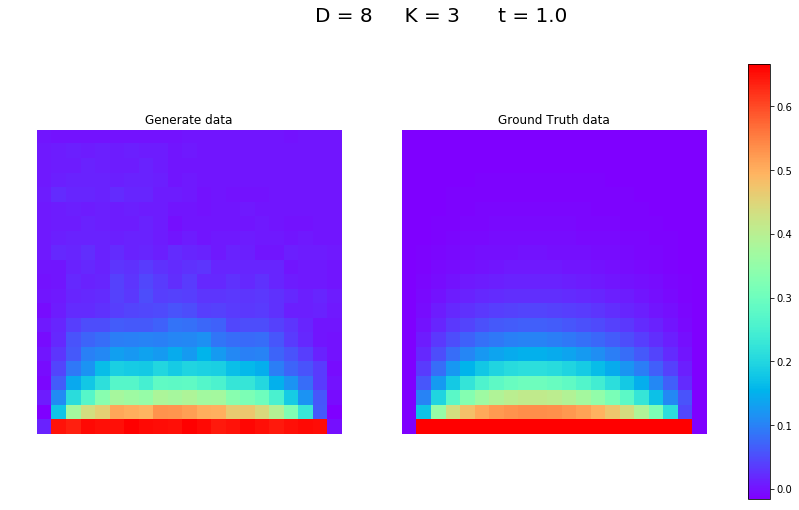

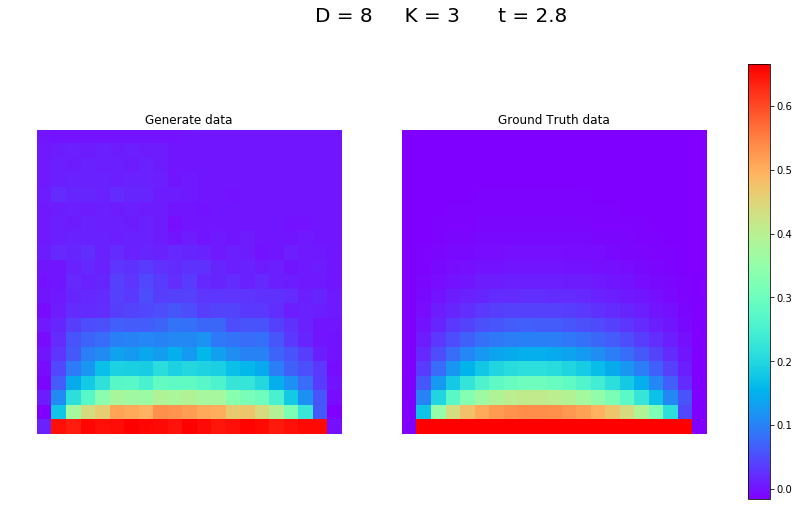

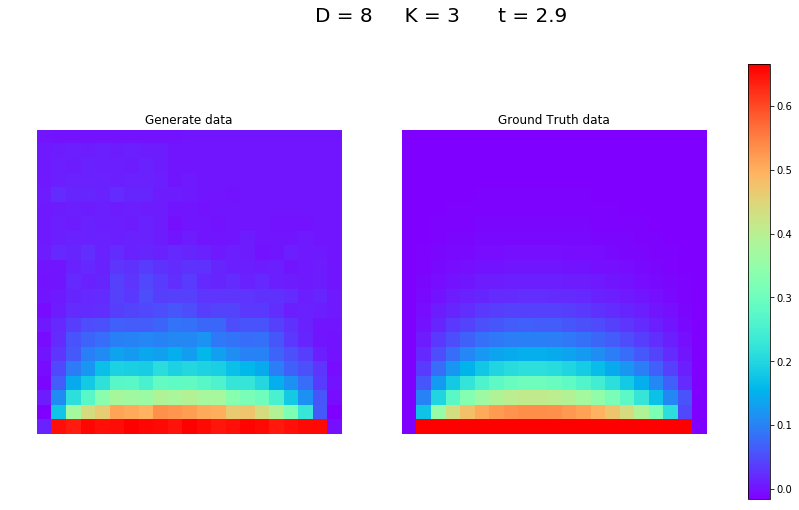

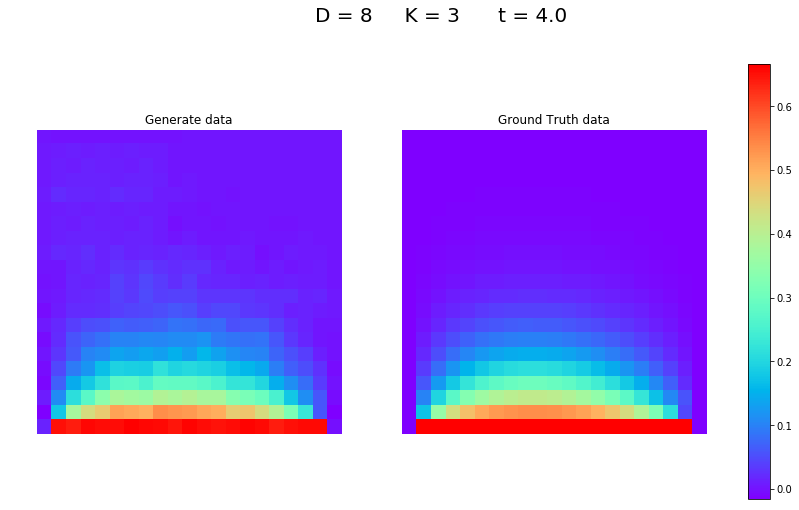

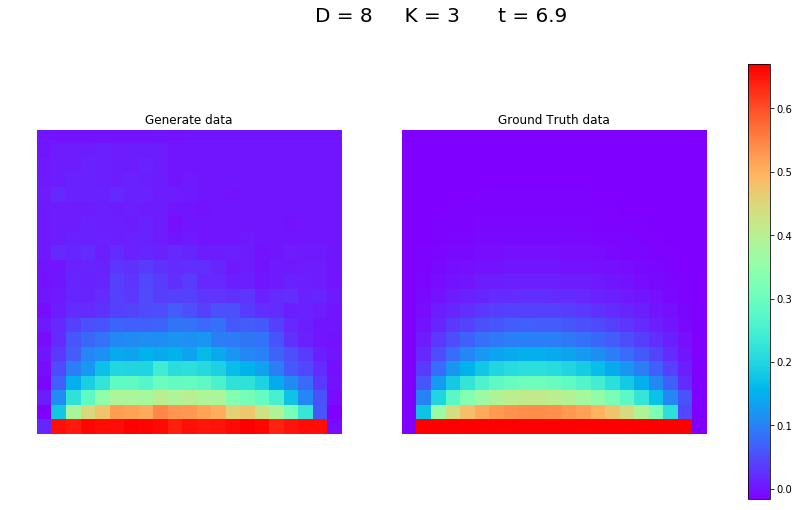

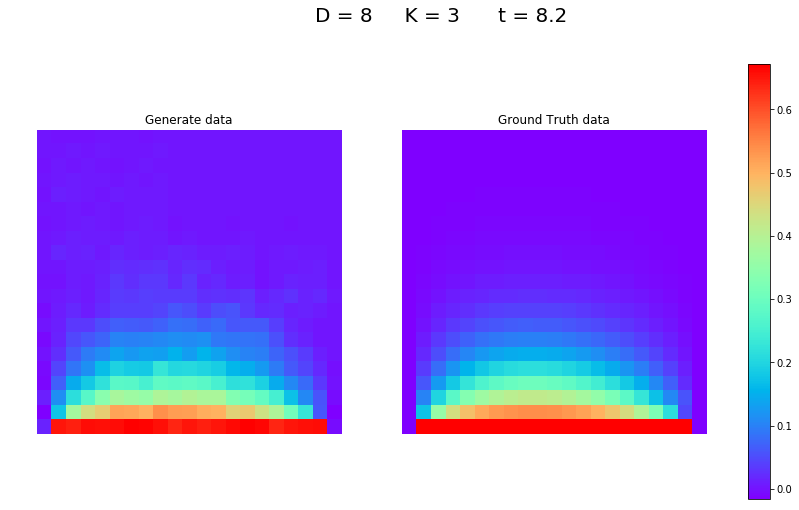

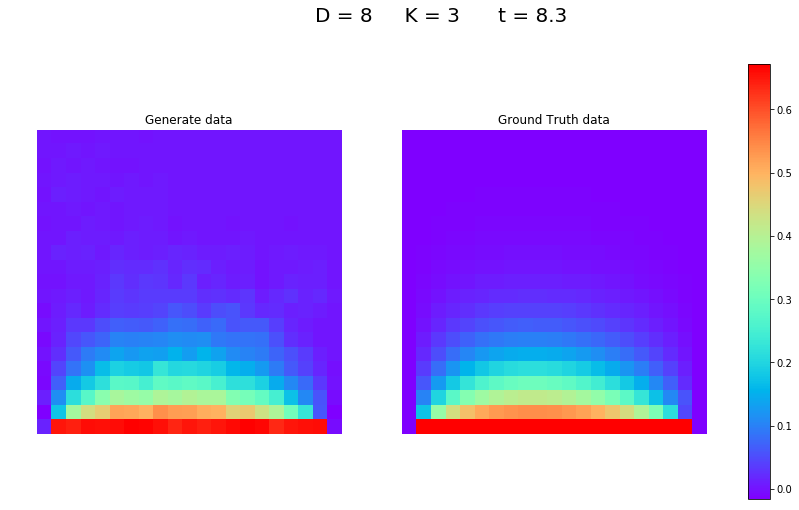

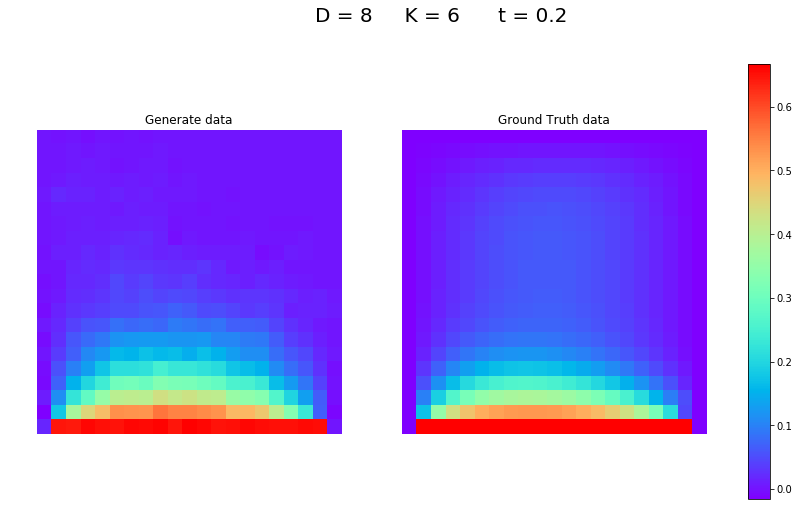

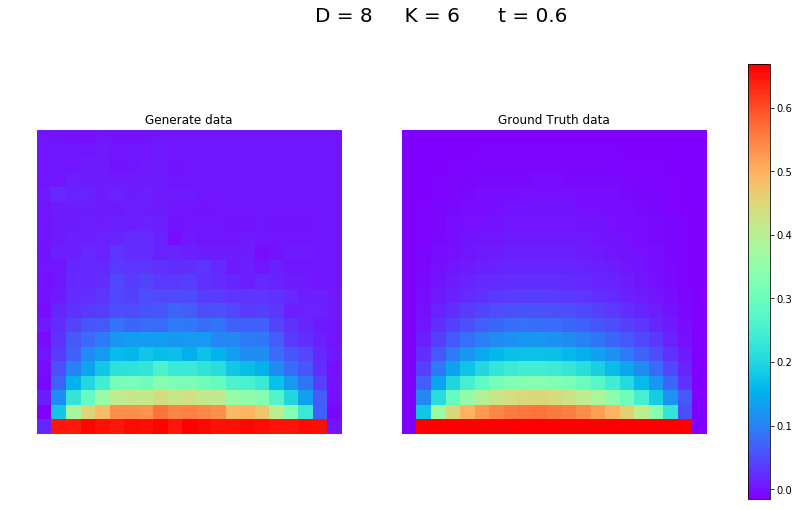

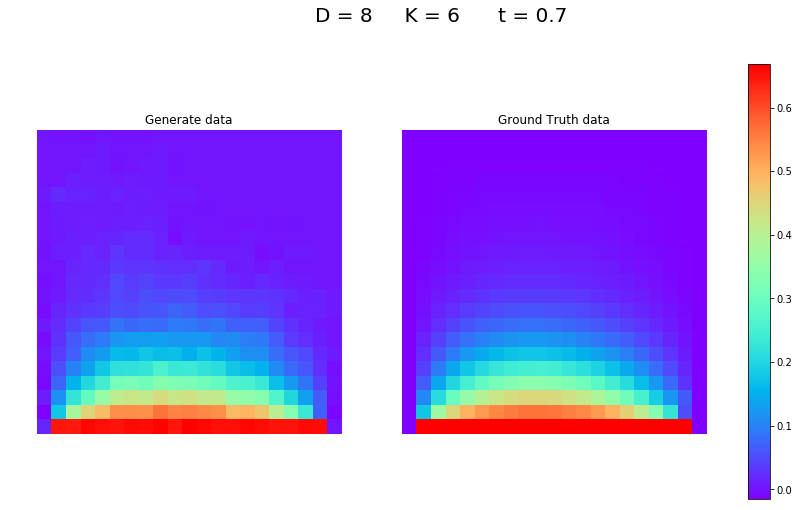

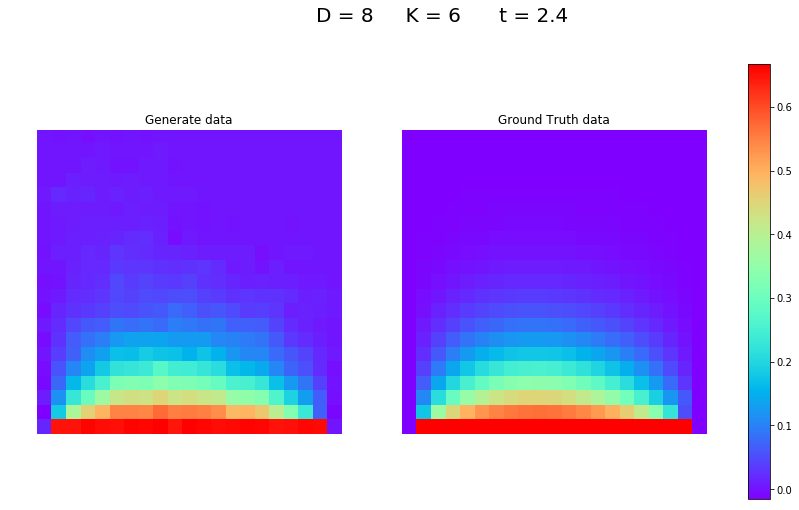

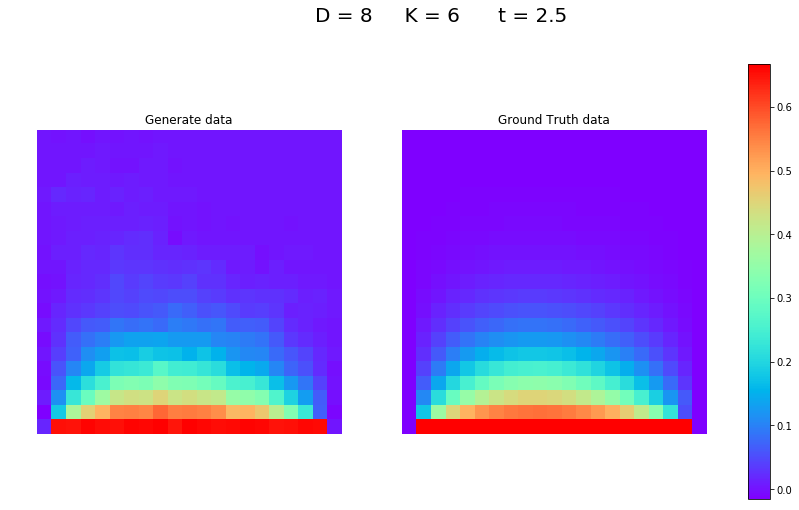

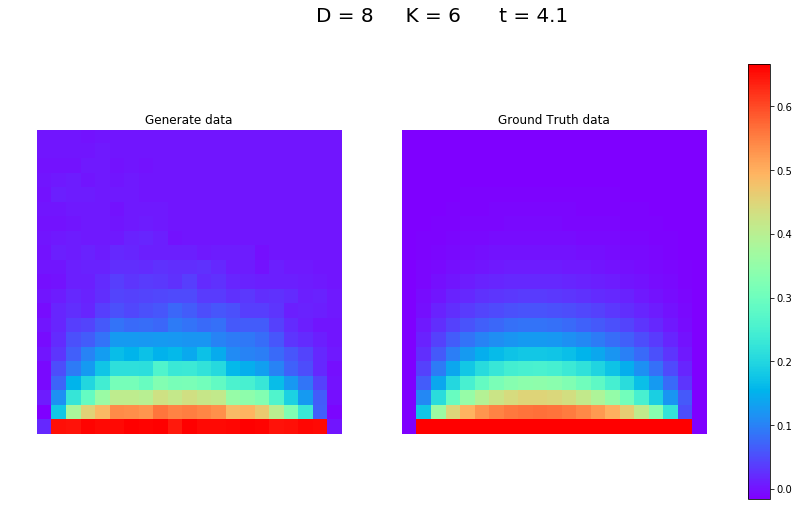

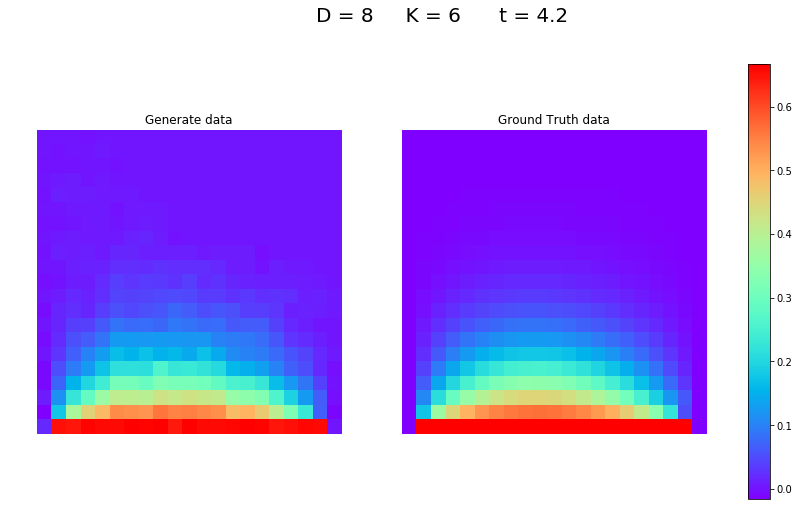

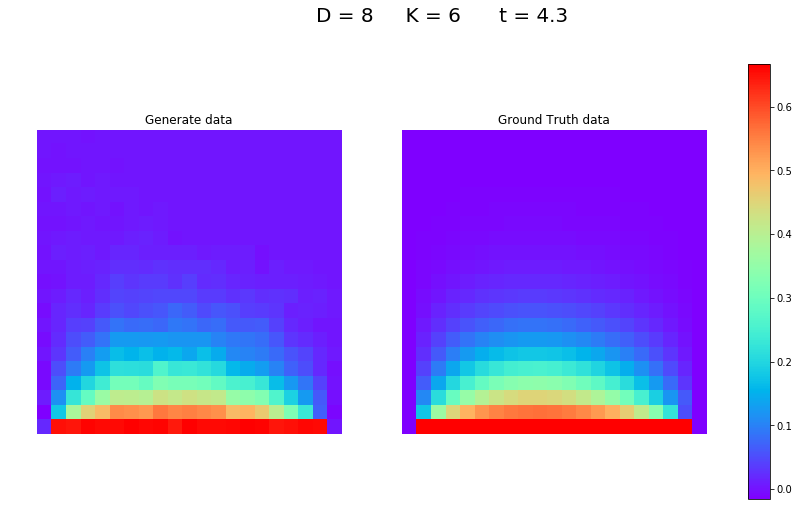

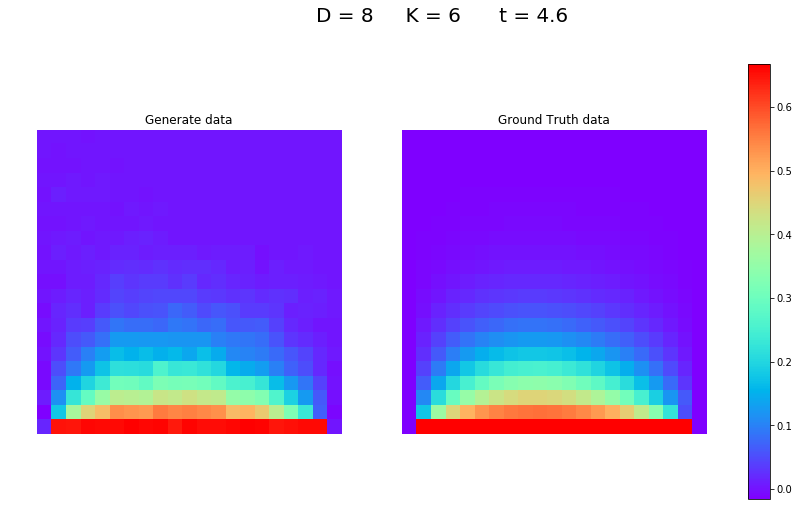

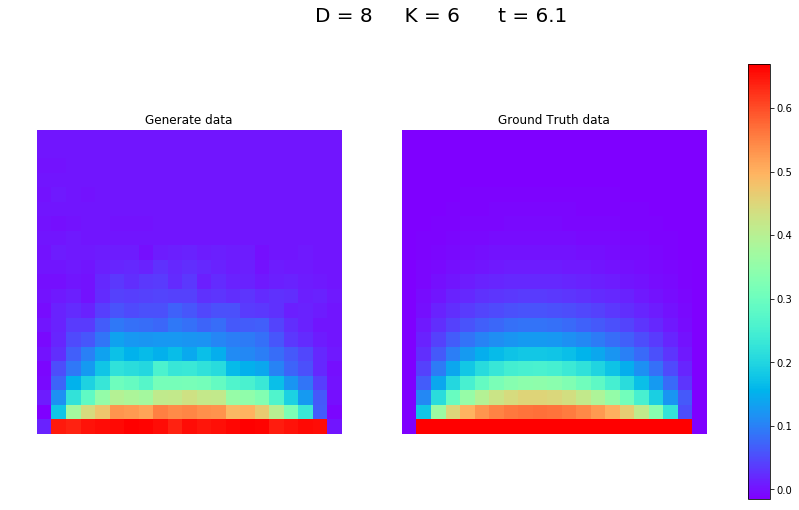

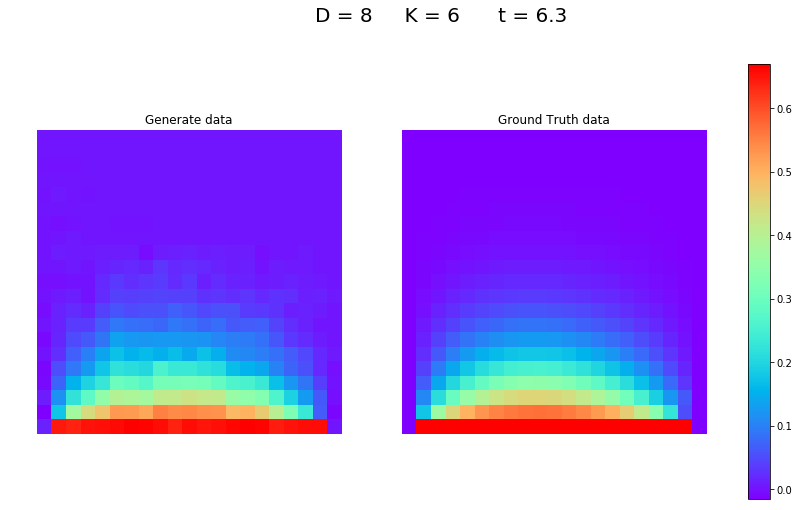

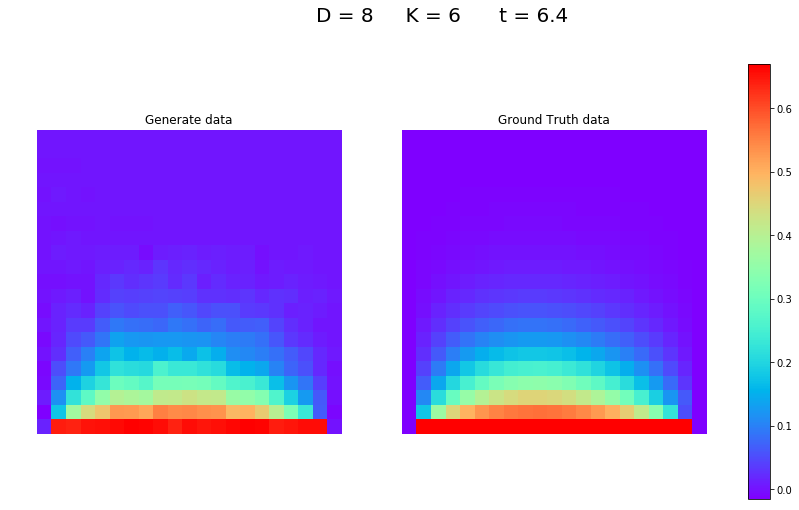

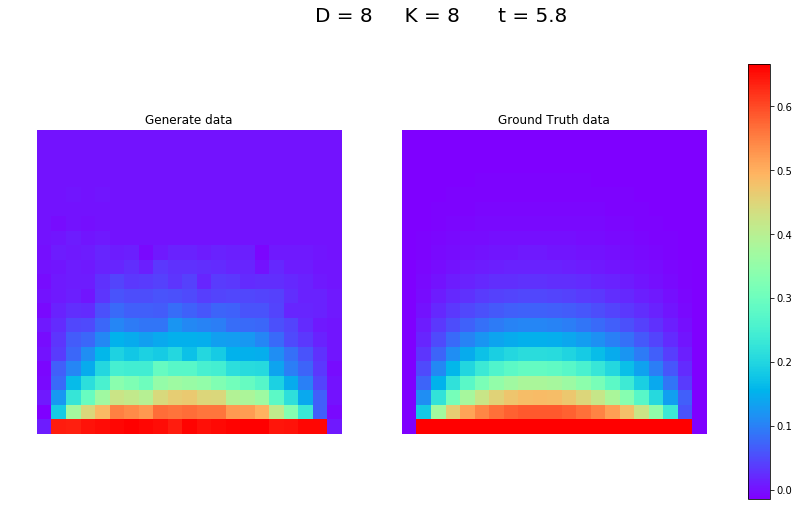

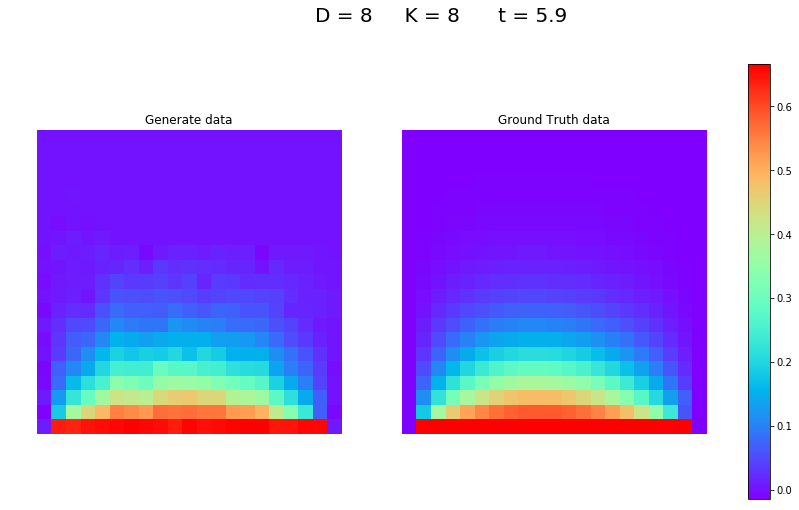

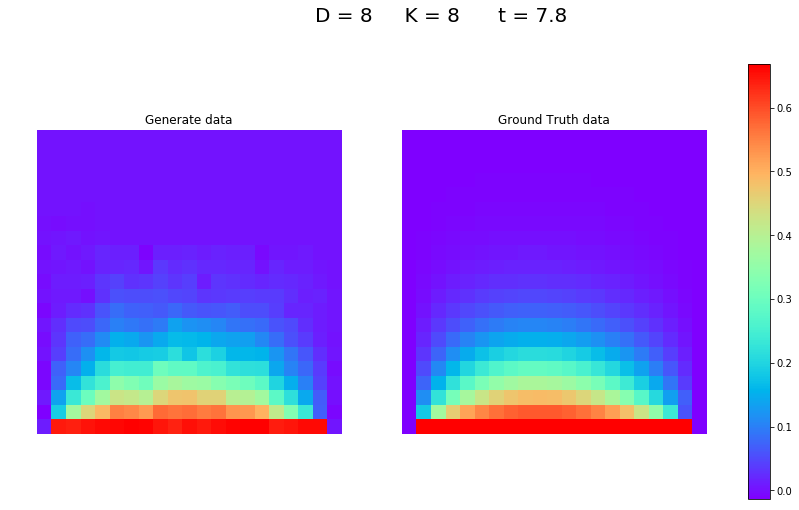

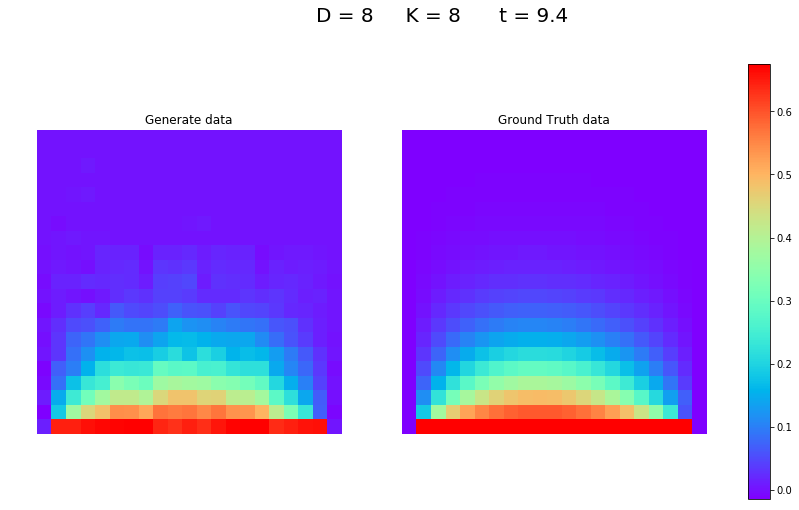

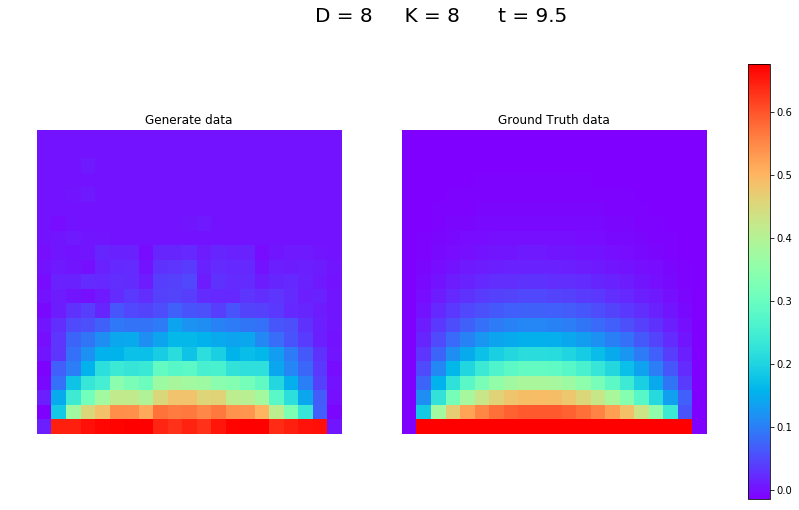

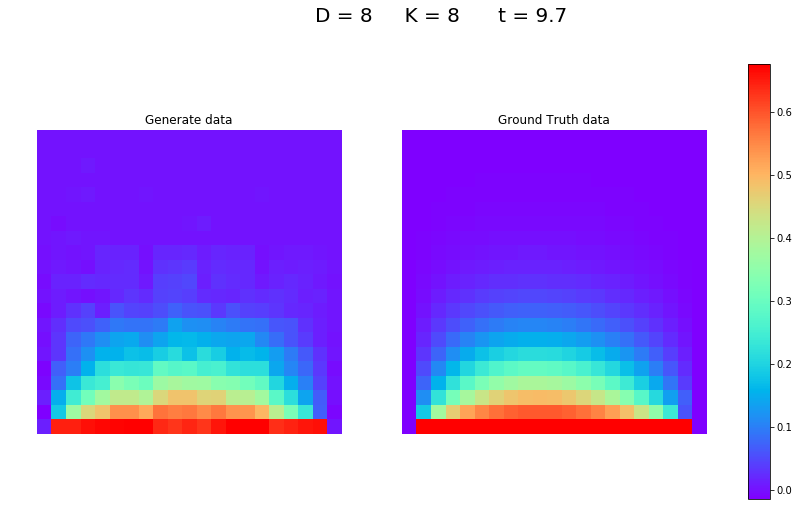

In [146]:
for file in filename_all_test:
    filename = file.split("/")[1]
    plot_contrast(filename)

In [ ]:
read

In [21]:
for filename in filename_all_test:
    print(filename,loss_one_file(filename))

test_txt/mesh_10_10_1.4.txt 0.0006303363888314018
test_txt/mesh_10_10_1.5.txt 0.000633118881219163
test_txt/mesh_10_10_1.7.txt 0.0006376475053105844
test_txt/mesh_10_10_3.2.txt 0.0006836302408795615
test_txt/mesh_10_10_3.5.txt 0.000701064577967365
test_txt/mesh_10_10_3.6.txt 0.0007068512669231483
test_txt/mesh_10_10_3.7.txt 0.0007126600348403643
test_txt/mesh_10_10_5.1.txt 0.0007549580990257869
test_txt/mesh_10_10_5.4.txt 0.0007519614796202495
test_txt/mesh_10_10_7.2.txt 0.0007330221572028212
test_txt/mesh_10_10_7.3.txt 0.0007322002819647767
test_txt/mesh_10_1_1.9.txt 0.0005343396446885268
test_txt/mesh_10_1_5.8.txt 0.0004790630769398641
test_txt/mesh_10_1_5.9.txt 0.00047775543831332136
test_txt/mesh_10_1_9.4.txt 0.0004774013785649367
test_txt/mesh_10_1_9.5.txt 0.0004791815013090932
test_txt/mesh_10_3_0.8.txt 0.0006349116662480233
test_txt/mesh_10_3_0.9.txt 0.0006400405801832754
test_txt/mesh_10_3_2.9.txt 0.0006605422444182182
test_txt/mesh_10_3_4.8.txt 0.0005976052957911563
test_txt/m

test_txt/mesh_8_1_2.0.txt 0.0005510304882925662
test_txt/mesh_8_1_3.0.txt 0.0005426881900377847
test_txt/mesh_8_1_3.8.txt 0.0005370087536779565
test_txt/mesh_8_1_6.0.txt 0.0005234442587580916
test_txt/mesh_8_1_7.8.txt 0.0004725376814702151
test_txt/mesh_8_1_7.9.txt 0.0004698355204654199
test_txt/mesh_8_1_9.3.txt 0.00043404700806445705
test_txt/mesh_8_1_9.6.txt 0.0004278039709980426
test_txt/mesh_8_1_9.7.txt 0.00042588792538987097
test_txt/mesh_8_3_0.8.txt 0.0006890493371843342
test_txt/mesh_8_3_1.0.txt 0.0006989446050845261
test_txt/mesh_8_3_2.8.txt 0.0006776354605581747
test_txt/mesh_8_3_2.9.txt 0.0006736790388712603
test_txt/mesh_8_3_4.0.txt 0.0006310735968544054
test_txt/mesh_8_3_6.9.txt 0.0005266589972942544
test_txt/mesh_8_3_8.2.txt 0.0004896909399944181
test_txt/mesh_8_3_8.3.txt 0.0004869258516166165
test_txt/mesh_8_6_0.2.txt 0.0011012138889166126
test_txt/mesh_8_6_0.6.txt 0.0006643461935902334
test_txt/mesh_8_6_0.7.txt 0.0007021383240433751
test_txt/mesh_8_6_2.4.txt 0.0007589460

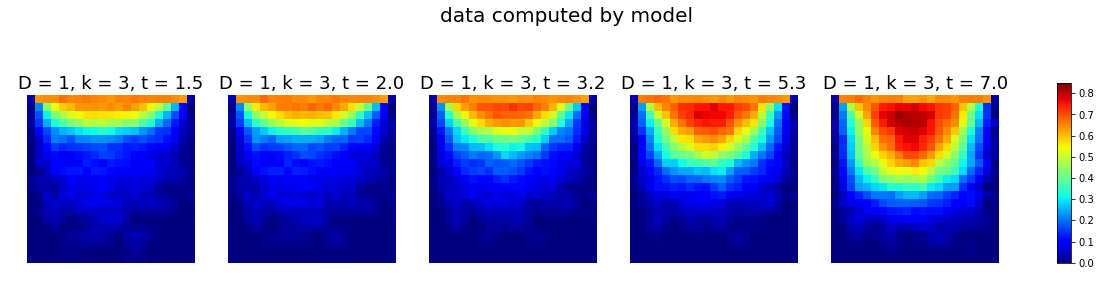

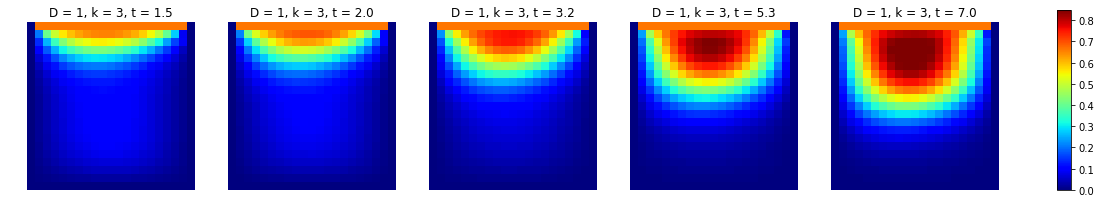

In [163]:
d = "1"
k = "3"
t = ["1.5","2.0","3.2","5.3","7.0"]
Plot_map(d,k,t)

In [170]:
for filename in filename_all_test:
    print(filename,loss_one_file(filename))

test_txt/mesh_10_10_1.4.txt 0.0006303363888314018
test_txt/mesh_10_10_1.5.txt 0.000633118881219163
test_txt/mesh_10_10_1.7.txt 0.0006376475053105844
test_txt/mesh_10_10_3.2.txt 0.0006836302408795615
test_txt/mesh_10_10_3.5.txt 0.000701064577967365
test_txt/mesh_10_10_3.6.txt 0.0007068512669231483
test_txt/mesh_10_10_3.7.txt 0.0007126600348403643
test_txt/mesh_10_10_5.1.txt 0.0007549580990257869
test_txt/mesh_10_10_5.4.txt 0.0007519614796202495
test_txt/mesh_10_10_7.2.txt 0.0007330221572028212
test_txt/mesh_10_10_7.3.txt 0.0007322002819647767
test_txt/mesh_10_1_1.9.txt 0.0005343396446885268
test_txt/mesh_10_1_5.8.txt 0.0004790630769398641
test_txt/mesh_10_1_5.9.txt 0.00047775543831332136
test_txt/mesh_10_1_9.4.txt 0.0004774013785649367
test_txt/mesh_10_1_9.5.txt 0.0004791815013090932
test_txt/mesh_10_3_0.8.txt 0.0006349116662480233
test_txt/mesh_10_3_0.9.txt 0.0006400405801832754
test_txt/mesh_10_3_2.9.txt 0.0006605422444182182
test_txt/mesh_10_3_4.8.txt 0.0005976052957911563
test_txt/m

test_txt/mesh_8_10_5.4.txt 0.0008497720763222989
test_txt/mesh_8_10_5.6.txt 0.0008513680292614467
test_txt/mesh_8_10_5.7.txt 0.0008522416969049613
test_txt/mesh_8_10_7.1.txt 0.0008934513022715265
test_txt/mesh_8_10_7.4.txt 0.0009004081866964384
test_txt/mesh_8_10_7.5.txt 0.0009024366064117068
test_txt/mesh_8_10_7.6.txt 0.0009044928096009457
test_txt/mesh_8_10_9.0.txt 0.0009354177822536473
test_txt/mesh_8_10_9.9.txt 0.0009291883155006563
test_txt/mesh_8_1_2.0.txt 0.0005510304882925662
test_txt/mesh_8_1_3.0.txt 0.0005426881900377847
test_txt/mesh_8_1_3.8.txt 0.0005370087536779565
test_txt/mesh_8_1_6.0.txt 0.0005234442587580916
test_txt/mesh_8_1_7.8.txt 0.0004725376814702151
test_txt/mesh_8_1_7.9.txt 0.0004698355204654199
test_txt/mesh_8_1_9.3.txt 0.00043404700806445705
test_txt/mesh_8_1_9.6.txt 0.0004278039709980426
test_txt/mesh_8_1_9.7.txt 0.00042588792538987097
test_txt/mesh_8_3_0.8.txt 0.0006890493371843342
test_txt/mesh_8_3_1.0.txt 0.0006989446050845261
test_txt/mesh_8_3_2.8.txt 0.0

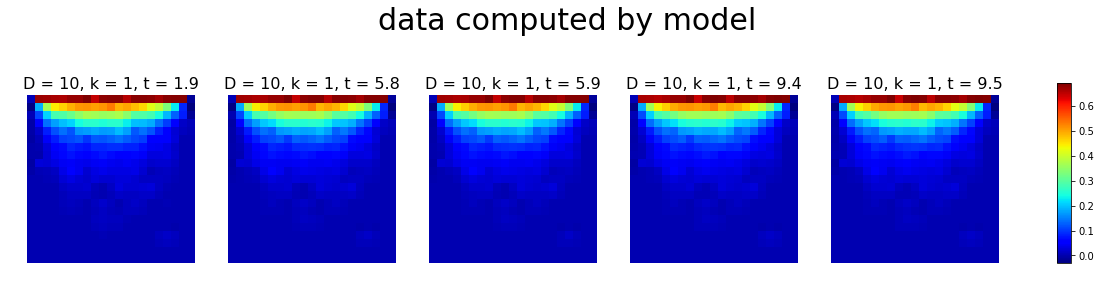

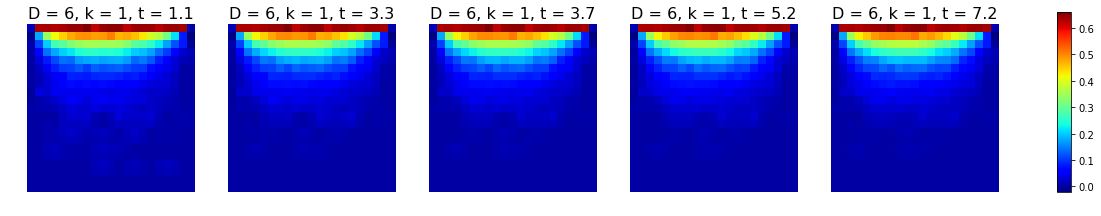

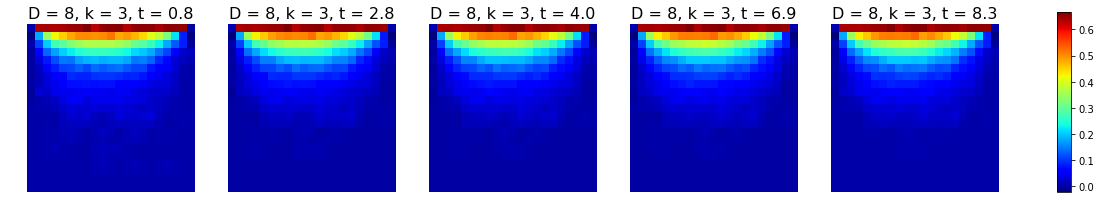

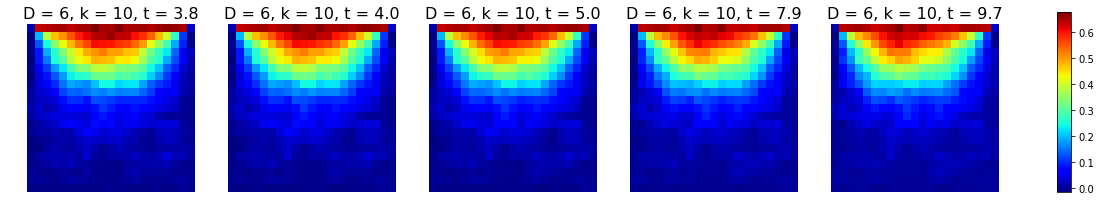

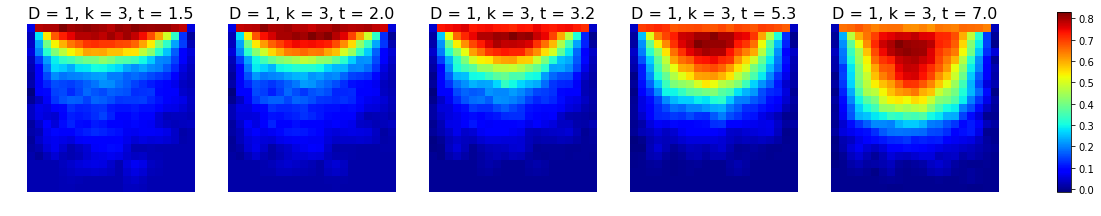

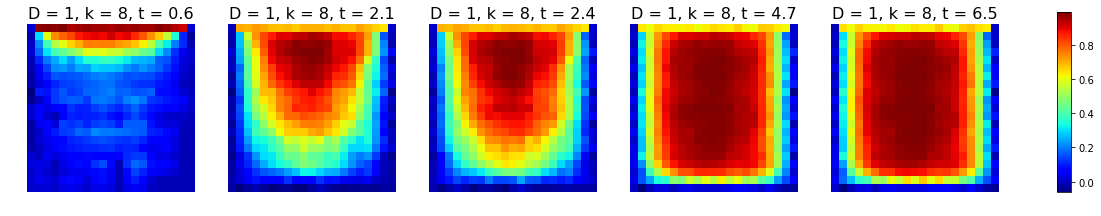

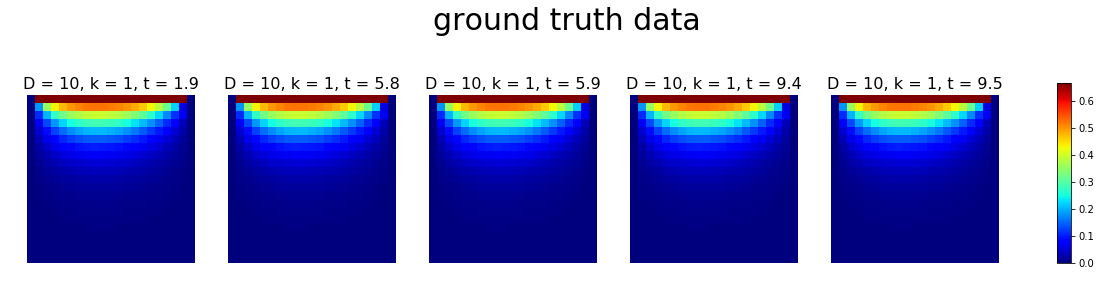

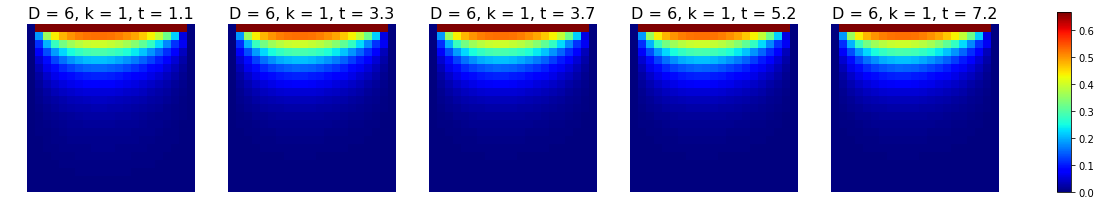

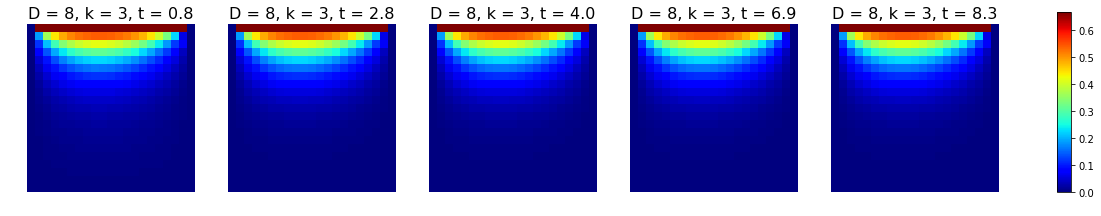

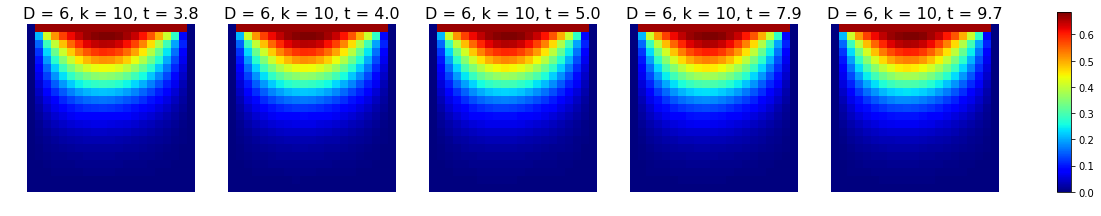

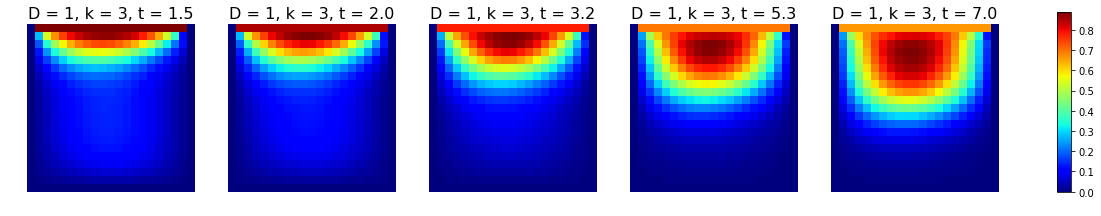

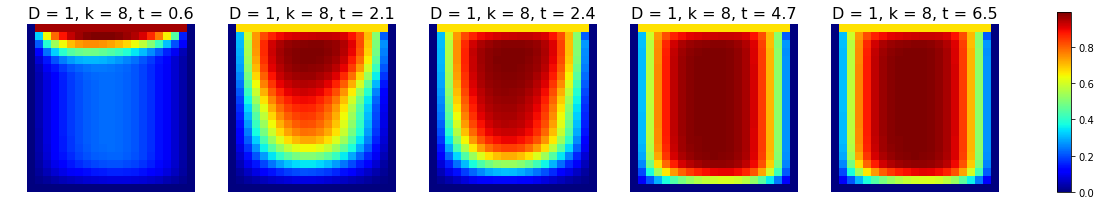

In [172]:
## d/k=10
d1 = "10"
k1 = "1"
t1 = ["1.9","5.8","5.9","9.4","9.5"]

## d/k = 6
d2 = "6"
k2 = "1"
t2 = ["1.1","3.3","3.7","5.2","7.2"]


## d/k = 2.67
d3 = "8"
k3 = "3"
t3 = ["0.8","2.8","4.0","6.9","8.3"]

## d/k=0.6
d4 = "6"
k4 = "10"
t4 = ["3.8","4.0","5.0","7.9","9.7"]

## d/k = 0.33
d5 = "1"
k5 = "3"
t5 = ["1.5","2.0","3.2","5.3","7.0"]

## d/k = 0.125
d6 = "1"
k6 = "8"
t6 = ["0.6","2.1","2.4","4.7","6.5"]

# v_min = 0.0
# v_max = 0.85
# ,vmin=v_min, vmax=v_max
f = []

for t_e in t1:
    f.append("test_txt/mesh_"+d1+"_"+k1+"_"+t_e+".txt")
    
for t_e in t2:
    f.append("test_txt/mesh_"+d2+"_"+k2+"_"+t_e+".txt")
    
for t_e in t3:
    f.append("test_txt/mesh_"+d3+"_"+k3+"_"+t_e+".txt")
    
for t_e in t4:
    f.append("test_txt/mesh_"+d4+"_"+k4+"_"+t_e+".txt")
    
for t_e in t5:
    f.append("test_txt/mesh_"+d5+"_"+k5+"_"+t_e+".txt")
    
for t_e in t6:
    f.append("test_txt/mesh_"+d6+"_"+k6+"_"+t_e+".txt")

list_t = []    
list_r = []


for i in f:
    filename = i.split("/")[1]
    list_t.append(readFileasArray("test_txt/"+filename))
    f_l = filename.split(".")
    if f_l[1] == "0":
        new_name = f_l[0] + "." + f_l[2]
        list_r.append(readFileasArray("traindata/"+new_name))
    else:
        list_r.append(readFileasArray("traindata/"+filename))

        
# -------------------- train-1 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    
    im = ax[i].imshow(list_t[i][::-1],cmap = "jet")
    
    ax[i].axis('off')
    ax[i].set_title("D = "+d1+", k = "+k1+", t = "+t1[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle("data computed by model", fontsize=30)
# plt.savefig("1.pdf")
plt.show()


# -------------------- train-2 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+5][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d2+", k = " + k2 + ", t = "+t2[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- train-3 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+10][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+ d3 +", k = " + k3 +", t = "+t3[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- train-4 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+15][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+ d4 +", k = "+ k4 +", t = "+t4[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- train-5 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+20][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d5+", k = "+k5+", t = "+t5[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- train-6 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i+25][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d6+", k = "+k6+", t = "+t6[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- truth-1 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
fig.subplots_adjust(right=0.8)
for i in range(5):
    im = ax[i].imshow(list_r[i][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d1+", k = "+k1+", t = "+t1[i],size=16)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle("ground truth data", fontsize=30)
plt.savefig("2.pdf")
plt.show()


# -------------------- truth-2 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+5][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d2+", k = "+k2+", t = "+t2[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- truth-3 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+10][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d3+", k = "+k3+", t = "+t3[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- train-4 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+15][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d4+", k = "+k4+", t = "+t4[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# -------------------- train-5 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+20][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d5+", k = "+k5+", t = "+t5[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

# plt.savefig("1.pdf")
plt.show()

# -------------------- truth-6 -------------------------#
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_r[i+25][::-1],cmap = "jet")
    ax[i].axis('off')
    ax[i].set_title("D = "+d6+", k = "+k6+", t = "+t6[i],size=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()


In [ ]:
d = "10"
k = "1"
t = ["1.9","5.8","5.9","9.4","9.5"]



fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(list_t[i][::-1],cmap = "jet",vmin=v_min, vmax=v_max)
    ax[i].axis('off')
    ax[i].set_title("D = "+d+", k = "+k+", t = "+t[i],size=18)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)
#     fig.colorbar(im,fraction=0.046, pad=0.04)
#     fig.colorbar(im, ax=ax[-1])

fig.suptitle("data computed by model", fontsize=20)
plt.savefig("1.pdf")
plt.show()

fig, ax = plt.subplots(1,5, figsize=(20,5))
fig.subplots_adjust(right=0.8)
for i in range(5):
    im = ax[i].imshow(list_r[i][::-1],cmap = "jet",vmin=v_min, vmax=v_max)
    ax[i].axis('off')
    ax[i].set_title("D = "+d+", k = "+k+", t = "+t[i])
cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)
#     fig.suptitle("ground truth data", fontsize=20)
plt.savefig("2.pdf")
plt.show()



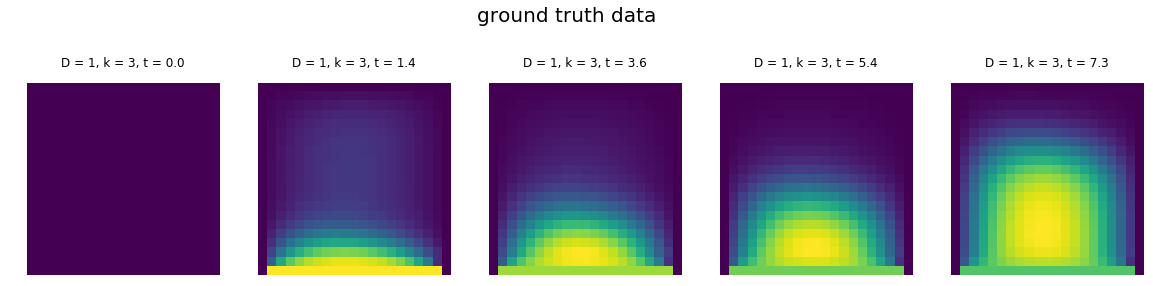

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def Plot_map(d,k,t):
    v_min = 0.0
    v_max = 0.85
    f = []
    for t_e in t:
        f.append("test_txt/mesh_"+d+"_"+k+"_"+t_e+".txt")
        
    list_t = []    
    list_r = []
    
    for i in f:
        filename = i.split("/")[1]
        list_t.append(readFileasArray("test_txt/"+filename))
        f_l = filename.split(".")
        if f_l[1] == "0":
            new_name = f_l[0] + "." + f_l[2]
            list_r.append(readFileasArray("traindata/"+new_name))
        else:
            list_r.append(readFileasArray("traindata/"+filename))



    fig, ax = plt.subplots(1,5, figsize=(20,5))
    for i in range(5):
        im = ax[i].imshow(list_t[i][::-1],cmap = "jet",vmin=v_min, vmax=v_max)
        ax[i].axis('off')
        ax[i].set_title("D = "+d+", k = "+k+", t = "+t[i],size=18)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
    fig.colorbar(im, cax=cbar_ax)
#     fig.colorbar(im,fraction=0.046, pad=0.04)
#     fig.colorbar(im, ax=ax[-1])
    
    fig.suptitle("data computed by model", fontsize=20)
    plt.savefig("1.pdf")
    plt.show()

    fig, ax = plt.subplots(1,5, figsize=(20,5))
    fig.subplots_adjust(right=0.8)
    for i in range(5):
        im = ax[i].imshow(list_r[i][::-1],cmap = "jet",vmin=v_min, vmax=v_max)
        ax[i].axis('off')
        ax[i].set_title("D = "+d+", k = "+k+", t = "+t[i])
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.5])
    fig.colorbar(im, cax=cbar_ax)
#     fig.suptitle("ground truth data", fontsize=20)
    plt.savefig("2.pdf")
    plt.show()
    

## Accuracy

In [79]:
for file_name in filename_all:
    if file_name.split("_")[3] == '0.txt':
        print(file_name)

# len(filename_test)
# filename_test[1]

traindata/mesh_10_6_0.txt
traindata/mesh_8_10_0.txt
traindata/mesh_3_8_0.txt
traindata/mesh_3_10_0.txt
traindata/mesh_6_6_0.txt
traindata/mesh_1_8_0.txt
traindata/mesh_6_1_0.txt
traindata/mesh_6_3_0.txt
traindata/mesh_10_10_0.txt
traindata/mesh_8_8_0.txt
traindata/mesh_10_1_0.txt
traindata/mesh_10_3_0.txt
traindata/mesh_1_10_0.txt
traindata/mesh_1_6_0.txt
traindata/mesh_3_3_0.txt
traindata/mesh_8_6_0.txt
traindata/mesh_3_1_0.txt
traindata/mesh_8_1_0.txt
traindata/mesh_3_6_0.txt
traindata/mesh_1_3_0.txt
traindata/mesh_1_1_0.txt
traindata/mesh_8_3_0.txt
traindata/mesh_6_8_0.txt
traindata/mesh_6_10_0.txt
traindata/mesh_10_8_0.txt


## input

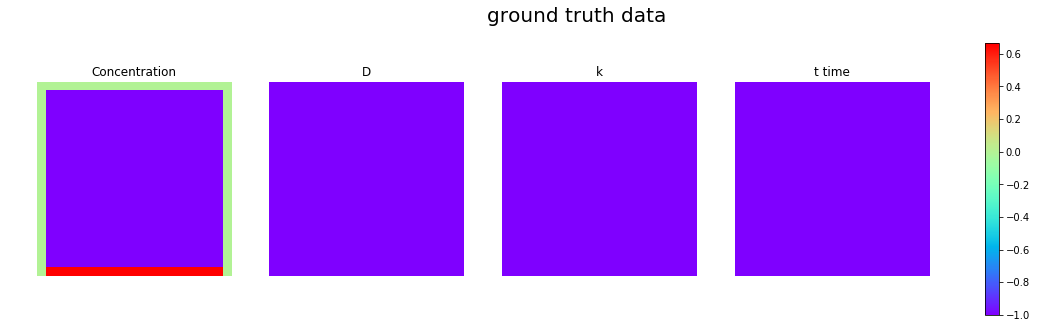

In [183]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
# cmap = cm.ScalarMappable(cmap='rainbow')
im = ax[0].imshow(readFileasArray("mesh_input.txt"),cmap='rainbow')
ax[1].imshow(np.zeros((21,21)),cmap='rainbow')
ax[2].imshow(np.zeros((21,21)),cmap='rainbow')
ax[3].imshow(np.zeros((21,21)),cmap='rainbow')
for i in range(4):
    ax[i].axis('off')

ax[0].set_title("Concentration")
ax[1].set_title("D")
ax[2].set_title("k")
ax[3].set_title("t time")

# cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])
fig.colorbar(im, ax=ax.ravel().tolist())

fig.suptitle("ground truth data", fontsize=20)
plt.show()
